In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde, chi2
import pymc3 as pm
import theano.tensor as tt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [4]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

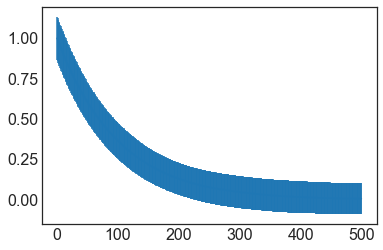

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

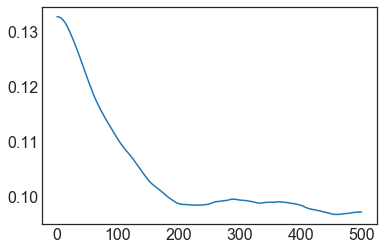

In [6]:
plt.plot(t,acf_std)

In [7]:
acf_all[0].size

500

In [8]:
mod = ExponentialModel()
result_array = None
for i,y in enumerate(acf_all):
    print("***** Iteration ",i," *****")
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = None
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            out.covar[0,0],
                            out.values['amplitude'],
                            out.covar[1,1],
                            out.covar[0,1],
                              out.chisqr])
        print(out.fit_report(min_correl=0.25))
        
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = None
        print('fit did not work weights')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            out2.covar[0,0],
                            out2.values['amplitude'],
                            out2.covar[1,1],
                            out2.covar[0,1],
                            out2.chisqr])
        print(out2.fit_report(min_correl=0.25))
    
    if (fit_results is None) or (fit_std_results is None):
        continue
        
    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  0  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.37953197
    reduced chi-square = 7.6211e-04
    Akaike info crit   = -3587.71227
    Bayesian info crit = -3579.28305
[[Variables]]
    amplitude:  0.80861570 +/- 0.00548762 (0.68%) (init = 1)
    decay:      99.3941865 +/- 0.96000784 (0.97%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 36.8918773
    reduced chi-square = 0.07408007
    Akaike info crit   = -1299.30835
    Bayesian info crit = -1290.87913
[[Variables]]
    amplitude:  0.79842691 +/- 0.00669524 (0.84%) (init = 1)
    decay:      101.268683 +/- 1.05611196 (

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.44075829
    reduced chi-square = 0.00490112
    Akaike info crit   = -2657.14967
    Bayesian info crit = -2648.72045
[[Variables]]
    amplitude:  1.05813840 +/- 0.01674502 (1.58%) (init = 1)
    decay:      67.8930721 +/- 1.53095220 (2.25%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 237.897157
    reduced chi-square = 0.47770514
    Akaike info crit   = -367.384815
    Bayesian info crit = -358.955599
[[Variables]]
    amplitude:  1.08460230 +/- 0.02140803 (1.97%) (init = 1)
    decay:      65.2493326 +/- 1.63416665 (2.50%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 5.91359509
    reduced chi-square = 0.01187469
    Akaike info crit   = -2214.67707
    Bayesian info crit = -2206.24786
[[Variables]]
    amplitude:  1.06715168 +/- 0.02658181 (2.49%) (init = 1)
    decay:      65.2104713 +/- 2.31440132 (3.55%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 605.870459
    reduced chi-square = 1.21660735
    Akaike info crit   = 100.029051
    Bayesian info crit = 108.458267
[[Variables]]
    amplitude:  1.09304137 +/- 0.03484598 (3.19%) (init = 1)
    decay:      62.8225780 +/- 2.54796008 (4.06%) (init = 100)
[[Correl

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 148.997363
    reduced chi-square = 0.29919149
    Akaike info crit   = -601.339745
    Bayesian info crit = -592.910529
[[Variables]]
    amplitude:  0.89851435 +/- 0.01802716 (2.01%) (init = 1)
    decay:      57.9027734 +/- 1.48716379 (2.57%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.706
***** Iteration  67  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.27414567
    reduced chi-square = 0.00255853
    Akaike info crit   = -2982.16611
    Bayesian info crit = -2973.73689
[[Variables]]
    amplitude:  1.17667745 +/- 0.01048771 (0.89%) (init = 1)
    decay:      91.1122577 +/- 1.15539912 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 2.06394917
    reduced chi-square = 0.00414448
    Akaike info crit   = -2740.99344
    Bayesian info crit = -2732.56422
[[Variables]]
    amplitude:  0.96199809 +/- 0.01227630 (1.28%) (init = 1)
    decay:      108.361553 +/- 1.96959774 (1.82%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 205.042588
    reduced chi-square = 0.41173210
    Akaike info crit   = -441.695198
    Bayesian info crit = -433.265981
[[Variables]]
    amplitude:  0.93027719 +/- 0.01488353 (1.60%) (init = 1)
    decay:      113.346093 +/- 2.25558426 (1.99%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.29033434
    reduced chi-square = 5.8300e-04
    Akaike info crit   = -3721.66511
    Bayesian info crit = -3713.23589
[[Variables]]
    amplitude:  0.80357621 +/- 0.00421530 (0.52%) (init = 1)
    decay:      130.669620 +/- 0.98177453 (0.75%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.708
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 26.2267036
    reduced chi-square = 0.05266406
    Akaike info crit   = -1469.91499
    Bayesian info crit = -1461.48578
[[Variables]]
    amplitude:  0.79213369 +/- 0.00489733 (0.62%) (init = 1)
    decay:      133.348669 +/- 1.03227085 (0.77%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.41572333
    reduced chi-square = 8.3479e-04
    Akaike info crit   = -3542.17170
    Bayesian info crit = -3533.74249
[[Variables]]
    amplitude:  1.13088427 +/- 0.00510596 (0.45%) (init = 1)
    decay:      127.278212 +/- 0.82210740 (0.65%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.708
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 42.4682355
    reduced chi-square = 0.08527758
    Akaike info crit   = -1228.92585
    Bayesian info crit = -1220.49663
[[Variables]]
    amplitude:  1.13345835 +/- 0.00638391 (0.56%) (init = 1)
    decay:      127.166926 +/- 0.89425583 (0.70%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 74.7197549
    reduced chi-square = 0.15003967
    Akaike info crit   = -946.431792
    Bayesian info crit = -938.002576
[[Variables]]
    amplitude:  1.17213303 +/- 0.01057306 (0.90%) (init = 1)
    decay:      83.0595811 +/- 0.93739412 (1.13%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.716
***** Iteration  155  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.29469381
    reduced chi-square = 5.9175e-04
    Akaike info crit   = -3714.21325
    Bayesian info crit = -3705.78403
[[Variables]]
    amplitude:  1.02348954 +/- 0.00543981 (0.53%) (init = 1)
    decay:      77.9879797 +/- 0.59003148

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 17.9436045
    reduced chi-square = 0.03603133
    Akaike info crit   = -1659.68717
    Bayesian info crit = -1651.25796
[[Variables]]
    amplitude:  0.91199938 +/- 0.00519755 (0.57%) (init = 1)
    decay:      82.5670085 +/- 0.58887596 (0.71%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.715
***** Iteration  178  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.37256787
    reduced chi-square = 7.4813e-04
    Akaike info crit   = -3596.97207
    Bayesian info crit = -3588.54285
[[Variables]]
    amplitude:  1.00725769 +/- 0.00608561 (0.60%) (init = 1)
    decay:      78.8021235 +/- 0.67769983

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 36.5363641
    reduced chi-square = 0.07336619
    Akaike info crit   = -1304.15003
    Bayesian info crit = -1295.72081
[[Variables]]
    amplitude:  1.24487282 +/- 0.00571745 (0.46%) (init = 1)
    decay:      136.272716 +/- 0.78490820 (0.58%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.736
***** Iteration  199  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.43426193
    reduced chi-square = 8.7201e-04
    Akaike info crit   = -3520.35775
    Bayesian info crit = -3511.92854
[[Variables]]
    amplitude:  1.06258067 +/- 0.00652587 (0.61%) (init = 1)
    decay:      79.9079079 +/- 0.69849033

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.06110717
    reduced chi-square = 0.00213074
    Akaike info crit   = -3073.64762
    Bayesian info crit = -3065.21840
[[Variables]]
    amplitude:  0.67544894 +/- 0.00896862 (1.33%) (init = 1)
    decay:      104.218951 +/- 1.97003611 (1.89%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 104.334931
    reduced chi-square = 0.20950789
    Akaike info crit   = -779.500941
    Bayesian info crit = -771.071725
[[Variables]]
    amplitude:  0.64703203 +/- 0.01072724 (1.66%) (init = 1)
    decay:      111.115925 +/- 2.29066308 (2.06%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 113.959397
    reduced chi-square = 0.22883413
    Akaike info crit   = -735.382941
    Bayesian info crit = -726.953724
[[Variables]]
    amplitude:  0.97739635 +/- 0.01430240 (1.46%) (init = 1)
    decay:      69.8120077 +/- 1.29058442 (1.85%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.710
***** Iteration  242  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 2.81614104
    reduced chi-square = 0.00565490
    Akaike info crit   = -2585.62029
    Bayesian info crit = -2577.19107
[[Variables]]
    amplitude:  1.14009261 +/- 0.01777929 (1.56%) (init = 1)
    decay:      69.5336988 +/- 1.54490640

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 3.10401545
    reduced chi-square = 0.00623296
    Akaike info crit   = -2536.95576
    Bayesian info crit = -2528.52654
[[Variables]]
    amplitude:  0.84245340 +/- 0.01847695 (2.19%) (init = 1)
    decay:      71.0095546 +/- 2.21840409 (3.12%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 320.165820
    reduced chi-square = 0.64290325
    Akaike info crit   = -218.884525
    Bayesian info crit = -210.455309
[[Variables]]
    amplitude:  0.85123110 +/- 0.02392615 (2.81%) (init = 1)
    decay:      70.0803795 +/- 2.48746615 (3.55%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 4.05043099
    reduced chi-square = 0.00813340
    Akaike info crit   = -2403.89240
    Bayesian info crit = -2395.46319
[[Variables]]
    amplitude:  1.18545919 +/- 0.01973919 (1.67%) (init = 1)
    decay:      81.5112923 +/- 1.93141650 (2.37%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 422.500481
    reduced chi-square = 0.84839454
    Akaike info crit   = -80.2087567
    Bayesian info crit = -71.7795405
[[Variables]]
    amplitude:  1.19502345 +/- 0.02554284 (2.14%) (init = 1)
    decay:      80.6068198 +/- 2.15809520 (2.68%) (init = 100)
[[Corr

***** Iteration  299  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 1.71586002
    reduced chi-square = 0.00344550
    Akaike info crit   = -2833.34684
    Bayesian info crit = -2824.91762
[[Variables]]
    amplitude:  1.07509766 +/- 0.01170660 (1.09%) (init = 1)
    decay:      98.7138495 +/- 1.52987933 (1.55%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 178.268164
    reduced chi-square = 0.35796820
    Akaike info crit   = -511.659571
    Bayesian info crit = -503.230355
[[Variables]]
    amplitude:  1.07828359 +/- 0.01495902 (1.39%) (init = 1)
    decay:      98.1716720 +/- 1.69461660

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 500
    # variables        = 2
    chi-square         = 4.52669736
    reduced chi-square = 0.00908975
    Akaike info crit   = -2348.30774
    Bayesian info crit = -2339.87853
[[Variables]]
    amplitude:  1.25480586 +/- 0.02283678 (1.82%) (init = 1)
    decay:      67.7094706 +/- 1.75524075 (2.59%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 500
    # variables        = 2
    chi-square         = 445.525826
    reduced chi-square = 0.89463017
    Akaike info crit   = -53.6764416
    Bayesian info crit = -45.2472254
[[Variables]]
    amplitude:  1.28605649 +/- 0.02930622 (2.28%) (init = 1)
    decay:      65.2084625 +/- 1.88555928 (2.89%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 98.5128802
    reduced chi-square = 0.19781703
    Akaike info crit   = -808.210398
    Bayesian info crit = -799.781182
[[Variables]]
    amplitude:  1.28996616 +/- 0.01135993 (0.88%) (init = 1)
    decay:      94.2654786 +/- 1.03375446 (1.10%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.720
***** Iteration  335  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.99397566
    reduced chi-square = 0.00601200
    Akaike info crit   = -2555.00297
    Bayesian info crit = -2546.57375
[[Variables]]
    amplitude:  0.83342260 +/- 0.01454425 (1.75%) (init = 1)
    decay:      112.167087 +/- 2.78935851

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 242.470456
    reduced chi-square = 0.48688847
    Akaike info crit   = -357.864114
    Bayesian info crit = -349.434898
[[Variables]]
    amplitude:  0.95825923 +/- 0.01383274 (1.44%) (init = 1)
    decay:      154.748161 +/- 2.83810945 (1.83%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.743
***** Iteration  355  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 2.31904423
    reduced chi-square = 0.00465672
    Akaike info crit   = -2682.72648
    Bayesian info crit = -2674.29727
[[Variables]]
    amplitude:  0.83931078 +/- 0.01467125 (1.75%) (init = 1)
    decay:      84.5543704 +/- 2.10343623

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 500
    # variables        = 2
    chi-square         = 481.302731
    reduced chi-square = 0.96647135
    Akaike info crit   = -15.0558236
    Bayesian info crit = -6.62660736
[[Variables]]
    amplitude:  1.24986602 +/- 0.03241190 (2.59%) (init = 1)
    decay:      57.8626599 +/- 1.92096423 (3.32%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.706
***** Iteration  376  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.13157635
    reduced chi-square = 2.6421e-04
    Akaike info crit   = -4117.38804
    Bayesian info crit = -4108.95882
[[Variables]]
    amplitude:  0.72401455 +/- 0.00256794 (0.35%) (init = 1)
    decay:      163.471712 +/- 0.84610897

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 2.87154456
    reduced chi-square = 0.00576615
    Akaike info crit   = -2575.87902
    Bayesian info crit = -2567.44980
[[Variables]]
    amplitude:  1.15930622 +/- 0.01818862 (1.57%) (init = 1)
    decay:      67.7052049 +/- 1.51322971 (2.24%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 500
    # variables        = 2
    chi-square         = 273.018925
    reduced chi-square = 0.54823077
    Akaike info crit   = -298.533492
    Bayesian info crit = -290.104276
[[Variables]]
    amplitude:  1.19168198 +/- 0.02301163 (1.93%) (init = 1)
    decay:      64.8267131 +/- 1.58913158 (2.45%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 105.359932
    reduced chi-square = 0.21156613
    Akaike info crit   = -774.612845
    Bayesian info crit = -766.183629
[[Variables]]
    amplitude:  1.07926755 +/- 0.01130814 (1.05%) (init = 1)
    decay:      101.382057 +/- 1.32098532 (1.30%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.722
***** Iteration  422  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 2.32956505
    reduced chi-square = 0.00467784
    Akaike info crit   = -2680.46326
    Bayesian info crit = -2672.03404
[[Variables]]
    amplitude:  1.40110440 +/- 0.01465628 (1.05%) (init = 1)
    decay:      85.1385307 +/- 1.26714286

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 216.507805
    reduced chi-square = 0.43475463
    Akaike info crit   = -414.490751
    Bayesian info crit = -406.061535
[[Variables]]
    amplitude:  1.15292941 +/- 0.01995146 (1.73%) (init = 1)
    decay:      68.2245704 +/- 1.49394557 (2.19%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.710
***** Iteration  445  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 4.99685009
    reduced chi-square = 0.01003384
    Akaike info crit   = -2298.90018
    Bayesian info crit = -2290.47097
[[Variables]]
    amplitude:  1.19473428 +/- 0.02036251 (1.70%) (init = 1)
    decay:      94.8897675 +/- 2.30167534

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.16374511
    reduced chi-square = 3.2881e-04
    Akaike info crit   = -4008.02618
    Bayesian info crit = -3999.59696
[[Variables]]
    amplitude:  0.84399661 +/- 0.00352434 (0.42%) (init = 1)
    decay:      104.141914 +/- 0.61912888 (0.59%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 14.0777042
    reduced chi-square = 0.02826848
    Akaike info crit   = -1781.00791
    Bayesian info crit = -1772.57869
[[Variables]]
    amplitude:  0.83263362 +/- 0.00403189 (0.48%) (init = 1)
    decay:      106.321123 +/- 0.64010997 (0.60%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 69.5978961
    reduced chi-square = 0.13975481
    Akaike info crit   = -981.936880
    Bayesian info crit = -973.507664
[[Variables]]
    amplitude:  0.96277529 +/- 0.00939221 (0.98%) (init = 1)
    decay:      97.2694078 +/- 1.18088917 (1.21%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.721
***** Iteration  495  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.14708093
    reduced chi-square = 0.00230338
    Akaike info crit   = -3034.69385
    Bayesian info crit = -3026.26464
[[Variables]]
    amplitude:  0.88608609 +/- 0.00934211 (1.05%) (init = 1)
    decay:      103.821449 +/- 1.55819825

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 42.2103093
    reduced chi-square = 0.08475966
    Akaike info crit   = -1231.97181
    Bayesian info crit = -1223.54259
[[Variables]]
    amplitude:  0.89397672 +/- 0.00731638 (0.82%) (init = 1)
    decay:      97.2147608 +/- 0.99022433 (1.02%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.721
***** Iteration  516  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.54318879
    reduced chi-square = 0.00109074
    Akaike info crit   = -3408.45322
    Bayesian info crit = -3400.02401
[[Variables]]
    amplitude:  0.86034825 +/- 0.00712632 (0.83%) (init = 1)
    decay:      83.9268042 +/- 0.98931774

    C(amplitude, decay) = -0.717
***** Iteration  538  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 2.76315097
    reduced chi-square = 0.00554850
    Akaike info crit   = -2595.11821
    Bayesian info crit = -2586.68899
[[Variables]]
    amplitude:  1.08485827 +/- 0.01693926 (1.56%) (init = 1)
    decay:      75.3493007 +/- 1.67470206 (2.22%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 281.001422
    reduced chi-square = 0.56425988
    Akaike info crit   = -284.124184
    Bayesian info crit = -275.694968
[[Variables]]
    amplitude:  1.10275745 +/- 0.02183204 (1.98%) (init = 1)
    deca

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.99521542
    reduced chi-square = 0.00400646
    Akaike info crit   = -2757.92804
    Bayesian info crit = -2749.49882
[[Variables]]
    amplitude:  0.93803309 +/- 0.01283627 (1.37%) (init = 1)
    decay:      95.3668018 +/- 1.85709876 (1.95%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 202.210871
    reduced chi-square = 0.40604592
    Akaike info crit   = -448.648516
    Bayesian info crit = -440.219300
[[Variables]]
    amplitude:  0.95415171 +/- 0.01636077 (1.71%) (init = 1)
    decay:      93.3175384 +/- 1.99362118 (2.14%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 79.4265213
    reduced chi-square = 0.15949101
    Akaike info crit   = -915.887882
    Bayesian info crit = -907.458666
[[Variables]]
    amplitude:  0.96579320 +/- 0.01098602 (1.14%) (init = 1)
    decay:      81.8453940 +/- 1.16547531 (1.42%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.715
***** Iteration  581  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 1.64683851
    reduced chi-square = 0.00330690
    Akaike info crit   = -2853.87535
    Bayesian info crit = -2845.44614
[[Variables]]
    amplitude:  0.89619009 +/- 0.01137795 (1.27%) (init = 1)
    decay:      100.363163 +/- 1.81337932

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.57678491
    reduced chi-square = 0.00316623
    Akaike info crit   = -2875.61009
    Bayesian info crit = -2867.18088
[[Variables]]
    amplitude:  1.30576566 +/- 0.01106684 (0.85%) (init = 1)
    decay:      101.608607 +/- 1.22585365 (1.21%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 146.510835
    reduced chi-square = 0.29419846
    Akaike info crit   = -609.754356
    Bayesian info crit = -601.325140
[[Variables]]
    amplitude:  1.33394696 +/- 0.01351629 (1.01%) (init = 1)
    decay:      98.7989279 +/- 1.24542374 (1.26%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 9.14241398
    reduced chi-square = 0.01835826
    Akaike info crit   = -1996.84182
    Bayesian info crit = -1988.41260
[[Variables]]
    amplitude:  1.01732742 +/- 0.02198419 (2.16%) (init = 1)
    decay:      153.719013 +/- 4.81353362 (3.13%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.713
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 915.694999
    reduced chi-square = 1.83874498
    Akaike info crit   = 306.537620
    Bayesian info crit = 314.966836
[[Variables]]
    amplitude:  0.92600700 +/- 0.02533844 (2.74%) (init = 1)
    decay:      175.325208 +/- 6.21969029 (3.55%) (init = 100)
[[Correl

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 248.390411
    reduced chi-square = 0.49877593
    Akaike info crit   = -345.803176
    Bayesian info crit = -337.373960
[[Variables]]
    amplitude:  1.11041367 +/- 0.02126015 (1.91%) (init = 1)
    decay:      68.9023941 +/- 1.66817803 (2.42%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.710
***** Iteration  635  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.65104731
    reduced chi-square = 0.00130732
    Akaike info crit   = -3317.89053
    Bayesian info crit = -3309.46132
[[Variables]]
    amplitude:  0.90327097 +/- 0.00785195 (0.87%) (init = 1)
    decay:      82.8297189 +/- 1.02470679

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 65.4769879
    reduced chi-square = 0.13147990
    Akaike info crit   = -1012.45467
    Bayesian info crit = -1004.02546
[[Variables]]
    amplitude:  0.70992012 +/- 0.00828080 (1.17%) (init = 1)
    decay:      116.799840 +/- 1.69564308 (1.45%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.728
***** Iteration  654  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.32979354
    reduced chi-square = 6.6224e-04
    Akaike info crit   = -3657.94828
    Bayesian info crit = -3649.51907
[[Variables]]
    amplitude:  0.99362200 +/- 0.00547434 (0.55%) (init = 1)
    decay:      86.4217055 +/- 0.67752340

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 2.03669720
    reduced chi-square = 0.00408975
    Akaike info crit   = -2747.63931
    Bayesian info crit = -2739.21009
[[Variables]]
    amplitude:  1.15568952 +/- 0.01231582 (1.07%) (init = 1)
    decay:      106.150854 +/- 1.61091882 (1.52%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 205.601613
    reduced chi-square = 0.41285464
    Akaike info crit   = -440.333860
    Bayesian info crit = -431.904644
[[Variables]]
    amplitude:  1.17146523 +/- 0.01554159 (1.33%) (init = 1)
    decay:      104.579390 +/- 1.72518526 (1.65%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 62.0375851
    reduced chi-square = 0.12457346
    Akaike info crit   = -1039.43384
    Bayesian info crit = -1031.00463
[[Variables]]
    amplitude:  1.03605468 +/- 0.00806279 (0.78%) (init = 1)
    decay:      116.733783 +/- 1.13060970 (0.97%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.728
***** Iteration  694  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.59955363
    reduced chi-square = 0.00120392
    Akaike info crit   = -3359.08898
    Bayesian info crit = -3350.65976
[[Variables]]
    amplitude:  1.06391034 +/- 0.00764079 (0.72%) (init = 1)
    decay:      80.4895111 +/- 0.82276398

***** Iteration  719  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.16582018
    reduced chi-square = 3.3297e-04
    Akaike info crit   = -4001.72973
    Bayesian info crit = -3993.30051
[[Variables]]
    amplitude:  1.01985768 +/- 0.00406499 (0.40%) (init = 1)
    decay:      78.6021735 +/- 0.44595108 (0.57%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 15.0192226
    reduced chi-square = 0.03015908
    Akaike info crit   = -1748.63860
    Bayesian info crit = -1740.20939
[[Variables]]
    amplitude:  1.02246839 +/- 0.00489454 (0.48%) (init = 1)
    decay:      78.1465475 +/- 0.46943193

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 62
    # data points      = 500
    # variables        = 2
    chi-square         = 639.577112
    reduced chi-square = 1.28429139
    Akaike info crit   = 127.099549
    Bayesian info crit = 135.528765
[[Variables]]
    amplitude:  1.13703832 +/- 0.03642470 (3.20%) (init = 1)
    decay:      60.7508097 +/- 2.48357103 (4.09%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.707
***** Iteration  743  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 0.18680615
    reduced chi-square = 3.7511e-04
    Akaike info crit   = -3942.14597
    Bayesian info crit = -3933.71676
[[Variables]]
    amplitude:  0.92972439 +/- 0.00395406 (0.43%) (init = 1)
    decay:      94.0635128 +/- 0.56922380 (

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 8.27364064
    reduced chi-square = 0.01661374
    Akaike info crit   = -2046.76673
    Bayesian info crit = -2038.33752
[[Variables]]
    amplitude:  1.24671275 +/- 0.02479695 (1.99%) (init = 1)
    decay:      106.364395 +/- 3.01352995 (2.83%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 858.085522
    reduced chi-square = 1.72306330
    Akaike info crit   = 274.047836
    Bayesian info crit = 282.477052
[[Variables]]
    amplitude:  1.27470090 +/- 0.03186200 (2.50%) (init = 1)
    decay:      103.893031 +/- 3.22839676 (3.11%) (init = 100)
[[Correl

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.62675542
    reduced chi-square = 0.00125855
    Akaike info crit   = -3336.90350
    Bayesian info crit = -3328.47428
[[Variables]]
    amplitude:  0.88086557 +/- 0.00589995 (0.67%) (init = 1)
    decay:      145.380351 +/- 1.40411631 (0.97%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.711
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 61.6573511
    reduced chi-square = 0.12380994
    Akaike info crit   = -1042.50782
    Bayesian info crit = -1034.07860
[[Variables]]
    amplitude:  0.87101271 +/- 0.00713623 (0.82%) (init = 1)
    decay:      147.685877 +/- 1.52874648 (1.04%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.62499327
    reduced chi-square = 0.00125501
    Akaike info crit   = -3338.31125
    Bayesian info crit = -3329.88203
[[Variables]]
    amplitude:  0.81013173 +/- 0.00683054 (0.84%) (init = 1)
    decay:      105.890264 +/- 1.27131674 (1.20%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 65.5307700
    reduced chi-square = 0.13158789
    Akaike info crit   = -1012.04415
    Bayesian info crit = -1003.61493
[[Variables]]
    amplitude:  0.81077173 +/- 0.00872347 (1.08%) (init = 1)
    decay:      105.748657 +/- 1.41464836 (1.34%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.74818870
    reduced chi-square = 0.00150239
    Akaike info crit   = -3248.35408
    Bayesian info crit = -3239.92487
[[Variables]]
    amplitude:  0.78078135 +/- 0.00899589 (1.15%) (init = 1)
    decay:      72.2527545 +/- 1.18535410 (1.64%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 76.1741875
    reduced chi-square = 0.15296022
    Akaike info crit   = -936.792720
    Bayesian info crit = -928.363504
[[Variables]]
    amplitude:  0.78413937 +/- 0.01151001 (1.47%) (init = 1)
    decay:      71.9529612 +/- 1.33175093 (1.85%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.26857698
    reduced chi-square = 5.3931e-04
    Akaike info crit   = -3760.61289
    Bayesian info crit = -3752.18367
[[Variables]]
    amplitude:  0.88593955 +/- 0.00505936 (0.57%) (init = 1)
    decay:      82.2858261 +/- 0.66878487 (0.81%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 27.1117080
    reduced chi-square = 0.05444118
    Akaike info crit   = -1453.32122
    Bayesian info crit = -1444.89200
[[Variables]]
    amplitude:  0.88706359 +/- 0.00640279 (0.72%) (init = 1)
    decay:      82.2210727 +/- 0.74290195 (0.90%) (init = 100)
[[Corr

    C(amplitude, decay) = -0.705
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 71.7108821
    reduced chi-square = 0.14399776
    Akaike info crit   = -966.982795
    Bayesian info crit = -958.553578
[[Variables]]
    amplitude:  0.89276525 +/- 0.00918945 (1.03%) (init = 1)
    decay:      104.346385 +/- 1.33545346 (1.28%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.724
***** Iteration  877  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.46990177
    reduced chi-square = 0.00295161
    Akaike info crit   = -2910.70626
    Bayesian info crit = -2902.27705
[[Variables]]
    amplitude:  0.92514821 +/- 0.00931921 (1.01%) (init = 1)
    deca

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.23127350
    reduced chi-square = 4.6440e-04
    Akaike info crit   = -3835.38120
    Bayesian info crit = -3826.95198
[[Variables]]
    amplitude:  0.97520202 +/- 0.00451261 (0.46%) (init = 1)
    decay:      89.2711478 +/- 0.58778277 (0.66%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 23.2460483
    reduced chi-square = 0.04667881
    Akaike info crit   = -1530.23647
    Bayesian info crit = -1521.80726
[[Variables]]
    amplitude:  0.97289240 +/- 0.00567217 (0.58%) (init = 1)
    decay:      89.4490268 +/- 0.65053996 (0.73%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 500
    # variables        = 2
    chi-square         = 298.487816
    reduced chi-square = 0.59937312
    Akaike info crit   = -253.939492
    Bayesian info crit = -245.510276
[[Variables]]
    amplitude:  1.29675663 +/- 0.02355896 (1.82%) (init = 1)
    decay:      67.4905187 +/- 1.55263835 (2.30%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.709
***** Iteration  913  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 2.56224076
    reduced chi-square = 0.00514506
    Akaike info crit   = -2632.86296
    Bayesian info crit = -2624.43375
[[Variables]]
    amplitude:  0.57984888 +/- 0.01179025 (2.03%) (init = 1)
    decay:      149.261670 +/- 4.38565689

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 55.6857095
    reduced chi-square = 0.11181869
    Akaike info crit   = -1093.44227
    Bayesian info crit = -1085.01306
[[Variables]]
    amplitude:  0.89036610 +/- 0.00719412 (0.81%) (init = 1)
    decay:      131.234735 +/- 1.32624104 (1.01%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.734
***** Iteration  930  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 2.51259429
    reduced chi-square = 0.00504537
    Akaike info crit   = -2642.64615
    Bayesian info crit = -2634.21693
[[Variables]]
    amplitude:  1.02571255 +/- 0.00972836 (0.95%) (init = 1)
    decay:      235.794049 +/- 3.52964562

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 2.62106044
    reduced chi-square = 0.00526317
    Akaike info crit   = -2621.51456
    Bayesian info crit = -2613.08534
[[Variables]]
    amplitude:  0.83667499 +/- 0.01253824 (1.50%) (init = 1)
    decay:      133.566037 +/- 2.86996329 (2.15%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.709
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 244.919512
    reduced chi-square = 0.49180625
    Akaike info crit   = -352.839232
    Bayesian info crit = -344.410016
[[Variables]]
    amplitude:  0.77823083 +/- 0.01420563 (1.83%) (init = 1)
    decay:      148.057573 +/- 3.41520218 (2.31%) (init = 100)
[[Corr

***** Iteration  955  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 2.15180490
    reduced chi-square = 0.00432089
    Akaike info crit   = -2720.15056
    Bayesian info crit = -2711.72134
[[Variables]]
    amplitude:  0.99539820 +/- 0.01646480 (1.65%) (init = 1)
    decay:      61.7275845 +/- 1.45597359 (2.36%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.701
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 209.024574
    reduced chi-square = 0.41972806
    Akaike info crit   = -432.078136
    Bayesian info crit = -423.648920
[[Variables]]
    amplitude:  1.01945635 +/- 0.02107272 (2.07%) (init = 1)
    decay:      59.3773339 +/- 1.56881146

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.16012254
    reduced chi-square = 0.00433760
    Akaike info crit   = -2718.22157
    Bayesian info crit = -2709.79236
[[Variables]]
    amplitude:  1.04421770 +/- 0.01602864 (1.53%) (init = 1)
    decay:      65.5098423 +/- 1.43313997 (2.19%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 214.095355
    reduced chi-square = 0.42991035
    Akaike info crit   = -420.093299
    Bayesian info crit = -411.664083
[[Variables]]
    amplitude:  1.06737470 +/- 0.02064480 (1.93%) (init = 1)
    decay:      63.2231211 +/- 1.55522394 (2.46%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 249.109625
    reduced chi-square = 0.50022013
    Akaike info crit   = -344.357518
    Bayesian info crit = -335.928302
[[Variables]]
    amplitude:  0.75355499 +/- 0.01255392 (1.67%) (init = 1)
    decay:      196.507689 +/- 4.35529739 (2.22%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.759
***** Iteration  981  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.50581508
    reduced chi-square = 0.00101569
    Akaike info crit   = -3444.09612
    Bayesian info crit = -3435.66690
[[Variables]]
    amplitude:  0.81721639 +/- 0.00620408 (0.76%) (init = 1)
    decay:      103.801187 +/- 1.12184955

    C(amplitude, decay) = -0.765
***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.43006794
    reduced chi-square = 0.00287162
    Akaike info crit   = -2924.44307
    Bayesian info crit = -2916.01386
[[Variables]]
    amplitude:  0.89235650 +/- 0.00979758 (1.10%) (init = 1)
    decay:      118.386389 +/- 1.85459381 (1.57%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.706
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 142.823031
    reduced chi-square = 0.28679323
    Akaike info crit   = -622.500891
    Bayesian info crit = -614.071675
[[Variables]]
    amplitude:  0.89143753 +/- 0.01209905 (1.36%) (init = 1)
    deca

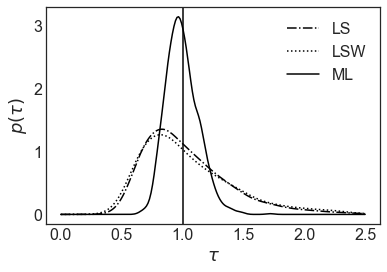

In [9]:
# decay time KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0,2.5,200)
densityLS = gaussian_kde(result_array.T[0])
densityLSW = gaussian_kde(result_array.T[6])
densityML = gaussian_kde(result_Bayes_array.T[2])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.savefig("tau_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

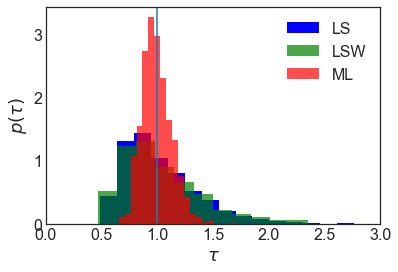

In [10]:
# decay time
plt.figure(facecolor="white")
plt.hist(result_array.T[0],density=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[6],density=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[2],density=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,3))
plt.savefig("tau_dist300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [11]:
phi = 1/result_array.T[3]
theta = 1/result_array.T[1]
omega = 1/result_array.T[4]
dA = np.sqrt(-theta/(phi*theta-omega**2))
dT = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

phiW = 1/result_array.T[9]
thetaW = 1/result_array.T[7]
omegaW = 1/result_array.T[10]
dAW = np.sqrt(-theta/(phi*theta-omega**2))
dTW = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

In [12]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time LSW mean (real):",result_array.T[5].mean())
print("Decay time LSW std (real):",result_array.T[5].std())
print("Decay time LSW stderr (real):",result_array.T[5].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[5].mean()-1)/result_array.T[5].std()*np.sqrt(N))
print("Decay time LSW std (fit):",np.sqrt(result_array.T[6]*delta_t).mean())
print("Decay time LSW std (fit corrected):",dTW.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS mean (real): 1.0511330280624347
Decay time LS std (real): 0.3905818920277206
Decay time LS stderr (real): 0.0039058189202772057
Decay time (mean-true)/stderr: 13.091499914902776
Decay time LS std (fit): 0.00011450259084103781
Decay time LS std (fit corrected): 0.000113979437567719
Decay time LSW mean (real): 1.953151405981036
Decay time LSW std (real): 2.062856350876919
Decay time LSW stderr (real): 0.020628563508769193
Decay time (mean-true)/stderr: 46.20541830631357
Decay time LSW std (fit): 0.10150797451666932
Decay time LSW std (fit corrected): 0.000113979437567719
Decay time Bayes mean (real): 0.9971927568886603
Decay time Bayes std (real): 0.13307109625094737
Decay time Bayes stderr (real): 0.0013307109625094737
Decay time Bayes std (fit): 0.141744498927101


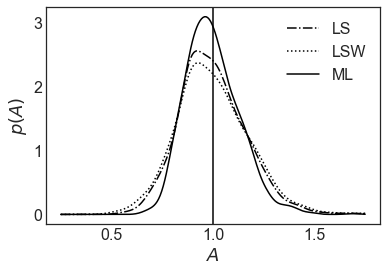

In [13]:
# amplitude KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0.25,1.75,200)
densityLS = gaussian_kde(result_array.T[2])
densityLSW = gaussian_kde(result_array.T[8])
densityML = gaussian_kde(result_Bayes_array.T[0])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")
plt.savefig("A_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

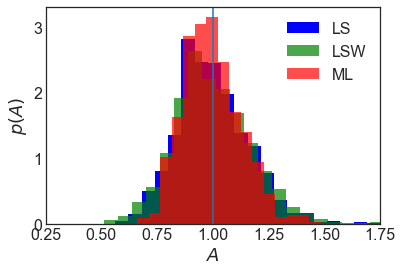

In [14]:
# amplitude
plt.hist(result_array.T[2],density=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[8],density=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[0],density=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0.25,1.75))
plt.savefig("A_dist300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [15]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude LSW mean (real):",result_array.T[7].mean())
print("Amplitude LSW std (real):",result_array.T[7].std())
print("Amplitude LSW stderr (real):",result_array.T[7].std()/np.sqrt(N))
print("Amplitude LSW std (fit):",np.sqrt(result_array.T[8]).mean())
print("Amplitude LSW std (fit corrected):",dAW.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 0.9984105682703185
Amplitude LS std (real): 0.16181660243234747
Amplitude LS stderr (real): 0.0016181660243234748
Amplitude LS std (fit): 1.6478751794738906
Amplitude LS std (fit corrected): 1.6578702573632431
Amplitude LSW mean (real): 0.0002714528255314531
Amplitude LSW std (real): 0.00034691485586727563
Amplitude LSW stderr (real): 3.4691485586727565e-06
Amplitude LSW std (fit): 0.9950832668680414
Amplitude LSW std (fit corrected): 1.6578702573632431
Amplitude Bayes mean (real): 0.9974432559467948
Amplitude Bayes std (real): 0.13182747665608338
Amplitude Bayes std (fit): 0.1410535876226702


(1000, 12)
(1000, 4)
(0.3183106738638477, 5.5484464485969005e-25)


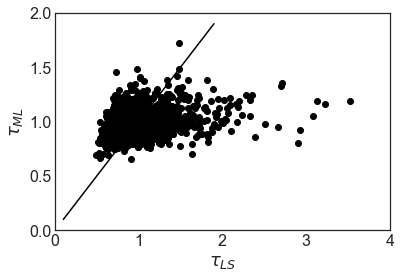

In [16]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(result_array.T[0],result_Bayes_array.T[2],color="k")
plt.plot([0.1,1.9],[0.1,1.9],"k")
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.8370114347767421, 1.3727086902429519e-263)


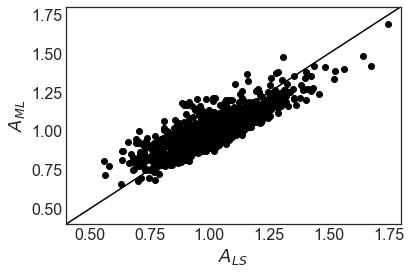

In [17]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0],color="k")
plt.plot([0,1.8],[0,1.8],"k")
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))
plt.savefig("A_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [18]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],dA,result_array.T[0],dT):
    print(i,a,da,t,dt)

0 0.808615696056012 0.9520460345979704 0.9939418654806541 5.44211158822298e-05
1 0.7384507401780944 4.862577555746134 1.659481283174133 0.0001480077515543126
2 0.8189945390255113 1.7689000724257453 1.2161571144605954 8.34126965096077e-05
3 1.177426213439023 0.8946273247059087 0.869670623699744 8.512380556837136e-05
4 1.0437891737470233 1.2763371773673646 0.6674355511975543 0.00014007021533873082
5 0.883051617048809 1.028418417380065 0.7431840677695469 8.582190529365809e-05
6 0.9986686993248759 0.61485594985586 0.8289406605407509 5.205087905933228e-05
7 0.8705609103632095 1.5361640341763998 1.2761723469792459 7.324202103499731e-05
8 1.0469415961904982 0.7094509812806725 1.0666728821039506 4.889410637600743e-05
9 0.8705229773500358 1.1921526795272193 1.404644623697107 5.136756260122944e-05
10 1.210331143970472 1.6411396323246221 0.6449979054220899 0.00021603434174906265
11 1.0678373545348654 2.633043239929993 1.5898917788383589 0.00012159441384276045
12 1.0466327034058365 3.0249401391300

524 0.8727573767846983 1.670498972403628 1.1678374377482823 8.752214212580069e-05
525 0.9873594045357585 1.1045353271164582 0.9298399316502429 8.242928403125454e-05
526 1.0861002235612132 1.240972700599171 0.8435401031129993 0.00011229420441884148
527 1.0631216638542225 1.0191382709720709 1.4820548578754826 5.061290157609542e-05
528 0.7039368578056746 4.850416977693959 1.7357349916119014 0.0001337145136405431
529 0.9408724496231025 2.553247767361064 1.1348718620197595 0.00014846747290053405
530 0.8884795975513082 1.4046449694987875 1.62761117493654 5.2572864194676714e-05
531 0.7581421919916953 3.110450982826316 1.5365776044096995 0.00010589756516485526
532 0.8153484355879081 0.45716620327245233 0.6797721438316197 3.848897667175471e-05
533 1.0211152627711986 2.47138574192383 1.0252271633703218 0.00017292808303682
534 0.9853718794531849 3.702043296065058 1.6538108111499372 0.00015094160673314127
535 1.109335950441387 1.75609331238791 1.1040222276116034 0.00012385665161744096
536 0.959343

In [19]:
n=209
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))
print(acf.shape)

2.66E-01
-0.1768065739727682
0.3989422804014327
0.00E+00
-84750898.99543495
(500,)


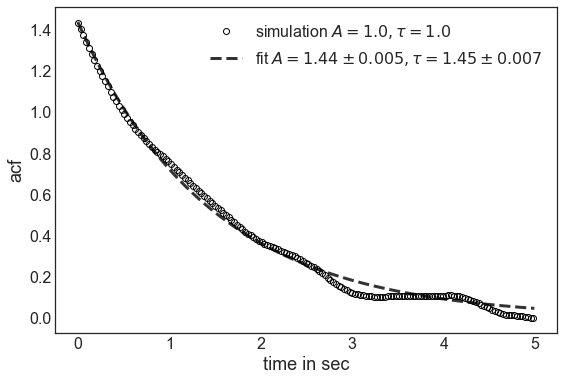

In [20]:
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,"k--",linewidth=3,label=r"fit $A=1.44\pm0.005,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [21]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [22]:
# plot deviation from true D as function of N
Nsim = np.array([2000,10000,50000])
Nsimfit = np.array([1500,10000,60000])
dD = np.array([0.36,0.05,0.014])

(0.005, 1)

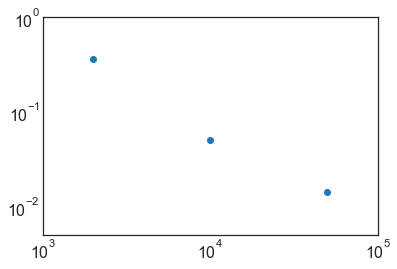

In [23]:
plt.plot(Nsim,dD,"o")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1000,100000))
plt.ylim((0.005,1))

In [24]:
lnNsim = np.log(Nsim)
lndD = np.log(dD)

In [25]:
p = np.polyfit(lnNsim,lndD,1)

In [26]:
# dD = A*Nsim**gamma
# ln dD = ln A + gamma*ln Nsim
dDfit = np.exp(p[1])*Nsimfit**p[0]

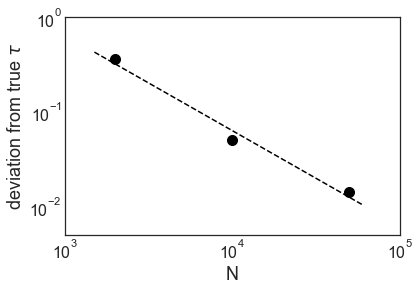

In [27]:
plt.plot(Nsim,dD,"ko",markersize=10)
plt.plot(Nsimfit,dDfit,"k--")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1000,100000))
plt.ylim((0.005,1))
plt.xlabel("N")
plt.ylabel(r"deviation from true $\tau$")
plt.savefig("deviation.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [45]:
with pm.Model() as model:
    A = pm.Uniform('A', lower=0, upper=20)
    ta = pm.Uniform('ta', lower=0, upper=20)

    likelihood = pm.Normal('likelihood', mu=A*pm.math.exp(-t/ta),tau=1,observed=acf)
    
    trace = pm.sample(10000)
    
#pm.traceplot(trace)
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5951.10draws/s]
The acceptance probability does not match the target. It is 0.8873426466131358, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936191686961248, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
A,1.425999,0.164913,0.001488,1.107203,1.753299,12330.090571,0.999977
ta,1.503791,0.256093,0.002428,1.038331,2.017281,12110.771278,0.999953


[1.11262847 1.25931252 1.31137506 1.42255829 1.53567054 1.59315774
 1.76479796]
[1.0732297  1.25772032 1.32369113 1.48043263 1.65755898 1.75382754
 2.08264002]
A_sigma 0.16692261354374227
tau_sigma 0.24805361076256394


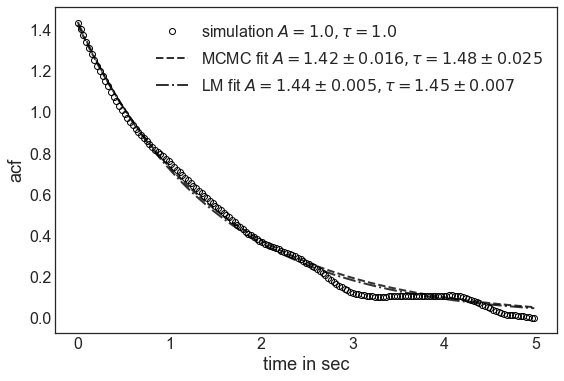

In [30]:
A_perc= np.percentile(trace['A'],[2.5,15.865,25,50,75,84.135,97.5])
tau_perc=np.percentile(trace['ta'],[2.5,15.865,25,50,75,84.135,97.5])
print(A_perc)
print(tau_perc)
print('A_sigma',(A_perc[5]-A_perc[1])/2)
print('tau_sigma',(tau_perc[5]-tau_perc[1])/2)
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t[::3],trace['A'].mean()*np.exp(-t[::3]/trace['ta'].mean()),"k--",linewidth=2,label=r"MCMC fit $A=1.42\pm0.016,\tau=1.48\pm0.025$",alpha=0.8)
plt.plot(t[::3],fit[::3],"k-.",linewidth=2,label=r"LM fit $A=1.44\pm0.005,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit300MCMC.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

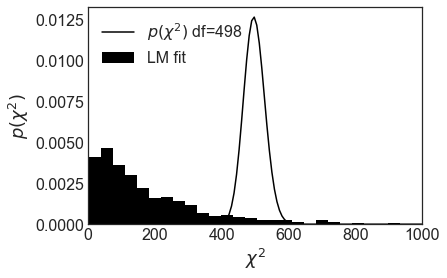

In [31]:
# lets look at the chi^2 distribution of the least-square fit
x=np.linspace(0,1500,200)
chi2dist = chi2.pdf(x,500-2)
plt.hist(result_array.T[11],bins=50,color="k",density=True,label="LM fit")
plt.plot(x,chi2dist,color="k",label=r"$p(\chi^{2})$ df=498")
plt.xlim((0,1000))
plt.ylabel(r"$p(\chi^{2})$")
plt.xlabel(r"$\chi^2$")
plt.legend(loc="upper left")
plt.savefig("chi2dist.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [32]:
result_array.T[11].mean()

192.78086697829272

In [33]:
# use mcmc for all fits
mcmc_results = None

for i,y in enumerate(acf_all):
    with pm.Model() as model:
        A = pm.Uniform('A', lower=0, upper=20)
        ta = pm.Uniform('ta', lower=0, upper=20)

        likelihood = pm.Normal('likelihood', mu=A*pm.math.exp(-t/ta),tau=1,observed=y)
    
        trace = pm.sample(10000)
    A_perc= np.percentile(trace['A'],[2.5,15.865,25,50,75,84.135,97.5])
    tau_perc=np.percentile(trace['ta'],[2.5,15.865,25,50,75,84.135,97.5])
    print(A_perc)
    print(tau_perc)
    A_sigma = (A_perc[5]-A_perc[1])/2
    tau_sigma = (tau_perc[5]-tau_perc[1])/2
    A_med = A_perc[3]
    tau_med = tau_perc[3]
    if mcmc_results is None:
        mcmc_results = np.array([A_med,tau_med,A_sigma,tau_sigma])
    else:
        mcmc_results = np.vstack((mcmc_results,np.array([A_med,tau_med,A_sigma,tau_sigma])))




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4538.14draws/s]
The acceptance probability does not match the target. It is 0.8925682952220453, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.38834866 0.56742655 0.62846545 0.76146976 0.90585277 0.98135545
 1.21479832]
[0.49756779 0.73553235 0.83537553 1.08217844 1.41066887 1.61896778
 2.65080012]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3903.36draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.32553887 0.48152267 0.54143872 0.66812672 0.8050821  0.87663523
 1.11734372]
[ 0.79627886  1.23447853  1.43127461  1.97033955  2.81441355  3.51201204
 10.04342028]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4201.45draws/s]
The acceptance probability does not match the target. It is 0.8891889237104964, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.41736739 0.58386404 0.64251025 0.77182425 0.91259491 0.98334594
 1.21707137]
[0.62391677 0.89930348 1.02236205 1.32984783 1.74866742 2.01664185
 3.42295058]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4282.25draws/s]
The acceptance probability does not match the target. It is 0.8932114533667287, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76775514 0.94859686 1.01153043 1.14920061 1.29319376 1.36463917
 1.58307353]
[0.55261006 0.70272751 0.76063542 0.89944754 1.06017718 1.15189965
 1.49676496]


INFO (theano.gof.compilelock): Waiting for existing lock by process '42454' (I am process '42315')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/hstrey/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.9-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4844.96draws/s]
The acceptance probability does not match the target. It is 0.8950289271864458, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8882336548631414, but should be close to 0.8. Try to increase the number of tuning steps.


[0.59696414 0.79348407 0.8619137  1.01102492 1.16657488 1.24707621
 1.50279327]
[0.37891569 0.5176072  0.5694769  0.69371617 0.84757147 0.93482588
 1.28812552]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4263.20draws/s]
The acceptance probability does not match the target. It is 0.9268149097646294, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.4028236  0.60218746 0.67065634 0.82063241 0.98238318 1.06347171
 1.32124674]
[0.38617198 0.56053467 0.63239891 0.81978475 1.07982579 1.24256468
 2.09486996]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4784.41draws/s]


[0.58611773 0.76211015 0.82687933 0.96531173 1.11321406 1.19206214
 1.43465116]
[0.46584739 0.63773639 0.70534984 0.86752769 1.06796519 1.18202613
 1.62644816]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4574.09draws/s]


[0.51856459 0.66905726 0.72264872 0.83993741 0.96700896 1.03040918
 1.23684172]
[0.71840389 0.99037729 1.09619506 1.34113407 1.65123147 1.83199279
 2.59493644]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4529.25draws/s]
The acceptance probability does not match the target. It is 0.8793986863740837, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913091180890688, but should be close to 0.8. Try to increase the number of tuning steps.


[0.66107346 0.82645465 0.88553546 1.01436381 1.15012392 1.21913271
 1.43586254]
[0.65135703 0.84899173 0.92499815 1.11543074 1.34545158 1.48154222
 1.98648922]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4473.15draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.51210651 0.66447207 0.71917306 0.83650319 0.96276824 1.02458589
 1.22128227]
[0.80652916 1.08693822 1.19919094 1.48811607 1.86640202 2.09262934
 3.07646641]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4959.65draws/s]


[0.77563524 0.96722901 1.03695398 1.18420478 1.34200388 1.4196117
 1.66249885]
[0.40214638 0.51709956 0.56126659 0.66137319 0.77769821 0.84066649
 1.07282113]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4945.52draws/s]
The acceptance probability does not match the target. It is 0.8834593432635046, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849108579745163, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71966694 0.87059324 0.92222098 1.03561959 1.15374324 1.21352476
 1.40342198]
[1.02030999 1.29770239 1.40863825 1.66959428 1.99432395 2.17985814
 2.93486904]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3962.83draws/s]
The acceptance probability does not match the target. It is 0.9021758765707119, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9057863349386686, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.69912909 0.84982511 0.90385809 1.01705087 1.13497556 1.19407878
 1.38100966]
[1.07058417 1.37703096 1.49438164 1.77909211 2.14600688 2.35962226
 3.21387831]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4194.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63600525 0.77857702 0.82721057 0.93415429 1.04515612 1.10023784
 1.27634557]
[1.13442386 1.45114502 1.57962789 1.88390226 2.26551939 2.49212595
 3.44192949]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4115.62draws/s]
The acceptance probability does not match the target. It is 0.8849051056207337, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6435262501295549, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8822523273607914, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.39559338 0.54628899 0.6004647  0.71498502 0.83582453 0.89676611
 1.08773876]
[0.86450785 1.20747418 1.35196082 1.72283093 2.22490097 2.56784163
 4.51215739]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4142.18draws/s]
The acceptance probability does not match the target. It is 0.9112497629481431, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8807199279888229, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.43591675 0.60564364 0.66452585 0.79690126 0.93745454 1.0109577
 1.25034463]
[0.5308743  0.77035261 0.86877612 1.10629097 1.42922567 1.63042503
 2.50105672]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3780.15draws/s]
The acceptance probability does not match the target. It is 0.8912321061610929, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6788921147534633, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936287813043052, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.35677177 0.51043408 0.56637102 0.68391853 0.80738212 0.86919369
 1.07009957]
[0.92305557 1.3225826  1.49567988 1.95622878 2.63869855 3.15211681
 7.00578801]


INFO (theano.gof.compilelock): Waiting for existing lock by process '42454' (I am process '42315')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/hstrey/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.9-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4543.29draws/s]
The acceptance probability does not match the target. It is 0.8904495714345154, but should be close to 0.8. Try to increase the number of tuning steps.


[0.55494053 0.71980695 0.77853473 0.90979399 1.04895419 1.1187341
 1.34695418]
[0.57838539 0.79265659 0.88135583 1.08169223 1.33499081 1.48128342
 2.06404701]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4051.66draws/s]
The acceptance probability does not match the target. It is 0.8960453937698406, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.48587658 0.65949396 0.71875277 0.85228969 0.99424082 1.06484585
 1.28564868]
[0.53582496 0.75349518 0.83884986 1.0516819  1.32683383 1.49459839
 2.18965905]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4879.24draws/s]
The acceptance probability does not match the target. It is 0.8839815814052328, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8968810658056119, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75517633 0.92904474 0.99203729 1.12651722 1.27097207 1.3415344
 1.56543317]
[0.48639363 0.61977173 0.67143025 0.78462269 0.91142747 0.98074098
 1.21138303]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4620.61draws/s]
The acceptance probability does not match the target. It is 0.8960740241108078, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820559221203451, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8893118653247666, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8824017297021467, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.6094668  0.74720583 0.79685283 0.90190696 1.01022438 1.06523819
 1.23585458]
[1.10278103 1.40931702 1.52904263 1.82213352 2.18841841 2.39918206
 3.31329154]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4284.56draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.67601072 0.80975752 0.85562663 0.9561638  1.05930411 1.1119578
 1.27587104]
[1.37626514 1.72641242 1.87019687 2.20874336 2.6382665  2.8870785
 3.94278875]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5070.75draws/s]


[0.61608677 0.80591779 0.87399163 1.01918245 1.1752521  1.2552864
 1.51782051]
[0.39199162 0.52892347 0.58237668 0.7080905  0.86474158 0.95363632
 1.29016717]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4384.80draws/s]
The acceptance probability does not match the target. It is 0.8916432950171195, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.52349764 0.66882595 0.72116017 0.83544553 0.95523797 1.01570433
 1.20821051]
[0.85168236 1.1441278  1.25459855 1.53307961 1.88259121 2.10189499
 3.00178712]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4585.48draws/s]
The acceptance probability does not match the target. It is 0.9044518641357103, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53596641 0.72430224 0.79025438 0.93570661 1.089079   1.16855904
 1.41921754]
[0.38752258 0.54082898 0.59917718 0.74256136 0.91217775 1.0084734
 1.37693624]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4727.81draws/s]
The acceptance probability does not match the target. It is 0.8786136377794738, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.59174322 0.73115451 0.77946787 0.88591854 0.99937219 1.05821866
 1.23403116]
[1.06049433 1.37451257 1.50125945 1.80624723 2.19720264 2.41763004
 3.41282631]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4858.62draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.59979805 0.74297897 0.79405562 0.90241089 1.01906863 1.07699836
 1.25676224]
[1.02399275 1.3294912  1.45473105 1.75124987 2.1354156  2.36172154
 3.33096403]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4424.75draws/s]
The acceptance probability does not match the target. It is 0.8901028790516221, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.45023335 0.61584763 0.6737654  0.79968679 0.93544829 1.00465838
 1.22451238]
[0.62189649 0.87441803 0.98060095 1.24582433 1.58308511 1.79667426
 2.74047522]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5158.10draws/s]
The acceptance probability does not match the target. It is 0.8847360149342691, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842396204916725, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88426729 1.05680005 1.11688656 1.24567046 1.38275871 1.4521286
 1.66557063]
[0.66307349 0.82589754 0.88897026 1.03440757 1.20267688 1.29237937
 1.62061005]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4702.73draws/s]


[0.47490885 0.65088601 0.71474676 0.85745979 1.00855338 1.08528765
 1.3284742 ]
[0.45264486 0.64797601 0.72746996 0.92773153 1.18548604 1.3395419
 1.99114554]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4208.65draws/s]
The acceptance probability does not match the target. It is 0.8834748180099531, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9107469070764905, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.49756013 0.66564239 0.72513314 0.85336336 0.98999161 1.05956759
 1.27501579]
[0.71672843 0.99104171 1.10732743 1.38949083 1.76599488 2.00515051
 3.16294183]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4940.85draws/s]


[0.52855603 0.70074202 0.76283007 0.89672311 1.03695566 1.11176577
 1.34341927]
[0.4654505  0.64133115 0.71020282 0.87280155 1.06962206 1.18219609
 1.6139159 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4070.36draws/s]
The acceptance probability does not match the target. It is 0.8851578506729962, but should be close to 0.8. Try to increase the number of tuning steps.


[0.54392664 0.74086205 0.80967488 0.96103742 1.1249569  1.2058112
 1.47431482]
[0.37347809 0.51952688 0.57805701 0.71912434 0.89734855 1.00441274
 1.44100174]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4311.65draws/s]
The acceptance probability does not match the target. It is 0.8880015204447999, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.882381937738903, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.53199241 0.69638212 0.75328361 0.87895243 1.01765703 1.08522698
 1.30637208]
[0.61366239 0.84424297 0.93500335 1.15630192 1.4336122  1.59713722
 2.26077563]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4369.27draws/s]
The acceptance probability does not match the target. It is 0.8837763138392197, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.39197652 0.5913555  0.66551853 0.82482599 0.99634924 1.08530599
 1.37347341]
[0.30577471 0.4674681  0.5351832  0.70818516 0.94695123 1.09663416
 1.80597434]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4719.51draws/s]
The acceptance probability does not match the target. It is 0.8845796352134137, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8830649220716964, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.43386311 0.61100352 0.6772992  0.82381135 0.98040991 1.0606568
 1.32048523]
[0.42089498 0.6145695  0.69450865 0.89438223 1.16002034 1.32328154
 2.07235309]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4440.75draws/s]
The acceptance probability does not match the target. It is 0.8968271265602252, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.74509597 0.93397931 1.00093708 1.14302509 1.29584851 1.37392365
 1.61190536]
[0.44792613 0.58206627 0.63313557 0.74942988 0.88894974 0.96315094
 1.23994641]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5849.44draws/s]


[0.70885723 0.87474978 0.93255557 1.05758668 1.1837534  1.24918237
 1.4475375 ]
[0.75349459 0.95982584 1.04128512 1.23684171 1.47682566 1.61208412
 2.14064336]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6014.69draws/s]
The acceptance probability does not match the target. It is 0.8931992166348797, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0806969  1.24345808 1.30012759 1.42175101 1.54853536 1.61125359
 1.80560186]
[0.70136167 0.82721453 0.87351305 0.9775183  1.09149422 1.15290094
 1.34657503]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4629.22draws/s]
The acceptance probability does not match the target. It is 0.8895448847331365, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53234851 0.70132517 0.75922084 0.88591436 1.02295225 1.09277298
 1.31273266]
[0.5348257  0.73464919 0.81377644 0.99322235 1.21402513 1.33908696
 1.83717794]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4717.40draws/s]


[0.70795003 0.86231309 0.91510563 1.028062   1.14927169 1.20921743
 1.39298563]
[0.83510438 1.04989895 1.13346728 1.32492207 1.55739552 1.6818082
 2.16562969]


INFO (theano.gof.compilelock): Waiting for existing lock by process '42454' (I am process '42315')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/hstrey/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.9-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4806.77draws/s]
The acceptance probability does not match the target. It is 0.8824594707685924, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796413080005181, but should be close to 0.8. Try to increase the number of tuning steps.


[0.69538919 0.87146581 0.93607091 1.07624123 1.22601343 1.30251467
 1.53713763]
[0.45632452 0.5921587  0.64471529 0.76697772 0.91386597 0.99454345
 1.29741416]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4940.76draws/s]
The acceptance probability does not match the target. It is 0.8934697677134621, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96446859 1.10489666 1.15394228 1.2588375  1.36701354 1.42003701
 1.58146597]
[1.28708454 1.53577784 1.6338868  1.85945511 2.12085271 2.26963939
 2.78717437]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3766.87draws/s]
The acceptance probability does not match the target. It is 0.8930013376555547, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.24126577 0.39921632 0.4659711  0.60486199 0.75348333 0.83228853
 1.09340684]
[0.54391649 0.89401071 1.0593725  1.50884781 2.26916314 2.90701761
 9.78336986]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5162.80draws/s]
The acceptance probability does not match the target. It is 0.8864463743511838, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86245367 1.0222129  1.07981252 1.20363897 1.33235554 1.39881892
 1.59193697]
[0.69970263 0.86025231 0.92057855 1.06038188 1.22275609 1.31033576
 1.61987904]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4818.02draws/s]
The acceptance probability does not match the target. It is 0.8846855178497686, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63428735 0.82609576 0.89311619 1.04091022 1.19799226 1.27764746
 1.53207889]
[0.3757951  0.50362891 0.55318092 0.66800954 0.80573626 0.88047174
 1.14583519]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4116.22draws/s]
The acceptance probability does not match the target. It is 0.8951739688500814, but should be close to 0.8. Try to increase the number of tuning steps.


[0.6126379  0.79301955 0.85708578 0.9946248  1.13948649 1.21379864
 1.44202315]
[0.51745582 0.68632811 0.75307532 0.91707973 1.12182318 1.24018603
 1.71634073]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4279.96draws/s]
The acceptance probability does not match the target. It is 0.9103990962698757, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.42942556 0.61859585 0.6853574  0.82678185 0.97791764 1.05604083
 1.30072853]
[0.42527553 0.60861466 0.68485109 0.87079951 1.11355003 1.27083831
 1.99782847]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5156.56draws/s]
The acceptance probability does not match the target. It is 0.894867064069847, but should be close to 0.8. Try to increase the number of tuning steps.


[1.43130451 1.57601919 1.62658103 1.73706442 1.84788988 1.90112735
 2.07346881]
[1.15401341 1.30666023 1.3646697  1.49519991 1.63467927 1.70694689
 1.95360771]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4375.16draws/s]
The acceptance probability does not match the target. It is 0.8969156863900577, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.879702485084739, but should be close to 0.8. Try to increase the number of tuning steps.


[0.61015919 0.78304043 0.84532629 0.98077397 1.12787345 1.20117973
 1.43007556]
[0.48797581 0.65601498 0.72047879 0.87247375 1.05863379 1.16294154
 1.55817044]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4646.59draws/s]


[0.4525796  0.64119686 0.70984981 0.86008513 1.02061614 1.10231761
 1.36432037]
[0.3681507  0.52731838 0.5929977  0.75937644 0.97596568 1.10511662
 1.66033234]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4133.86draws/s]
The acceptance probability does not match the target. It is 0.9063746574538112, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8999495125987478, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.38490137 0.57737826 0.64510076 0.79035041 0.95115798 1.03563422
 1.30625489]
[0.3839064  0.58520277 0.67307802 0.89441469 1.19353412 1.38930984
 2.36300235]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4416.71draws/s]


[0.80169896 0.92454429 0.96869329 1.0638171  1.16026852 1.20922941
 1.35718293]
[1.60697296 1.94531938 2.07166301 2.38352502 2.77203591 2.99629193
 3.84466766]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4272.53draws/s]
The acceptance probability does not match the target. It is 0.8839268562742597, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.890709964578464, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.37898859 0.5516795  0.61283748 0.74536171 0.8910788  0.96392265
 1.20321353]
[0.46397806 0.69132806 0.7877739  1.02123819 1.33861509 1.53406436
 2.46697701]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4040.84draws/s]
The acceptance probability does not match the target. It is 0.8804806171573191, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8862424169654943, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.63110619 0.79064924 0.84781908 0.97233207 1.1040448  1.17055583
 1.37610212]
[0.6166313  0.80165711 0.87422377 1.0432285  1.2461095  1.35699322
 1.78202995]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4321.53draws/s]
The acceptance probability does not match the target. It is 0.8912660716470507, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9064935379036315, but should be close to 0.8. Try to increase the number of tuning steps.


[0.59014641 0.76100854 0.82235986 0.95452175 1.09578941 1.16438441
 1.38345788]
[0.57256476 0.76535245 0.84424891 1.02774332 1.25428073 1.38220718
 1.89798059]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4170.71draws/s]
The acceptance probability does not match the target. It is 0.8829173631078401, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880681937179358, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.46042586 0.61990698 0.67687316 0.80035879 0.93061888 0.9970984
 1.2202085 ]
[0.66837197 0.95224224 1.06535698 1.33884115 1.70279557 1.92261359
 2.99646108]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4976.52draws/s]
The acceptance probability does not match the target. It is 0.8816499172592723, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83570659 0.99695199 1.05185175 1.17375366 1.30088088 1.36147498
 1.56070768]
[0.70572612 0.87249532 0.93487511 1.07269027 1.23210405 1.32036715
 1.62881448]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4266.07draws/s]
The acceptance probability does not match the target. It is 0.8905623858311608, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886193721647214, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.53120647 0.69146839 0.74921429 0.87642679 1.01355281 1.08357827
 1.30134438]
[0.69375798 0.95682496 1.06658941 1.33443421 1.69009022 1.90238153
 2.79678926]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5157.72draws/s]


[0.63465779 0.81141362 0.87246409 1.00751833 1.15227575 1.22507723
 1.45311874]
[0.52194287 0.69981009 0.77071847 0.93227395 1.12982936 1.24071009
 1.66963159]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4707.64draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.42113928 0.57685605 0.63356421 0.75641328 0.8889933  0.95522834
 1.1766689 ]
[0.59293589 0.85449873 0.95866195 1.22408914 1.56706534 1.77803518
 2.73378916]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4634.46draws/s]
The acceptance probability does not match the target. It is 0.8889419541745811, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.46952332 0.66967527 0.74031481 0.89794227 1.06595224 1.15335348
 1.42827527]
[0.32912781 0.47346923 0.53235903 0.68066198 0.86822833 0.98072816
 1.48928601]


INFO (theano.gof.compilelock): Waiting for existing lock by process '42454' (I am process '42315')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/hstrey/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.9-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3743.82draws/s]
The acceptance probability does not match the target. It is 0.8838146159874194, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.33822054 0.55425664 0.63278929 0.80368027 0.98568289 1.07737053
 1.36411169]
[0.45391142 0.68274521 0.79275806 1.11786878 1.66305285 2.06442273
 5.68862994]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4672.27draws/s]


[0.54725666 0.71793424 0.78017629 0.91067514 1.05235649 1.12466768
 1.3567129 ]
[0.49338257 0.67473768 0.74724759 0.91491145 1.11894895 1.23640536
 1.66916552]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4581.60draws/s]
The acceptance probability does not match the target. It is 0.8929955440562876, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78403055 0.97961386 1.04959082 1.1991574  1.35529112 1.43218605
 1.68001388]
[0.44973202 0.57801659 0.62763542 0.74641925 0.89061893 0.97267981
 1.28052976]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4554.11draws/s]
The acceptance probability does not match the target. It is 0.8909753877915728, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.47503822 0.68855812 0.76441982 0.92776574 1.09962912 1.1836577
 1.45144147]
[0.3464069  0.49001506 0.55052027 0.69854264 0.9075784  1.04111763
 1.68265229]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4414.47draws/s]
The acceptance probability does not match the target. It is 0.8790290444891131, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9015616174209693, but should be close to 0.8. Try to increase the number of tuning steps.


[0.40541847 0.6073638  0.67944541 0.83876439 1.01730513 1.10427921
 1.39078104]
[0.27718559 0.42272366 0.48348552 0.63060081 0.82039185 0.93251628
 1.42116791]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4088.36draws/s]
The acceptance probability does not match the target. It is 0.9059186138546717, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76672985 0.94294283 1.00464139 1.14285523 1.28787519 1.36103461
 1.58424648]
[0.57508544 0.73600337 0.79908758 0.94766689 1.12807914 1.2292004
 1.60072484]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4969.91draws/s]
The acceptance probability does not match the target. It is 0.8897546918991757, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93028129 1.08759521 1.14275967 1.26038627 1.38139098 1.44255695
 1.62748663]
[0.76158168 0.91039153 0.96709075 1.09378547 1.23522687 1.31075525
 1.57467531]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4798.09draws/s]


[0.59425483 0.77249927 0.83631421 0.97220895 1.11684883 1.19059485
 1.42951369]
[0.49997983 0.66925837 0.73739654 0.90088086 1.1041332  1.21746542
 1.6713226 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3737.24draws/s]
The acceptance probability does not match the target. It is 0.9014247694679848, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.53092643 0.70575529 0.76794153 0.90274293 1.04807381 1.12249967
 1.3563592 ]
[0.53360771 0.73473177 0.81552095 1.01347192 1.26210669 1.410646
 2.03722163]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4902.36draws/s]
The acceptance probability does not match the target. It is 0.8920281711754301, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8805731273027981, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8857979021529134, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57084176 0.73983618 0.80212589 0.93527917 1.07673075 1.14799511
 1.37765102]
[0.53865736 0.7325634  0.8072551  0.98601953 1.20762498 1.33708994
 1.8671322 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4440.99draws/s]


[0.77273411 0.9752505  1.04680524 1.20494612 1.37014173 1.45471218
 1.71386104]
[0.37885613 0.48683351 0.52898301 0.62965258 0.75191631 0.81995333
 1.08154416]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4890.01draws/s]


[0.47443089 0.6724513  0.74303367 0.89837813 1.06700045 1.15283293
 1.42522095]
[0.32441068 0.47344371 0.53293903 0.67695039 0.86600192 0.97832547
 1.46345179]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4131.35draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.30059276 0.49530296 0.56435922 0.7147186  0.87743282 0.96223984
 1.23220433]
[0.34697273 0.54801803 0.63206644 0.84927719 1.16680355 1.37562616
 2.61541046]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4901.23draws/s]


[0.82878625 1.01200606 1.07626635 1.21553429 1.36279676 1.43566794
 1.66617724]
[0.49053029 0.6165095  0.6629166  0.77357928 0.90257546 0.97406407
 1.22290719]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4089.37draws/s]
The acceptance probability does not match the target. It is 0.8830665283853796, but should be close to 0.8. Try to increase the number of tuning steps.


[0.872817   1.04782016 1.10818991 1.23913019 1.37676766 1.44618357
 1.66084105]
[0.57897062 0.71518527 0.76827123 0.88607746 1.02061185 1.09264962
 1.34027498]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3721.36draws/s]
The acceptance probability does not match the target. It is 0.8957913265134229, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.29940884 0.48190769 0.54495435 0.67738319 0.82186742 0.89579536
 1.13761598]
[0.55167502 0.85087659 0.98101817 1.32354594 1.82907927 2.19580382
 4.94923441]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4492.23draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.31829549 0.48572253 0.54384735 0.67138524 0.81042767 0.88048139
 1.11467082]
[0.54062964 0.80543464 0.91940993 1.21377162 1.62963875 1.89118277
 3.55652766]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4580.06draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.61835636 0.78191561 0.84250563 0.97497908 1.11499148 1.18670328
 1.40660765]
[0.71156114 0.94940124 1.05162536 1.30391391 1.62425468 1.82077091
 2.68261129]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3755.89draws/s]
The acceptance probability does not match the target. It is 0.8799690727289752, but should be close to 0.8. Try to increase the number of tuning steps.


[0.55365544 0.74494556 0.81270796 0.95807161 1.10790138 1.18458117
 1.42329379]
[0.52567149 0.71706183 0.79867821 1.00422437 1.27194278 1.43793685
 2.19353313]


INFO (theano.gof.compilelock): Waiting for existing lock by process '42454' (I am process '42315')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/hstrey/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.9-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4426.61draws/s]
The acceptance probability does not match the target. It is 0.9249183410337064, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.50542258 0.648197   0.69647269 0.80284276 0.91265637 0.96674412
 1.14015959]
[1.03858135 1.37919153 1.51258126 1.83744487 2.2618441  2.52522149
 3.79553884]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4255.25draws/s]
The acceptance probability does not match the target. It is 0.8959249259592172, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891123215243573, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67688231 0.88137333 0.95290598 1.10625194 1.27067825 1.35348906
 1.61008541]
[0.37295223 0.4939407  0.54144842 0.65163942 0.78820384 0.86700059
 1.19146787]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6098.99draws/s]
The acceptance probability does not match the target. It is 0.8802049233059314, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5516096  0.72742176 0.79011079 0.92504977 1.06924886 1.14188722
 1.37871696]
[0.47672822 0.65142119 0.72116715 0.88567849 1.08878879 1.20801496
 1.6702104 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4992.93draws/s]
The acceptance probability does not match the target. It is 0.8807573184764549, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.5500885  0.72194344 0.78512889 0.91492623 1.05497827 1.12699746
 1.34891738]
[0.48458772 0.65309611 0.72075538 0.87612546 1.06309343 1.1681085
 1.56099288]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4874.64draws/s]
The acceptance probability does not match the target. It is 0.9005552936400955, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838015163180384, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97671463 1.14579857 1.20342599 1.32958216 1.46045375 1.52405314
 1.72307851]
[0.74343146 0.89860363 0.95707947 1.09275167 1.2504037  1.33856305
 1.65284497]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4752.11draws/s]


[0.64969663 0.86007181 0.9339854  1.09698429 1.26931113 1.35569419
 1.62829316]
[0.30986987 0.41683431 0.45879339 0.55820188 0.68142081 0.7495671
 1.02261472]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5108.60draws/s]


[0.63024547 0.79699783 0.8559979  0.98559418 1.1248671  1.19598728
 1.41710756]
[0.6294812  0.83457527 0.91796841 1.11440586 1.35959532 1.50057934
 2.044269  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5145.56draws/s]


[0.92082524 1.07154686 1.12554311 1.23629747 1.35314353 1.41222323
 1.59088437]
[0.97436732 1.169258   1.24308871 1.41352679 1.61522736 1.72541522
 2.1191747 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5180.94draws/s]
The acceptance probability does not match the target. It is 0.889347049378113, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8881605785449697, but should be close to 0.8. Try to increase the number of tuning steps.


[0.50639047 0.69826981 0.76631883 0.91102083 1.06682863 1.14408173
 1.39294644]
[0.38947048 0.54391188 0.60465147 0.74688043 0.9312151  1.0364286
 1.48831463]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4486.29draws/s]
The acceptance probability does not match the target. It is 0.8787061148876365, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


[0.54224571 0.71513052 0.77641999 0.91319983 1.05873796 1.13129113
 1.3601031 ]
[0.6071951  0.83476265 0.93414565 1.17502309 1.48987073 1.68003293
 2.53050736]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4210.85draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.42745155 0.62433232 0.69276068 0.84715076 1.01334268 1.09782445
 1.37171616]
[0.37758963 0.55217431 0.62701508 0.81723893 1.08201988 1.25307894
 2.0392191 ]


INFO (theano.gof.compilelock): Waiting for existing lock by process '42454' (I am process '42315')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/hstrey/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.9-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5367.46draws/s]
The acceptance probability does not match the target. It is 0.8792134611484176, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65282227 0.82122084 0.88090976 1.01071285 1.14602137 1.21496726
 1.42841118]
[0.63275132 0.82622055 0.89948239 1.07870219 1.30301668 1.4313707
 1.91901223]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4385.46draws/s]
The acceptance probability does not match the target. It is 0.8971476063601836, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.43583548 0.6266283  0.6939517  0.8435019  1.00519268 1.08588107
 1.35364706]
[0.38508469 0.56254366 0.63492709 0.81970499 1.06281502 1.21238718
 1.88551797]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4508.48draws/s]
The acceptance probability does not match the target. It is 0.8853573295667234, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885457927564216, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8958073310710282, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82732027 0.96828772 1.01846195 1.12364375 1.23158248 1.28792251
 1.45685961]
[1.08128536 1.31460768 1.40249655 1.60782318 1.85207973 1.98883079
 2.48032018]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5067.19draws/s]


[0.51222228 0.68946925 0.75319137 0.89111156 1.04109001 1.11471656
 1.3417466 ]
[0.43161188 0.59880967 0.66519161 0.8190698  1.00979428 1.11957948
 1.55870185]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4815.85draws/s]
The acceptance probability does not match the target. It is 0.9214518848065472, but should be close to 0.8. Try to increase the number of tuning steps.


[0.62462018 0.82058151 0.89234293 1.04430264 1.20493881 1.2854328
 1.53524711]
[0.37420564 0.49665681 0.54386695 0.65779706 0.79504411 0.87671616
 1.18771923]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4157.31draws/s]
The acceptance probability does not match the target. It is 0.9331497052731583, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903352425907507, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


[0.3061627  0.55700166 0.63922121 0.80864426 0.98852685 1.08234895
 1.38727454]
[0.28087341 0.42905086 0.49312049 0.65598343 0.89549528 1.06422906
 2.33712378]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4347.95draws/s]
The acceptance probability does not match the target. It is 0.8824599056043703, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9073959470428116, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.43501372 0.6229498  0.69061836 0.84114335 1.00185244 1.08449168
 1.35905952]
[0.40760241 0.5995441  0.68157214 0.89179587 1.17328455 1.34793131
 2.15133385]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4998.94draws/s]
The acceptance probability does not match the target. It is 0.8841301508494822, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891498364435753, but should be close to 0.8. Try to increase the number of tuning steps.


[0.67993902 0.87370293 0.94295343 1.09150079 1.25027613 1.32993649
 1.58410665]
[0.36949354 0.4974256  0.54406028 0.65150226 0.774252   0.84438103
 1.09834517]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4539.59draws/s]
The acceptance probability does not match the target. It is 0.8959627035046365, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86343258 1.01561959 1.0720152  1.19051246 1.31238109 1.37372087
 1.55722297]
[0.86812682 1.06024959 1.13517825 1.30858707 1.51142163 1.61977768
 2.01034872]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6308.14draws/s]
Auto-assigning NUTS sampler...


[0.66927628 0.84329566 0.90429745 1.03761047 1.18192493 1.25445787
 1.48309741]
[0.54054356 0.70987788 0.77719233 0.93462664 1.12720635 1.23735317
 1.62983814]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4749.00draws/s]
The acceptance probability does not match the target. It is 0.886427973444694, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.42565455 0.60975346 0.6725752  0.81238912 0.95928707 1.03515019
 1.28441342]
[0.41649053 0.59775163 0.67466026 0.85071702 1.07802102 1.2189119
 1.83279797]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5019.65draws/s]


[0.69479295 0.87232529 0.9346265  1.07063916 1.21774532 1.29179811
 1.52308334]
[0.57386162 0.75503123 0.82837798 1.00263091 1.21765896 1.34037063
 1.82968233]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4620.84draws/s]
The acceptance probability does not match the target. It is 0.8820708899171558, but should be close to 0.8. Try to increase the number of tuning steps.


[0.4562601  0.63123525 0.69063794 0.82288508 0.96670576 1.03974786
 1.27072323]
[0.47658959 0.68225617 0.76482794 0.95596912 1.19851471 1.33641398
 1.91656595]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6030.49draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.42268935 0.6310086  0.70217417 0.85853329 1.02821218 1.11325351
 1.388936  ]
[0.32209356 0.46990239 0.52858045 0.67428636 0.87262976 0.99663862
 1.57125354]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5118.31draws/s]
The acceptance probability does not match the target. It is 0.8894898226474284, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92423391 1.06772468 1.12050697 1.22956444 1.34481903 1.40004205
 1.57428655]
[0.99821164 1.1935959  1.26740353 1.43338263 1.62702331 1.73562503
 2.10680184]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5321.69draws/s]
The acceptance probability does not match the target. It is 0.8809022345045899, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8901005741988729, but should be close to 0.8. Try to increase the number of tuning steps.


[1.16756707 1.32949068 1.38675906 1.50885546 1.63447915 1.69677025
 1.88792317]
[0.78494535 0.914514   0.96394762 1.07624812 1.20040169 1.26756803
 1.49269293]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4510.30draws/s]
The acceptance probability does not match the target. It is 0.8796023926922845, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8848171576755014, but should be close to 0.8. Try to increase the number of tuning steps.


[0.454278   0.63358164 0.69778631 0.84048355 0.99530381 1.07510859
 1.33239301]
[0.41045041 0.59530641 0.67252307 0.86585086 1.11079128 1.25200242
 1.88212663]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5548.46draws/s]


[0.78321137 0.93900773 0.99464041 1.11710202 1.24324246 1.30753476
 1.5013697 ]
[0.73304842 0.91269049 0.98182053 1.14220649 1.33093463 1.43490565
 1.79802831]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4658.27draws/s]
The acceptance probability does not match the target. It is 0.8885720041732297, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9016197648873724, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83830486 1.00178776 1.06366882 1.1894657  1.32193282 1.38885858
 1.59894429]
[0.64962991 0.81141829 0.87132385 1.01250587 1.17445302 1.26381296
 1.5747444 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4843.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.42662274 0.58202676 0.63892713 0.75870305 0.88524794 0.94982309
 1.1511282 ]
[0.71821984 1.00726588 1.12480004 1.42289868 1.81978616 2.07031196
 3.32758366]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4115.30draws/s]
The acceptance probability does not match the target. It is 0.9344389934792651, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8817799871161887, but should be close to 0.8. Try to increase the number of tuning steps.


[0.60222575 0.77609498 0.84117576 0.97952946 1.12540827 1.20068669
 1.42968057]
[0.59052808 0.79460323 0.8780239  1.08341055 1.35430789 1.51636418
 2.18243568]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4214.96draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.37531432 0.55882517 0.62393247 0.76665382 0.92089642 1.00063774
 1.25231092]
[0.60368868 0.8883889  1.02239071 1.37843541 1.9119499  2.2864974
 4.79848274]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4434.45draws/s]
The acceptance probability does not match the target. It is 0.9019439767292821, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8806556603807484, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.4960746  0.65809448 0.71782559 0.84597298 0.98288833 1.05315621
 1.28184288]
[0.50788624 0.70951139 0.78981846 0.97766088 1.20337825 1.3359405
 1.85854718]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5320.67draws/s]
The acceptance probability does not match the target. It is 0.8870016347686253, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8794549436868713, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75603817 0.94407695 1.01069504 1.15125091 1.30152142 1.37615494
 1.614369  ]
[0.43318761 0.55288617 0.59787834 0.69977402 0.81781172 0.88219347
 1.10121477]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4452.08draws/s]
The acceptance probability does not match the target. It is 0.8835628184420047, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.97253493 1.12504862 1.17952955 1.29484153 1.41563785 1.47507359
 1.66064987]
[0.84710159 1.01430583 1.07665484 1.21974262 1.38666457 1.47343909
 1.7815307 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4897.80draws/s]
The acceptance probability does not match the target. It is 0.88545426549906, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8807609229042708, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70077963 0.86914003 0.92831569 1.05630435 1.19246007 1.26145665
 1.47243361]
[0.61905342 0.7993425  0.86857576 1.02995256 1.22215469 1.32717343
 1.721664  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4566.22draws/s]
The acceptance probability does not match the target. It is 0.9007184778347037, but should be close to 0.8. Try to increase the number of tuning steps.


[0.56504077 0.72084527 0.77798403 0.90278427 1.03799318 1.10645683
 1.32634512]
[0.68243445 0.92623752 1.02279196 1.25987603 1.559923   1.73310848
 2.40931899]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5230.38draws/s]
The acceptance probability does not match the target. It is 0.8826783518726862, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91283488 1.0902094  1.15371389 1.2920979  1.43562413 1.50802389
 1.72443922]
[0.57485779 0.71286201 0.76392925 0.88317513 1.02392259 1.10210881
 1.36608292]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6337.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84215299 1.00860899 1.06649462 1.1889573  1.32008377 1.38446801
 1.58627158]
[0.7016303  0.86496252 0.92713881 1.07352495 1.2402305  1.33480965
 1.66000801]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5575.45draws/s]


[0.6137055  0.77661264 0.83529932 0.96174736 1.09744394 1.16677262
 1.38208177]
[0.62643431 0.82544079 0.90846653 1.10493549 1.34280209 1.48293494
 2.04714404]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4577.74draws/s]
The acceptance probability does not match the target. It is 0.8858385882941093, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.51811895 0.67314796 0.72865039 0.85033266 0.97999023 1.04644508
 1.25587347]
[0.68719171 0.94626248 1.04434072 1.29565546 1.60776734 1.78708876
 2.5658535 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4871.46draws/s]
The acceptance probability does not match the target. It is 0.8947202994282364, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8807834044328503, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84476107 1.03064499 1.09618516 1.23616053 1.38623621 1.46032006
 1.69255169]
[0.55878862 0.71298759 0.77195008 0.91256083 1.08088236 1.17872356
 1.53173067]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4390.64draws/s]
The acceptance probability does not match the target. It is 0.8811590159330402, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.55734833 0.71866348 0.7780014  0.90337231 1.03982535 1.10825145
 1.32410816]
[0.60768051 0.82725439 0.91618706 1.12760464 1.38493097 1.53681181
 2.13300807]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5086.90draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.39736197 0.5757836  0.63711882 0.7714151  0.9151579  0.99109044
 1.22943312]
[0.44103653 0.64876942 0.72977632 0.93039796 1.19546335 1.35694932
 2.10051973]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5147.56draws/s]
The acceptance probability does not match the target. It is 0.8797543042272655, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820789037986976, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81402112 0.97449017 1.03057861 1.15269613 1.28107541 1.3464327
 1.54946617]
[0.70614212 0.878034   0.94211633 1.09242171 1.26669697 1.36378642
 1.69983851]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4418.71draws/s]
The acceptance probability does not match the target. It is 0.8872896156433417, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.57783642 0.7227581  0.7729478  0.87900134 0.98708845 1.04089583
 1.21428339]
[1.20016296 1.55582842 1.69843899 2.03651532 2.49743158 2.79041208
 4.12617147]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5191.90draws/s]


[0.69460952 0.88747654 0.95671918 1.10751982 1.27067309 1.35231924
 1.60689743]
[0.3668329  0.48578845 0.5316911  0.63666039 0.76004007 0.82744054
 1.07733152]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5034.74draws/s]


[0.63135    0.79281114 0.84968271 0.97047676 1.09626923 1.1613356
 1.36284635]
[0.62078343 0.80133834 0.86853307 1.02319101 1.20240831 1.29884641
 1.65820157]


INFO (theano.gof.compilelock): Waiting for existing lock by process '42454' (I am process '42315')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/hstrey/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.9-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5441.26draws/s]


[1.20136372 1.36677959 1.42448286 1.54783153 1.67474141 1.73905326
 1.93312211]
[0.74607495 0.87467707 0.92176382 1.02669633 1.14563451 1.20658275
 1.41112546]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4423.12draws/s]
The acceptance probability does not match the target. It is 0.8893396225956858, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795958955622837, but should be close to 0.8. Try to increase the number of tuning steps.


[0.62600803 0.78630323 0.84128062 0.96132426 1.08908132 1.15599854
 1.35768171]
[0.8251142  1.08736559 1.19595243 1.45249675 1.7790124  1.9681301
 2.75951605]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4816.36draws/s]
The acceptance probability does not match the target. It is 0.9071528370158193, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78244091 0.93695252 0.99168602 1.10536527 1.22589506 1.28648185
 1.473765  ]
[0.85112523 1.05095729 1.13031394 1.31313702 1.52939033 1.65066574
 2.09247153]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5324.68draws/s]


[0.8397153  1.03792142 1.10745165 1.25651648 1.41578366 1.4963986
 1.75530197]
[0.40143975 0.51568332 0.55857681 0.65540142 0.7678507  0.82703526
 1.03744515]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4378.47draws/s]
The acceptance probability does not match the target. It is 0.9095807000713498, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.53321316 0.69036883 0.74794722 0.86926151 1.00095664 1.06883475
 1.2815111 ]
[0.76260398 1.05540219 1.17297185 1.46752011 1.84559128 2.07515948
 3.09633822]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4528.34draws/s]
The acceptance probability does not match the target. It is 0.8806441188633471, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.34408605 0.52499996 0.58861489 0.72505623 0.87594397 0.95587874
 1.20594257]
[0.44138661 0.67553963 0.7725649  1.02381708 1.36219236 1.57839421
 2.81873392]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4238.64draws/s]
The acceptance probability does not match the target. It is 0.8863696486105863, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8831362901673945, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9118603616676891, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879417705568435, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.33237044 0.53124006 0.60045422 0.7544458  0.9207419  1.00825317
 1.2867005 ]
[0.32638077 0.50897202 0.5881982  0.79061217 1.06998691 1.24998935
 2.20937564]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3921.35draws/s]
The acceptance probability does not match the target. It is 0.9218447624260044, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9019998971725816, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802115053165421, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.1623884  0.34255144 0.40904882 0.55322615 0.70729293 0.78960984
 1.05050399]
[0.36964688 0.62960566 0.75100896 1.07953333 1.59570675 1.99420478
 7.59146796]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5164.73draws/s]
The acceptance probability does not match the target. It is 0.8884746823906783, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78630428 0.96438194 1.02541111 1.15528971 1.29436605 1.36298713
 1.58496885]
[0.53932767 0.68522643 0.73761889 0.85696222 0.99323387 1.06746399
 1.33264657]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5057.09draws/s]
The acceptance probability does not match the target. It is 0.8892623139990167, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71835636 0.88165501 0.93908698 1.06197265 1.19419718 1.25906825
 1.46057955]
[0.69939213 0.89907519 0.97884917 1.15793454 1.37130402 1.496645
 1.95042396]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5164.08draws/s]
The acceptance probability does not match the target. It is 0.8931059589124005, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8907874380879945, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73928074 0.93249108 0.99922    1.14096453 1.28901262 1.36455851
 1.60116559]
[0.44560438 0.57331254 0.62182745 0.73246715 0.85932612 0.92953347
 1.17672643]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4617.87draws/s]
The acceptance probability does not match the target. It is 0.8879521602065262, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93196017 1.09320972 1.14992503 1.27291174 1.40410397 1.46875383
 1.66154419]
[0.74987553 0.91752243 0.97871151 1.12363854 1.29381734 1.38415905
 1.69915702]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4602.74draws/s]
The acceptance probability does not match the target. It is 0.9058292860090806, but should be close to 0.8. Try to increase the number of tuning steps.


[0.50033098 0.66929629 0.73136741 0.86434331 1.00354746 1.07808397
 1.31153745]
[0.48274557 0.6752083  0.75213235 0.9336824  1.15845878 1.28785271
 1.79662436]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4763.33draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.58092055 0.78173374 0.85118475 1.00380285 1.16466282 1.2482102
 1.50222586]
[0.47628637 0.65629958 0.73172747 0.92177035 1.17416723 1.33138417
 2.01719009]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4889.30draws/s]


[0.63944507 0.82208003 0.88653415 1.02681181 1.17567961 1.24982375
 1.48223527]
[0.50390248 0.669033   0.73305549 0.89331985 1.0914999  1.2042104
 1.66781381]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4834.92draws/s]
The acceptance probability does not match the target. It is 0.8812422474441081, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.48205933 0.64695032 0.70713026 0.84082607 0.98340756 1.05631712
 1.29100657]
[0.51771518 0.7383547  0.82930761 1.04887085 1.32666692 1.4936018
 2.19786396]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4894.47draws/s]
The acceptance probability does not match the target. It is 0.8797549297587552, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70714104 0.88106258 0.93956811 1.07294946 1.21021271 1.27787685
 1.49591505]
[0.58862485 0.75805549 0.82211274 0.97821577 1.1644636  1.27001068
 1.66636124]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4244.58draws/s]
The acceptance probability does not match the target. It is 0.8855028651738454, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.23970139 0.43519863 0.50578803 0.65616731 0.81687682 0.90082861
 1.17485821]
[0.43547408 0.69426711 0.81688855 1.1504718  1.68155667 2.089048
 6.70053228]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5120.21draws/s]
The acceptance probability does not match the target. It is 0.8821905105979231, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8938688973015602, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76709204 0.96857544 1.03974577 1.19063052 1.34811556 1.42840397
 1.67208522]
[0.38588895 0.49645819 0.5391251  0.63542746 0.74935061 0.81311426
 1.0467768 ]


INFO (theano.gof.compilelock): Waiting for existing lock by process '42454' (I am process '42315')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/hstrey/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.9-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4571.08draws/s]
The acceptance probability does not match the target. It is 0.882400816998829, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9021314817840786, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.51030906 0.66303224 0.71543621 0.83133674 0.95697578 1.01886144
 1.22582013]
[0.83294808 1.14169791 1.26635307 1.56567314 1.96029761 2.19232476
 3.2948027 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3686.45draws/s]
The acceptance probability does not match the target. It is 0.9266083859559943, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833197301354646, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.884293851851588, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.1769409  0.30009752 0.37059398 0.53390984 0.71123985 0.79804819
 1.08101955]
[ 0.4424268   0.75697922  0.92264931  1.46068174  2.67192806  4.08842297
 15.3785173 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5148.49draws/s]
The acceptance probability does not match the target. It is 0.8799479841591596, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8975116657388639, but should be close to 0.8. Try to increase the number of tuning steps.


[0.58028623 0.79202914 0.86500194 1.01968287 1.18771593 1.27483772
 1.54895228]
[0.35100916 0.48246668 0.53403015 0.66219297 0.8228613  0.92196415
 1.33691365]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6360.77draws/s]
The acceptance probability does not match the target. It is 0.8792482502306579, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73266582 0.90331157 0.96239324 1.09234221 1.22903321 1.29711337
 1.51025522]
[0.59278049 0.75092892 0.81253428 0.95787041 1.12853976 1.21956148
 1.56271779]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5530.24draws/s]
The acceptance probability does not match the target. It is 0.8799635145252693, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8926355820049602, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85188964 1.03304716 1.09719461 1.23558452 1.38037881 1.45188653
 1.67445426]
[0.55007028 0.69288842 0.74639119 0.87374126 1.02301343 1.10204247
 1.39501712]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4978.98draws/s]


[0.74406877 0.92094078 0.9845021  1.12056488 1.26333299 1.33427943
 1.56030948]
[0.54198529 0.68972805 0.74828093 0.88437504 1.04630248 1.13686218
 1.46438785]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5521.62draws/s]
The acceptance probability does not match the target. It is 0.9169528526285871, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855470420922453, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58338084 0.77116795 0.83800524 0.98550087 1.13859717 1.21940208
 1.47481078]
[0.43522488 0.59537017 0.66164336 0.82072056 1.02069142 1.13555027
 1.60963832]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4995.35draws/s]
The acceptance probability does not match the target. It is 0.8868626002282051, but should be close to 0.8. Try to increase the number of tuning steps.


[0.62681026 0.82840626 0.89807653 1.05212951 1.21219464 1.29381058
 1.5527082 ]
[0.36491705 0.49230045 0.54346718 0.66262743 0.8062425  0.88710037
 1.18884191]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4816.23draws/s]
The acceptance probability does not match the target. It is 0.8800956221296047, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.46623705 0.62960151 0.68586305 0.80852706 0.94071874 1.00693297
 1.21826122]
[0.70157049 0.97921355 1.0933389  1.37880297 1.75123995 1.98033698
 3.12036485]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4834.16draws/s]
The acceptance probability does not match the target. It is 0.8917507921151141, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842788045412702, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70897387 0.89444563 0.96342796 1.10733609 1.259325   1.33497699
 1.57582723]
[0.42926751 0.55652132 0.60642657 0.71665013 0.8483453  0.92034366
 1.18359531]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4825.38draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.42292864 0.5979006  0.66172754 0.79983364 0.94969043 1.02554047
 1.27685173]
[0.45580208 0.66761256 0.75554418 0.97353025 1.26730429 1.44383791
 2.255572  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4315.07draws/s]
The acceptance probability does not match the target. It is 0.8975918261912434, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.36173564 0.544679   0.60544125 0.74475857 0.89410706 0.96885457
 1.21266678]
[0.62433524 0.93022388 1.07196414 1.4272227  1.96373769 2.32957469
 4.92478842]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4890.60draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.6089775  0.76658902 0.8249378  0.94782397 1.08309858 1.14824592
 1.36605609]
[0.67936711 0.89969205 0.98958563 1.20012249 1.46358635 1.61612643
 2.23449186]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5241.00draws/s]
The acceptance probability does not match the target. It is 0.8788292214782107, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.48215045 0.69567673 0.7715188  0.93289768 1.10202763 1.18558228
 1.44672414]
[0.36469404 0.50509187 0.56269184 0.71222265 0.916498   1.04783801
 1.69795427]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4914.11draws/s]


[0.59566777 0.7639636  0.82486014 0.95482233 1.09527842 1.1660911
 1.3933668 ]
[0.53334717 0.71696773 0.7893226  0.95723175 1.15893054 1.27042351
 1.71141989]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5140.63draws/s]


[0.60811325 0.75549189 0.80836315 0.91889452 1.03766843 1.0984831
 1.28387194]
[0.85031867 1.11905636 1.2220359  1.46305803 1.75753597 1.9275869
 2.61857526]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4876.75draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.38989354 0.59609142 0.67037077 0.83263435 1.00823723 1.09799547
 1.38980469]
[0.25645825 0.3919457  0.44651079 0.58202366 0.75705149 0.86389573
 1.32799514]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4745.09draws/s]
The acceptance probability does not match the target. It is 0.87918109682817, but should be close to 0.8. Try to increase the number of tuning steps.


[0.68624289 0.85508963 0.91492026 1.04532448 1.18303251 1.25167249
 1.47356286]
[0.58683842 0.75740588 0.82568702 0.98632476 1.17692809 1.28114164
 1.68354784]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5414.51draws/s]
The acceptance probability does not match the target. It is 0.8835691115377395, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8801310130832998, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71909781 0.87976957 0.93527842 1.05897313 1.18756687 1.25174471
 1.45417052]
[0.66615937 0.84452144 0.91484257 1.07399795 1.26349244 1.3687241
 1.74128457]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4496.32draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.25563751 0.43053072 0.49339872 0.62850393 0.77894057 0.85530945
 1.11155354]
[0.47930387 0.77267185 0.90226379 1.26353137 1.8086853  2.19180438
 5.50773096]


INFO (theano.gof.compilelock): Waiting for existing lock by process '42454' (I am process '42315')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/hstrey/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.9-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4303.39draws/s]
The acceptance probability does not match the target. It is 0.8891281274548247, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6744463970256245, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.28736522 0.44506636 0.50210151 0.62765592 0.76278359 0.83085725
 1.05457136]
[0.63764721 0.98140672 1.13641787 1.52764369 2.13089957 2.56462194
 5.91754456]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5513.39draws/s]
The acceptance probability does not match the target. It is 0.8814097695168364, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74952148 0.90653319 0.96270876 1.08430506 1.21192477 1.27342658
 1.47147513]
[0.72263673 0.90607828 0.9780226  1.14572647 1.34203227 1.45092903
 1.84833325]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3777.27draws/s]
The acceptance probability does not match the target. It is 0.6473634420321195, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9210372861972794, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.2094235  0.40304542 0.47429455 0.62268711 0.78955632 0.87385758
 1.16604369]
[0.35014024 0.60445747 0.72103535 1.03127184 1.52918937 1.9021385
 6.0821043 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4242.02draws/s]
The acceptance probability does not match the target. It is 0.8811431531819947, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.49478619 0.65922962 0.71715196 0.8491842  0.99177509 1.0650748
 1.30094219]
[0.56252112 0.80429827 0.90280646 1.14755964 1.4671172  1.6555609
 2.42822549]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5085.97draws/s]


[0.64348238 0.8014871  0.86126746 0.98407267 1.11571073 1.18274121
 1.39482258]
[0.71571314 0.94448296 1.03579978 1.25215327 1.51672832 1.6666487
 2.27901823]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4820.88draws/s]
The acceptance probability does not match the target. It is 0.8808056716841997, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.61351138 0.76555816 0.81920437 0.93391411 1.05866865 1.11947059
 1.31256502]
[0.89015838 1.15354079 1.26131051 1.52808259 1.85944968 2.05491048
 2.86456425]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4413.56draws/s]
The acceptance probability does not match the target. It is 0.9106824025044394, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.53014411 0.68557371 0.74029571 0.85742825 0.98143463 1.04561247
 1.25054282]
[0.7649007  1.02838084 1.13694866 1.38653916 1.70762062 1.89832485
 2.71228178]


INFO (theano.gof.compilelock): Waiting for existing lock by process '42454' (I am process '42315')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/hstrey/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.9-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5265.69draws/s]
The acceptance probability does not match the target. It is 0.8807869474069951, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73720123 0.88299248 0.93517448 1.0447166  1.16090859 1.2197925
 1.40136932]
[0.95105165 1.19215395 1.28629161 1.50507808 1.76760612 1.91678761
 2.44963728]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4910.21draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.4674513  0.65367454 0.72027031 0.86506801 1.02128716 1.10258138
 1.35602265]
[0.43179459 0.61962627 0.69640315 0.88649796 1.13808127 1.29768349
 1.98208647]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4723.18draws/s]


[0.56895295 0.75760152 0.82627653 0.97069292 1.12588886 1.20386926
 1.45265802]
[0.4378694  0.60378618 0.67034968 0.82509463 1.02451589 1.14055139
 1.59302962]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5649.62draws/s]
The acceptance probability does not match the target. It is 0.8914375455229621, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8880728568629048, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04289576 1.23447482 1.30061956 1.44278343 1.59054269 1.66282333
 1.88008335]
[0.48571978 0.58140702 0.61786497 0.69975564 0.79216206 0.83990188
 1.00347765]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4588.42draws/s]
The acceptance probability does not match the target. It is 0.8804514223613366, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915648060653143, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8871805393919192, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84545072 0.99314219 1.04422614 1.1554471  1.27078721 1.32741061
 1.50328153]
[0.93388233 1.13022038 1.20810986 1.38384248 1.58459598 1.69212665
 2.07924298]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4410.00draws/s]
The acceptance probability does not match the target. It is 0.8901548087380355, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8914732208283825, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.62281814 0.75854473 0.80516457 0.9077399  1.01496389 1.06663806
 1.23182369]
[1.30903714 1.67938226 1.82436478 2.17688988 2.64416272 2.91699944
 4.13276235]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5498.90draws/s]


[0.65688725 0.81128241 0.86731101 0.98264181 1.10711515 1.17008395
 1.36886113]
[0.76151391 0.98522029 1.06898611 1.26463535 1.50928627 1.64650561
 2.18752467]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4554.10draws/s]
The acceptance probability does not match the target. It is 0.8844804933876593, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892444496949141, but should be close to 0.8. Try to increase the number of tuning steps.


[0.56523483 0.72292079 0.78017293 0.90271701 1.03494004 1.10281448
 1.31491336]
[0.71671255 0.96651433 1.06804651 1.31859222 1.6292899  1.81169112
 2.58367457]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4632.04draws/s]
The acceptance probability does not match the target. It is 0.8886910023706683, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5332957101503694, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.36494044 0.5675484  0.64290074 0.80183607 0.97561385 1.0666047
 1.35165472]
[0.28260969 0.43702661 0.49891988 0.66059017 0.8744812  1.0086331
 1.68604615]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4733.79draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.59277053 0.70368567 0.74556252 0.83497849 0.9280431  0.97349933
 1.11450044]
[ 2.31711663  2.96538733  3.25419845  4.01287089  5.19103803  6.0392706
 10.67818538]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4526.27draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.50151586 0.66098658 0.71758467 0.83797872 0.96485847 1.02945036
 1.23176   ]
[0.75940735 1.03614764 1.14933648 1.42553197 1.77991024 1.99850896
 3.00571606]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6017.30draws/s]
The acceptance probability does not match the target. It is 0.8927987192820102, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54400532 0.74854999 0.82119666 0.98357721 1.14905677 1.23214074
 1.50062253]
[0.3067733  0.42900135 0.47636523 0.58685145 0.72256993 0.80411003
 1.13585138]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5795.91draws/s]
The acceptance probability does not match the target. It is 0.88294296592878, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.46927639 0.65286163 0.7202321  0.86169965 1.01873735 1.09715477
 1.35277291]
[0.4280352  0.6245691  0.70364219 0.89972012 1.15376369 1.30208032
 1.97176892]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4515.26draws/s]
The acceptance probability does not match the target. It is 0.8796446592698993, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.77147443 0.93092386 0.98737491 1.10889768 1.23607851 1.29700688
 1.48821322]
[0.77422823 0.96218646 1.03536429 1.20610001 1.4074956  1.52101274
 1.94717459]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4889.58draws/s]
The acceptance probability does not match the target. It is 0.6808907296857574, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8918685787063283, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.30252756 0.40450714 0.45186053 0.55881038 0.6710584  0.72652741
 0.91425651]
[ 1.26014275  1.90737464  2.1940258   3.03704125  4.68822872  6.16367831
 15.24869281]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5218.96draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.52308895 0.69758234 0.75717081 0.89396493 1.03676497 1.1121867
 1.35147824]
[0.64426917 0.89827586 1.00651965 1.28132956 1.6470519  1.86651852
 2.87721902]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5320.61draws/s]
The acceptance probability does not match the target. It is 0.8839095666488799, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8789293444289074, but should be close to 0.8. Try to increase the number of tuning steps.


[0.6629033  0.798962   0.84939107 0.95408972 1.06547916 1.12056765
 1.28907209]
[0.96732934 1.21291056 1.30945203 1.52900034 1.79553962 1.9463486
 2.50479432]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5027.85draws/s]
The acceptance probability does not match the target. It is 0.8859249098510937, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8918128583786985, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80609543 0.97905992 1.04054476 1.16999546 1.30907659 1.37733047
 1.59145283]
[0.55498143 0.69273391 0.74544457 0.86485369 0.99906757 1.07205796
 1.31840556]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4117.70draws/s]
The acceptance probability does not match the target. It is 0.8948616011847567, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.40828149 0.57019085 0.62855924 0.75040952 0.87924241 0.94558518
 1.15633226]
[0.90207749 1.2944625  1.46373509 1.9034742  2.5673174  3.03267695
 6.30049767]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5210.48draws/s]
The acceptance probability does not match the target. It is 0.8913769592732234, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65923765 0.84376065 0.90820479 1.04767923 1.19909448 1.27330588
 1.50904054]
[0.46217131 0.60870828 0.66440646 0.79478411 0.95347822 1.04186405
 1.38060941]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5107.08draws/s]
The acceptance probability does not match the target. It is 0.8786321105293085, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8829040889959104, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02910933 1.1745189  1.2258301  1.33530227 1.44727319 1.50180917
 1.67536713]
[1.05686178 1.25206429 1.32572418 1.49349884 1.68479104 1.79018485
 2.15166518]


INFO (theano.gof.compilelock): Waiting for existing lock by process '42454' (I am process '42315')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/hstrey/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.9-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '42454' (I am process '42315')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/hstrey/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.9-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4760.87draws/s]
The acceptance probability does not match the target. It is 0.8846469455157666, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9000364443825977, but should be close to 0.8. Try to increase the

[0.53977929 0.68316477 0.73468666 0.84680144 0.96482557 1.02690295
 1.21591164]
[0.88993948 1.19154403 1.30613735 1.59550602 1.96344259 2.18298544
 3.09659376]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5161.00draws/s]
The acceptance probability does not match the target. It is 0.8941357905021854, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8918587362745127, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90363858 1.05755397 1.11086565 1.22699406 1.34497166 1.40516882
 1.58568872]
[0.94110288 1.14111462 1.2179358  1.39490322 1.6041575  1.71836825
 2.12897864]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4560.43draws/s]
The acceptance probability does not match the target. It is 0.8813775941980655, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63398124 0.81975582 0.88637016 1.02757779 1.17729358 1.25484966
 1.48631711]
[0.47187285 0.62665761 0.68711532 0.83534646 1.01800442 1.12313955
 1.53356948]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5297.07draws/s]
The acceptance probability does not match the target. It is 0.898734498301901, but should be close to 0.8. Try to increase the number of tuning steps.


[0.66826611 0.84785784 0.91190648 1.04785875 1.1957107  1.2704852
 1.49670826]
[0.50707123 0.6582142  0.72070029 0.87082636 1.04648736 1.14293411
 1.52736456]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4708.40draws/s]


[0.64627685 0.81196106 0.87207556 1.00326781 1.14185931 1.21094513
 1.43416885]
[0.64005359 0.84270315 0.92750801 1.12372238 1.37298247 1.51327305
 2.06769353]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4445.67draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.32791465 0.48858885 0.54773565 0.67180222 0.80657189 0.87618326
 1.09126306]
[0.6999297  1.03921208 1.19436364 1.59268495 2.17069904 2.57680806
 5.43381949]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4361.91draws/s]
The acceptance probability does not match the target. It is 0.898616403481184, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.3203469  0.50791989 0.57388411 0.71685923 0.871725   0.94746379
 1.20326956]
[0.37484152 0.58566159 0.67077107 0.87839048 1.16437102 1.34242376
 2.3019476 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5163.28draws/s]
The acceptance probability does not match the target. It is 0.8858194152170784, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81325814 0.9894345  1.05355245 1.18890486 1.33334391 1.40403852
 1.63347256]
[0.57234773 0.72473345 0.78492611 0.92599467 1.09346861 1.18745636
 1.52355085]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5316.58draws/s]
The acceptance probability does not match the target. It is 0.8990967532517469, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8870402006666279, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89163337 1.07898209 1.14282642 1.28100263 1.425403   1.49505501
 1.71619675]
[0.50337841 0.62282598 0.66788364 0.76928923 0.8850071  0.94741724
 1.16890297]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4653.01draws/s]
The acceptance probability does not match the target. It is 0.8837179781106574, but should be close to 0.8. Try to increase the number of tuning steps.


[0.59149997 0.78666132 0.85605983 1.00341962 1.16068751 1.24149616
 1.49729406]
[0.37464062 0.50638847 0.55711186 0.67668016 0.82051088 0.90049505
 1.21230846]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4867.27draws/s]
The acceptance probability does not match the target. It is 0.9136509241832167, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8821705484089685, but should be close to 0.8. Try to increase the number of tuning steps.


[0.52046121 0.67695236 0.73279134 0.85088713 0.9751911  1.03754889
 1.23609658]
[0.73532036 0.97860372 1.07526131 1.31413533 1.61483728 1.79525286
 2.56203359]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4418.07draws/s]
The acceptance probability does not match the target. It is 0.8803192874830488, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792912113248348, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4256395  0.60620235 0.67009023 0.81072402 0.96457847 1.04208618
 1.30009664]
[0.43689251 0.64519027 0.73063401 0.95015748 1.23359188 1.41078949
 2.24090081]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4483.01draws/s]
The acceptance probability does not match the target. It is 0.9002429013875767, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.882535365931439, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11139253 1.26051743 1.31243315 1.42189235 1.53476745 1.59044152
 1.75852083]
[1.07687965 1.25757777 1.32487685 1.47919467 1.65693224 1.75351859
 2.07747588]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5163.59draws/s]
The acceptance probability does not match the target. It is 0.8888345397332372, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903507148401103, but should be close to 0.8. Try to increase the number of tuning steps.


[0.67452232 0.826251   0.8797293  0.99500795 1.12081641 1.18368068
 1.38093309]
[0.7992967  1.01861966 1.10308896 1.30383216 1.54605083 1.68127328
 2.19645096]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5168.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57986708 0.75010685 0.81218932 0.94144147 1.08207328 1.15131581
 1.37539168]
[0.53674896 0.72633872 0.80062986 0.97618101 1.18939034 1.308011
 1.7703001 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5558.31draws/s]
The acceptance probability does not match the target. It is 0.8890636802620617, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37861144 0.60248365 0.67927926 0.84696947 1.02678562 1.11932789
 1.41473237]
[0.26477664 0.3937452  0.4477875  0.58288926 0.769134   0.89024421
 1.51274022]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6239.39draws/s]
The acceptance probability does not match the target. It is 0.886773898496242, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56942679 0.73845126 0.79878027 0.92965371 1.07003746 1.14200636
 1.36570666]
[0.49281988 0.65873273 0.72540077 0.87367419 1.04776493 1.14407156
 1.48672563]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5851.48draws/s]
The acceptance probability does not match the target. It is 0.8832222145936959, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.38153573 0.54534169 0.6031966  0.72679411 0.85926965 0.92642009
 1.14072251]
[0.57513111 0.8346151  0.93725054 1.19441604 1.5258992  1.72904966
 2.73252345]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6023.79draws/s]
The acceptance probability does not match the target. It is 0.878834405369404, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8914061442936898, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63202247 0.81115518 0.87607889 1.01479142 1.1662124  1.24121671
 1.48453609]
[0.49165893 0.65888203 0.72457445 0.88087322 1.07270898 1.18460979
 1.60588695]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6074.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59724516 0.76332751 0.82180377 0.94943941 1.08249003 1.15013772
 1.36118791]
[0.65069277 0.8603965  0.94458695 1.14609146 1.40044213 1.55167503
 2.13957816]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5660.14draws/s]
The acceptance probability does not match the target. It is 0.8998932238272794, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9220714492401172, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71686437 0.89420571 0.95591428 1.08888429 1.22956863 1.30164863
 1.52988775]
[0.53503819 0.69318822 0.75312068 0.89158915 1.0558441  1.14322745
 1.4764901 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5040.62draws/s]
The acceptance probability does not match the target. It is 0.889148014118703, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.36982126 0.49037441 0.53883774 0.6403717  0.74681504 0.80004151
 0.97032313]
[ 1.42876493  2.0131151   2.27347003  2.99740378  4.19044738  5.1587144
 12.73307587]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4708.30draws/s]
The acceptance probability does not match the target. It is 0.8983120703498269, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8910383321695995, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9083781095735708, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.20632704 0.36939047 0.4384803  0.5857996  0.74495772 0.82349016
 1.08584536]
[0.45539337 0.75004301 0.88970837 1.29412784 2.00458986 2.61013053
 9.9466601 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6199.68draws/s]
The acceptance probability does not match the target. It is 0.8793222375805917, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65317191 0.80827369 0.86518581 0.98500469 1.11221067 1.17494427
 1.379149  ]
[0.73138929 0.94478096 1.02706294 1.22659437 1.46326381 1.59821927
 2.09860134]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4699.42draws/s]
The acceptance probability does not match the target. It is 0.8845233107977417, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9044483239642794, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.2152662  0.35605873 0.41780746 0.55552224 0.7087577  0.78706475
 1.05706321]
[ 0.53348834  0.94351269  1.13624249  1.67656252  2.64509409  3.50262036
 12.34851256]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6013.43draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40281195 0.56364352 0.61947445 0.74467474 0.87889952 0.94950027
 1.18154221]
[0.52085285 0.77178176 0.87133064 1.11283453 1.41690428 1.58858055
 2.36022877]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4479.62draws/s]
The acceptance probability does not match the target. It is 0.8941844985594499, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7180279354700305, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.35286785 0.49836381 0.55124888 0.66534949 0.78503484 0.84475711
 1.02826002]
[1.00547773 1.44301183 1.63751329 2.1470505  2.93898714 3.50807018
 8.07493553]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6397.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60028437 0.79364619 0.86139112 1.00745648 1.16091002 1.23931207
 1.4868059 ]
[0.38664829 0.52468134 0.57688073 0.69689715 0.84139349 0.92466508
 1.23537224]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5747.79draws/s]
The acceptance probability does not match the target. It is 0.8874208784395515, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6609414268784064, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43433996 0.64297724 0.71769945 0.87808333 1.04593035 1.13185686
 1.40964015]
[0.35101682 0.50656177 0.57235988 0.73698778 0.96909163 1.11386169
 1.85478571]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6050.78draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43807844 0.64532393 0.718377   0.87393958 1.03950662 1.12487575
 1.41005308]
[0.32622613 0.47659724 0.53560404 0.68611927 0.88188558 1.00126985
 1.58294076]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6132.30draws/s]
The acceptance probability does not match the target. It is 0.9049791946231839, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84356008 1.01551732 1.07636638 1.2077233  1.34568075 1.41430962
 1.62550976]
[0.54997925 0.68245709 0.73202321 0.84324338 0.97109571 1.03991551
 1.27271421]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6280.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68031236 0.86040567 0.92282018 1.05893212 1.20555412 1.27765834
 1.50789726]
[0.53375218 0.70011626 0.76449733 0.91753582 1.10518175 1.21446551
 1.63253097]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5487.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59790297 0.7188894  0.76030283 0.8503013  0.94160312 0.98664845
 1.12630675]
[2.15197133 2.71143173 2.95795072 3.58129296 4.48829237 5.10412062
 8.49219903]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4923.20draws/s]
The acceptance probability does not match the target. It is 0.9182796124878565, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920715541014187, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.16303405 0.41962278 0.50168184 0.68021135 0.8704561  0.9732214
 1.30296352]
[0.19916138 0.34308001 0.40499326 0.56586875 0.80747139 0.99157563
 3.01343615]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4872.92draws/s]
The acceptance probability does not match the target. It is 0.929791844180479, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6445166485493267, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.31809575 0.46097139 0.51204338 0.62163324 0.73750663 0.79469132
 0.97738827]
[0.97857804 1.41783839 1.60760549 2.0971737  2.8757551  3.46354857
 8.08466764]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6198.32draws/s]
The acceptance probability does not match the target. It is 0.8852229593929927, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55671334 0.7266401  0.78589072 0.91738038 1.05527153 1.12448021
 1.34795007]
[0.52819062 0.71027169 0.78242975 0.94688896 1.15204374 1.26813297
 1.73246097]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5515.85draws/s]
The acceptance probability does not match the target. It is 0.8841354139689492, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8871840848876927, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42464944 0.60685864 0.67117449 0.81681618 0.97517029 1.05693532
 1.31871344]
[0.42427903 0.623305   0.71023186 0.92921084 1.22135196 1.40410687
 2.26055887]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5685.94draws/s]
The acceptance probability does not match the target. It is 0.66581653800131, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8939627065522473, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48286988 0.66027958 0.72341006 0.86061088 1.00865761 1.08675593
 1.32498109]
[0.45514705 0.64491558 0.72344923 0.90577095 1.14354395 1.27999564
 1.85429808]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5425.85draws/s]
The acceptance probability does not match the target. It is 0.885116944908654, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56397927 0.72046617 0.77612055 0.89210255 1.0156138  1.07754666
 1.27465139]
[0.92269695 1.22939628 1.35622558 1.67207045 2.08787672 2.34093839
 3.50121895]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6322.37draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6501702  0.82419454 0.88584058 1.02149253 1.17062742 1.24495956
 1.4815935 ]
[0.48962127 0.65635183 0.72055723 0.87193911 1.05451995 1.15596705
 1.5259868 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5835.91draws/s]
The acceptance probability does not match the target. It is 0.8966106818784182, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57475808 0.72633733 0.77826494 0.8893476  1.00952869 1.0695418
 1.25627551]
[0.8133999  1.0640352  1.16188012 1.39030121 1.67767541 1.84453996
 2.52015324]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6290.86draws/s]
The acceptance probability does not match the target. It is 0.8792248942133268, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65593963 0.84788811 0.91571259 1.06475872 1.22440696 1.30546661
 1.55422552]
[0.38465951 0.51612739 0.5654638  0.68254844 0.82190218 0.89794199
 1.18557657]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5141.09draws/s]
The acceptance probability does not match the target. It is 0.9206340653841308, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5302336209180943, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49295592 0.64350731 0.70025861 0.82017321 0.94759165 1.01418589
 1.23025538]
[0.77981591 1.09906495 1.22814912 1.5430007  1.95880227 2.21394401
 3.37838975]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5609.38draws/s]
The acceptance probability does not match the target. It is 0.9030126191080262, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63812274 0.81858652 0.88227807 1.01874589 1.16626768 1.24006024
 1.47669632]
[0.54720584 0.72816246 0.80118275 0.9733295  1.19580032 1.32536175
 1.8427642 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5966.50draws/s]


[0.51127922 0.69879165 0.76839829 0.92503858 1.09116408 1.17901514
 1.45323782]
[0.36615074 0.52386943 0.59104856 0.75622246 0.97696973 1.11145869
 1.65897758]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6224.26draws/s]
The acceptance probability does not match the target. It is 0.8870406572986567, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71108439 0.89867403 0.96620633 1.11182743 1.26663584 1.34110553
 1.58986475]
[0.41994296 0.54954271 0.60054559 0.71545122 0.84944863 0.92543148
 1.19306674]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6077.92draws/s]
The acceptance probability does not match the target. It is 0.8824289304908551, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8830924978454633, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8989524385136648, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79284075 0.97796672 1.04565536 1.19065698 1.34499959 1.42082896
 1.65502148]
[0.44451919 0.56918159 0.6155779  0.72264435 0.85173486 0.92046007
 1.16581817]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6402.70draws/s]


[0.52466165 0.71324918 0.78012235 0.92722839 1.08387708 1.16330319
 1.40990149]
[0.36671513 0.50714868 0.56323499 0.69676833 0.86014809 0.95459698
 1.31250626]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6088.94draws/s]
The acceptance probability does not match the target. It is 0.8824594951408429, but should be close to 0.8. Try to increase the number of tuning steps.


[0.54676918 0.72458452 0.78878697 0.93005822 1.08423374 1.16225175
 1.40648967]
[0.41352589 0.56821127 0.63067517 0.7779566  0.96104036 1.06672491
 1.48281995]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6109.65draws/s]
The acceptance probability does not match the target. It is 0.8830880356509592, but should be close to 0.8. Try to increase the number of tuning steps.


[0.7007786  0.9123313  0.9856545  1.14561912 1.31001071 1.39197383
 1.65040984]
[0.39507045 0.51496772 0.56347577 0.68176353 0.82959665 0.9148301
 1.25654461]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5962.62draws/s]
The acceptance probability does not match the target. It is 0.8827597337281857, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57121872 0.7431226  0.8052782  0.94160159 1.08390597 1.1545846
 1.37302859]
[0.51882829 0.69537423 0.76452814 0.93755562 1.15209597 1.27693358
 1.78133626]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6176.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55625535 0.71159029 0.76850255 0.88564121 1.01389784 1.0780622
 1.27685504]
[0.7073304  0.94043741 1.03254416 1.25284128 1.52149908 1.67776252
 2.3139068 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6144.31draws/s]
The acceptance probability does not match the target. It is 0.8938854073313857, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99693622 1.1930239  1.26108815 1.40246598 1.55154339 1.62505009
 1.85558357]
[0.52332671 0.64016472 0.68471941 0.78880481 0.90953957 0.97686395
 1.21582909]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5029.59draws/s]
The acceptance probability does not match the target. It is 0.8980754410699542, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9068980594044231, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60380638 0.75836299 0.81113319 0.92450381 1.04423733 1.1039815
 1.28665827]
[1.10965022 1.44699701 1.58922538 1.93432099 2.39544327 2.67071381
 4.01405281]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6009.07draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.69462936 0.83199551 0.88093849 0.98887643 1.10014362 1.15819065
 1.3335881 ]
[1.14420438 1.45291961 1.57342667 1.86133936 2.22332552 2.4402791
 3.25634587]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5652.80draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.34986873 0.53270363 0.59886239 0.74384465 0.89608056 0.97521107
 1.23605417]
[0.44042997 0.66685472 0.76504316 1.01475153 1.37008172 1.59788545
 2.80498934]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6210.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62285025 0.80492648 0.86870184 1.0056296  1.14989734 1.22241381
 1.44921984]
[0.49912215 0.66261229 0.7260109  0.87444512 1.05802807 1.16134482
 1.55498332]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6208.49draws/s]
The acceptance probability does not match the target. It is 0.895849464327437, but should be close to 0.8. Try to increase the number of tuning steps.


[0.68329555 0.88055043 0.94893451 1.09453778 1.24890158 1.32431862
 1.57059185]
[0.3964359  0.51921221 0.56795344 0.67948196 0.80587698 0.87699353
 1.13857252]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6056.28draws/s]
The acceptance probability does not match the target. It is 0.8921164295589666, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8923870452407139, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92495362 1.07423047 1.1273748  1.2366136  1.349114   1.40492246
 1.57621029]
[1.07306334 1.29145044 1.37310171 1.56374207 1.78065221 1.90593743
 2.3582614 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5377.44draws/s]
The acceptance probability does not match the target. It is 0.8942240579469463, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9139090108553681, but should be close to 0.8. Try to increase the number of tuning steps.


[0.47982535 0.65490297 0.71902287 0.85790741 1.01073835 1.08626595
 1.33702138]
[0.4499713  0.64388176 0.72398433 0.92163961 1.17447579 1.31983313
 1.93338643]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5862.46draws/s]
The acceptance probability does not match the target. It is 0.8857236789605644, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885455669555849, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861376929996829, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51991935 0.72444746 0.79576615 0.95367307 1.12398167 1.2084852
 1.47506356]
[0.34146913 0.47866286 0.53350278 0.66473615 0.8359318  0.94013454
 1.40356097]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5992.33draws/s]
The acceptance probability does not match the target. It is 0.8807696735045264, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49466184 0.67555306 0.74077055 0.8839594  1.04016351 1.11962987
 1.37368552]
[0.37422795 0.53493175 0.59946962 0.74846769 0.93520798 1.04497457
 1.45109519]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6114.14draws/s]
The acceptance probability does not match the target. It is 0.8941185217628201, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.90110294 1.0796894  1.14314607 1.27928119 1.42370217 1.49730472
 1.71617351]
[0.58781988 0.73268687 0.79102783 0.92366172 1.08289793 1.16808059
 1.48497789]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5109.95draws/s]
The acceptance probability does not match the target. It is 0.8910236585872644, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.45935177 0.62374382 0.67995866 0.8068104  0.94514486 1.01566991
 1.24523384]
[0.76222377 1.09536217 1.23545906 1.59227418 2.07642174 2.39805157
 4.08634299]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6146.23draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58052206 0.74357625 0.80016181 0.92350266 1.05294816 1.11894504
 1.3248759 ]
[0.6625503  0.87528567 0.95911414 1.16689928 1.42110494 1.56609887
 2.15831179]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5804.76draws/s]
The acceptance probability does not match the target. It is 0.8879853835390719, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.41151127 0.59920816 0.66414084 0.80652693 0.96213534 1.04539422
 1.30689356]
[0.34555031 0.5118666  0.58013865 0.74373685 0.94698861 1.0666282
 1.55076574]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6280.04draws/s]
The acceptance probability does not match the target. It is 0.8844845995133132, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6757764  0.84380066 0.90241395 1.02906394 1.16693924 1.23670739
 1.44969461]
[0.5556725  0.71944101 0.7800716  0.9214835  1.08747058 1.18373371
 1.5179417 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5559.29draws/s]
The acceptance probability does not match the target. It is 0.8983198678771138, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.39630732 0.60728839 0.682181   0.84664799 1.02370721 1.1144776
 1.40851058]
[0.27808581 0.41799029 0.48009312 0.6304951  0.82994898 0.95281285
 1.489483  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5752.68draws/s]
The acceptance probability does not match the target. It is 0.883867461323671, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9013714791668056, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70787284 0.85557685 0.90676371 1.01639589 1.13225847 1.18890223
 1.37297604]
[0.97831683 1.22787594 1.32720171 1.55966513 1.83694592 1.99687816
 2.62304515]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6119.44draws/s]
The acceptance probability does not match the target. It is 0.8949717198221314, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.884696833667745, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64136696 0.82104835 0.88489629 1.01841119 1.16452596 1.23532644
 1.45963376]
[0.49458127 0.64772855 0.70985927 0.85033762 1.02134856 1.11553125
 1.4697913 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6102.09draws/s]
The acceptance probability does not match the target. It is 0.8804562571273127, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52211739 0.68925075 0.75070669 0.88075534 1.0196258  1.09010455
 1.30917469]
[0.53944771 0.73530091 0.81236339 0.99985397 1.23394333 1.37257677
 1.91295848]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5342.66draws/s]
The acceptance probability does not match the target. It is 0.8939386445678981, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880422653281463, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71564762 0.86913517 0.92306096 1.03933007 1.16306773 1.22614094
 1.42376263]
[0.99319445 1.27822535 1.39076048 1.66674802 2.0068445  2.21123642
 3.0212922 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5983.51draws/s]
The acceptance probability does not match the target. It is 0.904132026805445, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8980222272468305, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65580565 0.81585987 0.8724736  0.99604861 1.12752894 1.19218856
 1.39679602]
[0.64571139 0.8361843  0.91160066 1.08339568 1.28501216 1.39836605
 1.81414952]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5940.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.39801985 0.5586922  0.61332619 0.7315775  0.85518823 0.91949823
 1.12387395]
[0.75652559 1.0805522  1.20969371 1.53017339 1.96690491 2.24678665
 3.78415403]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6091.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37520462 0.56527647 0.63775912 0.79249992 0.95772673 1.0433124
 1.31768601]
[0.33595305 0.50443379 0.57471093 0.75729635 1.00522862 1.16435457
 1.90326911]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6128.36draws/s]
The acceptance probability does not match the target. It is 0.8872262656299692, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65500952 0.8195981  0.87533063 0.99752516 1.12797021 1.19519916
 1.3994395 ]
[0.67876097 0.88119654 0.9601054  1.14898916 1.37735401 1.50374472
 1.97092069]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6312.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59192574 0.76836534 0.82870824 0.96426075 1.107273   1.18286142
 1.41415915]
[0.49276364 0.6606745  0.72720496 0.88187444 1.06816248 1.17257991
 1.58631623]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5715.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5321014  0.70125608 0.7613474  0.89390741 1.03407427 1.10435251
 1.32776748]
[0.64255947 0.88111421 0.98106633 1.22421129 1.55284767 1.75032336
 2.62796286]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6141.56draws/s]
The acceptance probability does not match the target. It is 0.8859195834411168, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61956824 0.78817403 0.84928919 0.98057303 1.11862539 1.18899195
 1.41312864]
[0.54488466 0.71855984 0.78501275 0.94389755 1.1348409  1.23916101
 1.64269219]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5693.56draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44827058 0.62546765 0.68782153 0.82428544 0.97100849 1.0424261
 1.28005548]
[0.53218617 0.75635871 0.8505147  1.08431861 1.40277608 1.60223492
 2.53047986]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6166.24draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.72553399 0.88936143 0.94764244 1.07628831 1.2120743  1.27892756
 1.48155396]
[0.70817572 0.91010474 0.99144781 1.18123037 1.41079265 1.54662956
 2.05442851]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5718.39draws/s]
The acceptance probability does not match the target. It is 0.9079646120588984, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8835145652073656, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46693156 0.63619668 0.69933723 0.83055667 0.97237163 1.04447328
 1.28155679]
[0.48070324 0.66946698 0.74404999 0.92719488 1.15689266 1.29050968
 1.8415734 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5936.05draws/s]
The acceptance probability does not match the target. It is 0.884754862838537, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64963433 0.80604035 0.86249874 0.98475964 1.11665392 1.1835275
 1.40045993]
[0.72301742 0.95664434 1.04694735 1.2636312  1.52681985 1.68150571
 2.27865727]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5995.32draws/s]
The acceptance probability does not match the target. It is 0.8789212680140677, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8862969955741287, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40575661 0.60362041 0.67430213 0.82832291 0.9888416  1.07129254
 1.34266657]
[0.30987011 0.45661662 0.51699574 0.6572577  0.8361654  0.94075044
 1.411421  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6376.24draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77251919 0.95547072 1.01878861 1.15761261 1.30365668 1.37760388
 1.61401952]
[0.50629245 0.65349791 0.70926636 0.8383583  0.98971784 1.07136669
 1.36174054]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6151.31draws/s]
The acceptance probability does not match the target. It is 0.8833000101726571, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67368872 0.82680923 0.88177986 0.99679509 1.12191614 1.18091115
 1.37359142]
[0.84483934 1.0943059  1.19129176 1.41447135 1.68437239 1.83539348
 2.44602856]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5702.80draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42317804 0.58251359 0.63729821 0.75643243 0.88243503 0.94630756
 1.15602944]
[0.72514027 1.02194364 1.14668366 1.45143419 1.84876596 2.10849378
 3.38956369]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5749.81draws/s]
The acceptance probability does not match the target. It is 0.8865278657151107, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.38459934 0.55976266 0.62206046 0.75686659 0.90442063 0.97890965
 1.21291347]
[0.44941905 0.6513679  0.73651826 0.94425038 1.22050613 1.39865272
 2.23671836]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5766.36draws/s]
The acceptance probability does not match the target. It is 0.9072963351765648, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8963779566528063, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51392225 0.68445867 0.74483316 0.87770057 1.02325894 1.09647765
 1.32258551]
[0.48604674 0.68106799 0.75640267 0.93524702 1.15671985 1.28471213
 1.79538797]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6311.78draws/s]
The acceptance probability does not match the target. It is 0.8786545045048839, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77490994 0.95192845 1.01599602 1.15844704 1.30590965 1.38131308
 1.6203079 ]
[0.48629243 0.61928314 0.67240609 0.79362462 0.93625272 1.01289854
 1.28708776]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5993.04draws/s]
The acceptance probability does not match the target. It is 0.8851878074482928, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875491684065014, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51398991 0.6918002  0.75656855 0.89909773 1.05466687 1.13371621
 1.38167359]
[0.40011431 0.56388349 0.62680911 0.78158812 0.97343324 1.08465395
 1.50561301]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5000.29draws/s]
The acceptance probability does not match the target. It is 0.8845585779088702, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9040695317242868, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.31253091 0.49808697 0.56434051 0.70847    0.86221077 0.94372838
 1.20716436]
[0.51972299 0.79680709 0.92310614 1.26917178 1.77356939 2.13872217
 5.11430937]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5797.23draws/s]
The acceptance probability does not match the target. It is 0.8884807826503168, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.901639399585026, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6338925  0.78312705 0.83623222 0.94664902 1.06456685 1.12437268
 1.31034244]
[0.85569535 1.09989066 1.19240225 1.41097798 1.6799311  1.83138058
 2.42009883]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6018.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62799418 0.79759503 0.857126   0.9828857  1.1169727  1.18533269
 1.39444108]
[0.7492388  0.98299922 1.08116819 1.31470635 1.61880628 1.78757933
 2.54332377]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5758.88draws/s]
The acceptance probability does not match the target. It is 0.8804907581712306, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8919708642715086, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6465674  0.81390775 0.87407137 1.00237955 1.13771902 1.20611051
 1.42186168]
[0.63474188 0.83317599 0.91655582 1.10483395 1.3430091  1.4786235
 2.02668493]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5854.48draws/s]
The acceptance probability does not match the target. It is 0.9120463986378065, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64741016 0.8436598  0.91333938 1.06528948 1.22388938 1.30388422
 1.56326201]
[0.36364183 0.48653279 0.53312344 0.64266843 0.77520121 0.84831061
 1.12283618]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5439.62draws/s]
The acceptance probability does not match the target. It is 0.9071478063038542, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.33401184 0.51605912 0.5800648  0.71906318 0.8721353  0.95172023
 1.20853365]
[0.3834473  0.59747907 0.6843823  0.90015692 1.18387235 1.36422086
 2.26472541]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5573.91draws/s]
The acceptance probability does not match the target. It is 0.885389536307153, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.39848158 0.58465965 0.65367214 0.80104719 0.95975695 1.03897383
 1.3017763 ]
[0.42463956 0.61800443 0.70144951 0.91823558 1.21799096 1.41175856
 2.39142036]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5641.17draws/s]
The acceptance probability does not match the target. It is 0.8796860955036332, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8978441799681339, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.3350701  0.51873807 0.584787   0.73031163 0.89004306 0.97375851
 1.24026601]
[0.31397139 0.4945124  0.57056082 0.75106077 0.98543918 1.12657456
 1.75036019]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6405.17draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.89345092 1.05881591 1.11465318 1.23212635 1.35216834 1.41444609
 1.6063853 ]
[0.75549994 0.91684059 0.97681841 1.11424729 1.27071918 1.35715302
 1.64595108]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4452.11draws/s]
The acceptance probability does not match the target. It is 0.9401899564908097, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40432968 0.58568738 0.65453769 0.79849884 0.96179499 1.04410747
 1.3132394 ]
[0.58667299 0.88833905 1.02684366 1.39868352 1.93901801 2.32655643
 4.6856224 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6009.31draws/s]
The acceptance probability does not match the target. It is 0.8801764691109697, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44427938 0.63126293 0.69693638 0.84434508 1.00105016 1.08160123
 1.33968774]
[0.38998054 0.56198259 0.63232539 0.80650224 1.0262326  1.1619178
 1.76381921]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6215.83draws/s]
The acceptance probability does not match the target. It is 0.8826731985366484, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68755863 0.85304511 0.91452674 1.0454605  1.18431504 1.25409785
 1.47555026]
[0.60271551 0.78452449 0.85545282 1.02342248 1.22724547 1.34124957
 1.74869175]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5994.33draws/s]
The acceptance probability does not match the target. It is 0.8865956934666774, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62458169 0.82885442 0.89967019 1.05370836 1.21633147 1.29642291
 1.55100432]
[0.41132879 0.5561089  0.61234367 0.7553907  0.94243333 1.05526296
 1.54588191]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6172.58draws/s]
The acceptance probability does not match the target. It is 0.8896416332515872, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60826898 0.78018749 0.83974043 0.96852417 1.10521627 1.17516729
 1.3937374 ]
[0.54119995 0.72094109 0.79044297 0.94861592 1.14356214 1.2531743
 1.66222089]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4791.04draws/s]
The acceptance probability does not match the target. It is 0.8835284204418087, but should be close to 0.8. Try to increase the number of tuning steps.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2578827333299297, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42345717 0.60121289 0.66634773 0.80540706 0.9560325  1.0316492
 1.28446779]
[0.65537869 0.97598628 1.1152182  1.49745577 2.02729961 2.39593856
 4.53136129]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5529.28draws/s]
The acceptance probability does not match the target. It is 0.8796635494849786, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46250915 0.62856476 0.68689863 0.81551883 0.95360401 1.02642568
 1.26287105]
[0.60793406 0.86979892 0.98236601 1.26133953 1.62331284 1.84099025
 2.89249804]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6078.13draws/s]
The acceptance probability does not match the target. It is 0.8897597218649074, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.731299   0.88891409 0.94304648 1.06083208 1.18589196 1.24978244
 1.44160028]
[0.74642318 0.94121592 1.01471789 1.18509496 1.38852757 1.50159223
 1.91445014]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6425.47draws/s]
The acceptance probability does not match the target. It is 0.8863403001495336, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.94886313 1.13778226 1.20284668 1.34513672 1.49242278 1.56603834
 1.79890708]
[0.48101248 0.59194884 0.63336616 0.72516804 0.83170159 0.88799424
 1.08609457]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6089.89draws/s]
The acceptance probability does not match the target. It is 0.8860687570381072, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69310526 0.86608111 0.92930701 1.06418876 1.20555032 1.27839236
 1.50408698]
[0.5713395  0.7501248  0.82214143 0.99020891 1.19634998 1.31306632
 1.75132316]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5550.84draws/s]
The acceptance probability does not match the target. It is 0.8929319995667077, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792421404112594, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50525231 0.67019657 0.72797983 0.85562424 0.99176305 1.06205918
 1.27925089]
[0.68516283 0.9444227  1.05214301 1.31667797 1.66643937 1.87748613
 2.88215107]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5637.83draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43487166 0.60589269 0.66472245 0.79656126 0.93747452 1.00907818
 1.24316712]
[0.6545962  0.94599698 1.0678975  1.38922868 1.82591931 2.10954537
 3.57648017]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5877.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5219881  0.66060271 0.70892375 0.81219204 0.92292563 0.97834245
 1.14908229]
[1.25021364 1.64517138 1.81060812 2.23686898 2.78777558 3.14164684
 4.95272971]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6402.59draws/s]
The acceptance probability does not match the target. It is 0.8910693389815468, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87061317 1.04004615 1.10250869 1.23328771 1.37006076 1.43854958
 1.64918129]
[0.58773459 0.7247961  0.77536894 0.89360107 1.02962056 1.10317765
 1.35343219]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5622.65draws/s]
The acceptance probability does not match the target. It is 0.8816843877440596, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.35677865 0.51072658 0.56649405 0.68768308 0.81872157 0.88769232
 1.11367995]
[0.60472511 0.91855951 1.04658856 1.3704806  1.79476467 2.0563269
 3.44689433]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5106.94draws/s]
The acceptance probability does not match the target. It is 0.8928083075584649, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.46524368 0.62908032 0.68809585 0.81560727 0.94876989 1.01848809
 1.2376513 ]
[0.74738908 1.04469807 1.16809159 1.47985615 1.92719693 2.20150483
 3.61441228]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6268.00draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64935294 0.84868294 0.91944365 1.0719797  1.2369435  1.32097654
 1.57558717]
[0.3773217  0.50358331 0.55430774 0.67571099 0.82439447 0.90658452
 1.22444461]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6363.89draws/s]
The acceptance probability does not match the target. It is 0.8800254859786645, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8227371  1.01747524 1.08560468 1.23054518 1.38270352 1.46093051
 1.7012576 ]
[0.43472982 0.54801285 0.59074748 0.69098767 0.80682287 0.87035553
 1.09272496]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6059.30draws/s]
The acceptance probability does not match the target. It is 0.8801283156794032, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8808461188760125, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70328303 0.86036935 0.91741594 1.0360578  1.16250171 1.22574077
 1.42272816]
[0.80450614 1.02613644 1.11397031 1.31960573 1.57539138 1.72055552
 2.27119569]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5886.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4348275  0.63311337 0.70378153 0.85457062 1.01760087 1.10122284
 1.3584732 ]
[0.38684051 0.5618802  0.63523618 0.81877789 1.06658356 1.22241059
 1.98119793]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5923.19draws/s]
The acceptance probability does not match the target. It is 0.8815756830973156, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4922152  0.66885086 0.72986144 0.8654509  1.00855739 1.08136298
 1.31366973]
[0.52090189 0.72188846 0.80411278 1.0071415  1.26784407 1.42094882
 2.09540027]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5875.95draws/s]
The acceptance probability does not match the target. It is 0.8910453736458769, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54628542 0.71352595 0.77477846 0.9062518  1.04671016 1.11964572
 1.34693531]
[0.54070482 0.7446639  0.82449824 1.02292489 1.26614292 1.41062662
 1.97662705]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5960.76draws/s]
The acceptance probability does not match the target. It is 0.8854735289052317, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8839239135453262, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55605802 0.72184826 0.78230762 0.90987081 1.04585297 1.11451201
 1.33860305]
[0.58078165 0.78437631 0.86649254 1.06284089 1.29756176 1.43933149
 1.99355518]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6134.65draws/s]
The acceptance probability does not match the target. It is 0.8878439411985543, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64886215 0.81185613 0.86984308 0.99108336 1.12094516 1.18755043
 1.38602623]
[0.67726995 0.86926372 0.94645614 1.13069107 1.35756006 1.48558049
 1.98760619]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6017.66draws/s]
The acceptance probability does not match the target. It is 0.8811255636549847, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5969133  0.74790452 0.80056146 0.91165457 1.02945059 1.08933551
 1.27332203]
[0.88796632 1.16187473 1.26323342 1.51395029 1.82351404 2.00448783
 2.76146882]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6167.20draws/s]
The acceptance probability does not match the target. It is 0.8876112429264388, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8925230562455381, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69192065 0.8662628  0.92964739 1.06594641 1.20689734 1.28057132
 1.50543924]
[0.48579052 0.62725187 0.68067764 0.80756326 0.95785544 1.03918244
 1.33730278]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5757.19draws/s]
The acceptance probability does not match the target. It is 0.9046761946458325, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8818252046643816, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64366759 0.78774098 0.83660619 0.94174677 1.05556363 1.11248581
 1.291449  ]
[1.01631569 1.29483421 1.4040175  1.66627148 1.98675952 2.1697591
 2.91378873]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5497.39draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56082312 0.7504755  0.81694685 0.96200236 1.11455409 1.19291313
 1.4395948 ]
[0.57981922 0.80201846 0.89507291 1.13259123 1.45153422 1.65042887
 2.54670868]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5014.82draws/s]
The acceptance probability does not match the target. It is 0.8888053687487141, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8985027564334171, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37365029 0.55296599 0.61629067 0.75316801 0.90483691 0.98073703
 1.2320522 ]
[0.68396888 1.03486277 1.19247412 1.61885047 2.26069044 2.71181101
 6.37067129]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5844.60draws/s]
The acceptance probability does not match the target. It is 0.8940415448700331, but should be close to 0.8. Try to increase the number of tuning steps.


[0.6795167  0.82514562 0.87470178 0.98440405 1.09829537 1.15589629
 1.32930806]
[1.02651641 1.29747099 1.40246497 1.65035301 1.965339   2.14778388
 2.89328902]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5242.27draws/s]
The acceptance probability does not match the target. It is 0.8966711088855233, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58309089 0.74695009 0.80818918 0.93917142 1.07841114 1.14955782
 1.3692358 ]
[0.71449906 0.98347438 1.08980979 1.35983738 1.70743494 1.93176434
 2.86751713]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6223.02draws/s]
The acceptance probability does not match the target. It is 0.8868804158309698, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74258541 0.87840904 0.92786735 1.03018959 1.14011125 1.19484665
 1.36123238]
[1.12587615 1.3848233  1.48717733 1.72339818 2.00567818 2.16041425
 2.73474611]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5652.59draws/s]
The acceptance probability does not match the target. It is 0.9009231584173851, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.36457155 0.56265618 0.63340379 0.7863126  0.95235539 1.03856939
 1.31284592]
[0.29602448 0.45316332 0.51898099 0.67710175 0.8855687  1.01145239
 1.61080653]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6163.39draws/s]


[0.67724668 0.85302887 0.91490489 1.04884472 1.18991129 1.26003336
 1.48374249]
[0.50958591 0.66101153 0.71966042 0.85588586 1.01615941 1.10402454
 1.42599984]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6317.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82359742 0.98186085 1.03768207 1.1586344  1.28460364 1.34873815
 1.55375621]
[0.76671097 0.95812594 1.03341389 1.200925   1.40095691 1.50779615
 1.906443  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6334.71draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86709871 1.01233762 1.06345444 1.17323736 1.28605022 1.34369008
 1.51453534]
[1.02581418 1.23677167 1.31742321 1.51035123 1.73646419 1.85960648
 2.3004859 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5963.65draws/s]
The acceptance probability does not match the target. It is 0.8788797544001736, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8950342326104969, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81801384 0.97362527 1.02860498 1.14966914 1.27099261 1.33306986
 1.52592626]
[0.83885736 1.03925562 1.11775959 1.30199904 1.5185963  1.64072361
 2.10401473]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6099.41draws/s]
The acceptance probability does not match the target. It is 0.8842463424841862, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9050721619909036, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.88939283 1.06055227 1.12083134 1.2492109  1.38525253 1.4518645
 1.66116829]
[0.64723195 0.79704746 0.85340924 0.98410275 1.13464261 1.21530964
 1.51342883]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5156.60draws/s]
The acceptance probability does not match the target. It is 0.8869945982572414, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.888254242198071, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.36435809 0.55684618 0.62277352 0.76375427 0.91721357 0.99683443
 1.25241879]
[0.55502276 0.82763328 0.95423196 1.29769443 1.77955273 2.10568819
 4.37066197]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5909.23draws/s]
The acceptance probability does not match the target. It is 0.8966776285107814, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8786759677332348, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76494871 0.91365468 0.96634215 1.07862872 1.19756177 1.25708082
 1.44192401]
[0.96186676 1.1987729  1.29026043 1.50351868 1.76242838 1.90990194
 2.44697449]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5944.58draws/s]
The acceptance probability does not match the target. It is 0.8951944243151874, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58670588 0.75864242 0.81802488 0.94703446 1.08449775 1.15481024
 1.37435211]
[0.5750117  0.76260616 0.83499207 1.01569152 1.24101743 1.37445356
 1.89036037]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6009.39draws/s]


[0.59721074 0.75519985 0.81282774 0.93493988 1.06628657 1.13163396
 1.3444627 ]
[0.72212063 0.95890336 1.05416259 1.28332601 1.5745857  1.74013549
 2.39786963]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6013.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50833367 0.68891404 0.75420115 0.89641188 1.04683356 1.12529562
 1.37517768]
[0.45182615 0.63264137 0.70516499 0.88429271 1.11757459 1.25446692
 1.849324  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6152.41draws/s]
The acceptance probability does not match the target. It is 0.8845861160953272, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.6159701  0.76996615 0.8258654  0.94870758 1.07736445 1.14108422
 1.34271408]
[0.6739404  0.87602283 0.95418732 1.14226887 1.36227515 1.48613176
 1.96530451]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6051.72draws/s]
The acceptance probability does not match the target. It is 0.8892337621631644, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879937707744582, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69937895 0.87170957 0.93298928 1.06265196 1.20313208 1.27467984
 1.4970612 ]
[0.55723688 0.73193417 0.79617537 0.94666646 1.12790422 1.22692509
 1.60008624]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6063.31draws/s]
The acceptance probability does not match the target. It is 0.897212562120401, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59067812 0.77290182 0.83629917 0.9747538  1.12097979 1.19607877
 1.42835007]
[0.44371039 0.59380789 0.65063062 0.78684614 0.95101263 1.04462354
 1.39507718]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5846.30draws/s]
The acceptance probability does not match the target. It is 0.8834468925337636, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9064431029585527, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57595983 0.75795846 0.82365292 0.96588775 1.1163628  1.19206201
 1.4443926 ]
[0.40035378 0.55191125 0.60822956 0.73993575 0.89727483 0.9827573
 1.32102609]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5773.11draws/s]
The acceptance probability does not match the target. It is 0.8908777644754191, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8919435309697369, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42643743 0.61375165 0.68265327 0.82915473 0.98714281 1.06652638
 1.31934171]
[0.35318059 0.51055828 0.57458798 0.73292897 0.92757651 1.04346022
 1.51934225]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6133.91draws/s]
The acceptance probability does not match the target. It is 0.881253818074062, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.881053777367956, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.882045186637446, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65168369 0.80591526 0.86083933 0.97912178 1.10115854 1.16476144
 1.36003892]
[0.78278899 1.00730886 1.09610513 1.30249461 1.55559047 1.69822535
 2.26627637]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6450.28draws/s]
The acceptance probability does not match the target. It is 0.8831255318096428, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.94528249 1.11384689 1.17354456 1.29980327 1.43384399 1.50099411
 1.70616719]
[0.62351099 0.75583516 0.80455509 0.91732858 1.04423099 1.11114205
 1.33933218]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6270.35draws/s]
The acceptance probability does not match the target. It is 0.8827109177727882, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82858497 0.97939247 1.03262219 1.14425015 1.26252845 1.32051022
 1.50575084]
[0.89948937 1.10227731 1.17745505 1.35764686 1.56524083 1.67455589
 2.10373547]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5209.25draws/s]
The acceptance probability does not match the target. It is 0.8864202167172398, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9261689915493649, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40157814 0.56244171 0.61808432 0.7365293  0.86775703 0.93449488
 1.14387911]
[0.67839085 0.96002136 1.0771997  1.37048693 1.76045651 2.01218729
 3.23936714]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5926.44draws/s]
The acceptance probability does not match the target. It is 0.882030579883516, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69257972 0.8257566  0.87253823 0.97330567 1.0771656  1.12985277
 1.28555207]
[1.31421052 1.62844046 1.75395279 2.05047484 2.42735401 2.64988259
 3.53308788]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5887.13draws/s]
The acceptance probability does not match the target. It is 0.879977878216575, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45423504 0.6287017  0.69328665 0.83480073 0.9842236  1.06091746
 1.30179297]
[0.44086266 0.62850489 0.70227644 0.89085354 1.13038274 1.27448111
 1.89921018]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5658.56draws/s]
The acceptance probability does not match the target. It is 0.8812834731131076, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52823361 0.69024001 0.74486486 0.86355473 0.98963812 1.05430319
 1.25573859]
[0.82120803 1.11046063 1.23124562 1.52536933 1.90208183 2.13336198
 3.23468871]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6032.22draws/s]
The acceptance probability does not match the target. It is 0.8903218548569554, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8906200300125943, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57097058 0.75361614 0.81975751 0.96545258 1.11753558 1.1931426
 1.43738442]
[0.40287565 0.5457821  0.60374123 0.73955802 0.90199508 0.99327814
 1.3588437 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6244.59draws/s]
The acceptance probability does not match the target. It is 0.8789977507541661, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8857209287118042, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81060132 0.96077035 1.01582274 1.13479241 1.259125   1.31909401
 1.50904368]
[0.81445303 1.00724813 1.08222983 1.25476925 1.45596863 1.56376665
 1.94735665]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5467.29draws/s]
The acceptance probability does not match the target. It is 0.8871618053290784, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.6371734  0.79408117 0.84920909 0.96730162 1.09433301 1.15831745
 1.36607543]
[0.87082966 1.15121796 1.26556957 1.54131506 1.89237117 2.09731609
 2.93510728]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5963.99draws/s]
The acceptance probability does not match the target. It is 0.8854466087523448, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43271152 0.60469162 0.66681641 0.80511859 0.95056827 1.02542549
 1.27627575]
[0.42448957 0.62356326 0.70129651 0.89247241 1.12605192 1.26112072
 1.8228828 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6176.63draws/s]
The acceptance probability does not match the target. It is 0.8940661496913743, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69345302 0.85731099 0.9160108  1.038697   1.1695441  1.2354681
 1.44384196]
[0.64048946 0.81868007 0.88842825 1.05091597 1.23992714 1.3460782
 1.71741956]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5996.15draws/s]
The acceptance probability does not match the target. It is 0.8881209123307577, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59895961 0.74989152 0.80400257 0.92010292 1.04337095 1.10653352
 1.29831209]
[0.77822559 1.01342653 1.10682631 1.33158988 1.60755181 1.76029296
 2.38613881]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5924.78draws/s]
The acceptance probability does not match the target. It is 0.8925318750984886, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8822422057317297, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53025913 0.71582807 0.78285876 0.92587489 1.08264573 1.1590341
 1.40428438]
[0.4048823  0.56003335 0.62359563 0.77264412 0.95835193 1.06559587
 1.48852217]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5826.66draws/s]
The acceptance probability does not match the target. It is 0.8976053500768025, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47584162 0.66881079 0.73733222 0.88508076 1.04277661 1.12272958
 1.37250927]
[0.35505921 0.50003224 0.55865921 0.70044358 0.87394088 0.97639382
 1.39519719]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6135.35draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56712513 0.75195711 0.81966299 0.95992523 1.10946176 1.18744822
 1.42486397]
[0.44622903 0.61114794 0.6739939  0.82327945 1.01126058 1.12037182
 1.56133454]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5986.62draws/s]
The acceptance probability does not match the target. It is 0.8912558989330878, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8993065579327039, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8816519902396917, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8839798  1.02586081 1.07793566 1.18563166 1.29885707 1.35455351
 1.52575323]
[1.05137657 1.2702582  1.35245071 1.54262453 1.76112097 1.88445054
 2.32010041]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5799.48draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.51789321 0.67675469 0.73387962 0.85827065 0.99076715 1.0596558
 1.2753938 ]
[0.67804107 0.93830241 1.04183997 1.29399596 1.6218227  1.81713399
 2.61520575]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5793.57draws/s]
The acceptance probability does not match the target. It is 0.8798311180444084, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913664069641863, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8886284277843002, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68797043 0.85362073 0.9139061  1.03885658 1.17374966 1.24116122
 1.4546628 ]
[0.7199758  0.93466549 1.02141261 1.22694649 1.48410165 1.63041019
 2.19669466]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6300.10draws/s]
The acceptance probability does not match the target. It is 0.888730551422712, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68096701 0.85673147 0.91882648 1.05619544 1.20190454 1.27363783
 1.50463335]
[0.46390336 0.61091573 0.66909672 0.79620545 0.94388153 1.02523498
 1.31092211]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5901.07draws/s]
The acceptance probability does not match the target. It is 0.8839798441486237, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52048275 0.69489786 0.76004686 0.89895768 1.05080747 1.12758489
 1.37533832]
[0.46161493 0.65216464 0.72988833 0.91117248 1.14096717 1.27666994
 1.82162712]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6348.50draws/s]
The acceptance probability does not match the target. It is 0.8845325008916248, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8837591456401275, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.9203995  1.10367758 1.1705955  1.31125914 1.45793277 1.52847422
 1.74732431]
[0.50673358 0.6203676  0.66230073 0.75957235 0.87308138 0.93324294
 1.13705469]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6126.58draws/s]
The acceptance probability does not match the target. It is 0.881087326294225, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50584836 0.70659026 0.78005981 0.93603155 1.10461219 1.19182545
 1.46127018]
[0.30786073 0.43980439 0.49223724 0.61543251 0.76771236 0.85480173
 1.20446716]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5650.19draws/s]
The acceptance probability does not match the target. It is 0.7078881569049865, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43329454 0.58412532 0.63704691 0.75466116 0.87972697 0.94316061
 1.14601859]
[0.79623138 1.13324058 1.27284449 1.6171403  2.09045082 2.39075533
 3.91204002]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6308.18draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.91886759 1.07801299 1.13385613 1.25220989 1.37516459 1.43617784
 1.62834424]
[0.83531207 1.0169628  1.08621744 1.24201736 1.42336042 1.52473679
 1.87889843]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6120.98draws/s]
The acceptance probability does not match the target. It is 0.8890724295478908, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56524117 0.76303957 0.83283466 0.98495345 1.14626922 1.22681821
 1.49489557]
[0.32935618 0.45397827 0.5020356  0.61071827 0.74191982 0.81488689
 1.08229537]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5688.27draws/s]
The acceptance probability does not match the target. It is 0.8799110752505566, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9035212922798173, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45739503 0.65486517 0.72498009 0.8808769  1.04524197 1.12964542
 1.41460882]
[0.30313247 0.44123854 0.49741153 0.62920987 0.79476892 0.89220968
 1.2754364 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5074.47draws/s]
The acceptance probability does not match the target. It is 0.882613234715976, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9035069312992766, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.9474434  1.10756386 1.1620669  1.28350752 1.41173126 1.47616923
 1.67579681]
[0.98812481 1.22240812 1.31487543 1.53293282 1.79080034 1.93252839
 2.45483963]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5433.42draws/s]
The acceptance probability does not match the target. It is 0.9010256850507451, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8816916211462564, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.29084841 0.47663129 0.54284499 0.68615342 0.84156131 0.91834505
 1.17540487]
[0.38618291 0.60397779 0.69364834 0.92785789 1.25211044 1.46658233
 2.77281147]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5487.18draws/s]
The acceptance probability does not match the target. It is 0.9002557372269796, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.50848026 0.6527867  0.70302725 0.81845059 0.93791519 1.00029888
 1.19306404]
[0.88816641 1.19912955 1.32977734 1.64360763 2.05332916 2.30925505
 3.42020636]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6175.92draws/s]
The acceptance probability does not match the target. It is 0.8957013846759679, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846580582587095, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76357246 0.96572717 1.03743115 1.18939925 1.35054537 1.43232442
 1.68794766]
[0.37148104 0.48214501 0.52369929 0.62020522 0.73374135 0.79762604
 1.0145995 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5611.01draws/s]
The acceptance probability does not match the target. It is 0.8894197576727008, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37722589 0.52340053 0.57302501 0.68068274 0.79552164 0.85243821
 1.03291924]
[0.91872504 1.27180148 1.41950294 1.79508798 2.31175284 2.65610329
 4.52527762]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5824.59draws/s]
The acceptance probability does not match the target. It is 0.8795706222614749, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8917672666891404, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76192115 0.92171513 0.97900343 1.09947022 1.22729779 1.28956624
 1.49333724]
[0.84350536 1.0744516  1.16589623 1.37434811 1.63456473 1.77868264
 2.3211332 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6111.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55888016 0.71206179 0.76500882 0.88035371 1.00173572 1.06453382
 1.25711887]
[0.83534867 1.1108226  1.22147871 1.48091626 1.8135782  2.01045593
 2.83205287]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6006.04draws/s]
The acceptance probability does not match the target. It is 0.8854455965080277, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8799056661740661, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79622938 0.94729748 1.00015433 1.10905244 1.2302794  1.28922089
 1.47132573]
[1.02729986 1.27812296 1.37574644 1.60814849 1.8826816  2.04007176
 2.62668118]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6041.22draws/s]
The acceptance probability does not match the target. It is 0.8852737710063645, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8931985170483304, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.74926331 0.9106084  0.96654921 1.08917484 1.21836078 1.28259881
 1.4802372 ]
[0.70682509 0.89196385 0.9619413  1.1264849  1.3224302  1.43320045
 1.84193363]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5738.52draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44258433 0.62847509 0.69536629 0.83659172 0.9901283  1.07029306
 1.32513727]
[0.43960665 0.63131398 0.71397948 0.91887511 1.1878092  1.35520086
 2.12808547]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6060.38draws/s]
The acceptance probability does not match the target. It is 0.880165875329629, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8990734329325444, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873724778900829, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76822726 0.94833863 1.01126062 1.14895428 1.29452523 1.36804108
 1.59486129]
[0.54143126 0.68749287 0.74536186 0.88171725 1.04341728 1.1343874
 1.45657564]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6339.26draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65095977 0.8041838  0.85905584 0.97671968 1.10146705 1.16500113
 1.36882569]
[0.70432546 0.91286076 0.99387499 1.18382697 1.40677418 1.53089528
 2.00579598]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5651.78draws/s]
The acceptance probability does not match the target. It is 0.9120285581502532, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.884607387144934, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81314015 0.96426922 1.0188177  1.13877784 1.26265464 1.32432989
 1.52201843]
[0.8416001  1.04378139 1.12522711 1.31095414 1.5385869  1.66142113
 2.10429464]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6147.56draws/s]
The acceptance probability does not match the target. It is 0.8844197822379772, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65927267 0.82253224 0.88127712 1.00889426 1.1421757  1.21040966
 1.4244623 ]
[0.63647693 0.82394465 0.89804748 1.07236132 1.28140763 1.40045179
 1.84724585]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5160.83draws/s]
The acceptance probability does not match the target. It is 0.9075834580397303, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890247148538476, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.29939765 0.48103939 0.54165408 0.67480543 0.82081337 0.8947003
 1.13579309]
[0.54032793 0.82896738 0.95826799 1.29559804 1.78347719 2.12473624
 4.70186389]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6131.94draws/s]
The acceptance probability does not match the target. It is 0.8797407714111186, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77499305 0.93661673 0.99300764 1.1119153  1.24010702 1.30539852
 1.51351081]
[0.79083798 0.9961706  1.07390191 1.26602583 1.49301419 1.62109851
 2.10383049]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5410.60draws/s]
The acceptance probability does not match the target. It is 0.8996622824350314, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43232585 0.58998771 0.64476783 0.76385353 0.88695935 0.95232722
 1.15090751]
[0.74649156 1.04133344 1.16012742 1.46124073 1.85998971 2.10780127
 3.35389284]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6005.67draws/s]
The acceptance probability does not match the target. It is 0.8880909465041861, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892166021768516, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57476728 0.77446479 0.84734809 1.00346496 1.17133663 1.25656276
 1.52517159]
[0.31943791 0.44444687 0.49165685 0.60552506 0.74200659 0.81572271
 1.09738452]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6170.69draws/s]
The acceptance probability does not match the target. It is 0.8846448074637586, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8923077163283569, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.0647482  1.21603624 1.26928821 1.38202667 1.49884094 1.55593264
 1.73420826]
[0.97748557 1.15815407 1.22417027 1.37434595 1.5463731  1.63830682
 1.9600128 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6187.10draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65305039 0.85045906 0.91998336 1.07143998 1.22981077 1.31138567
 1.56385493]
[0.46455164 0.61805208 0.6819997  0.83522514 1.04069945 1.16536591
 1.65366613]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5579.14draws/s]
The acceptance probability does not match the target. It is 0.8910995809276905, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37527213 0.53340273 0.58927611 0.71065489 0.83868675 0.90298665
 1.11006169]
[0.68898129 0.98660567 1.10738239 1.41950385 1.84458444 2.1265275
 3.62089057]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5588.20draws/s]
The acceptance probability does not match the target. It is 0.8968228837134176, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9082104029358882, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4810356  0.67375973 0.74253886 0.89118963 1.05334148 1.13624772
 1.40533801]
[0.34265437 0.49764819 0.56063477 0.70740026 0.8967952  1.00628046
 1.45727784]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6279.61draws/s]
The acceptance probability does not match the target. It is 0.8851795208389612, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71834521 0.893164   0.95505569 1.08969275 1.22871207 1.29776312
 1.51852582]
[0.55911185 0.71827757 0.78133596 0.92687809 1.09837829 1.19219181
 1.53747932]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6025.01draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.35912619 0.53316144 0.5929647  0.72288716 0.86112599 0.92983218
 1.16525025]
[0.51631981 0.75583093 0.85367735 1.09947271 1.43244824 1.64585281
 2.744514  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5720.28draws/s]
The acceptance probability does not match the target. It is 0.9045829760518507, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44117225 0.63421473 0.69940268 0.84419493 1.00110718 1.0795115
 1.33564851]
[0.37001732 0.53278087 0.59684721 0.75005867 0.94654092 1.06440567
 1.57397446]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5954.49draws/s]
The acceptance probability does not match the target. It is 0.8868252456356731, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8870933233579128, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8803283773606191, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5496585  0.70384619 0.75823556 0.87613552 1.00268628 1.06463883
 1.26817758]
[0.70081495 0.94123464 1.03446033 1.25655508 1.52719936 1.68303717
 2.30681197]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5400.89draws/s]
The acceptance probability does not match the target. It is 0.9062608942422111, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.54703251 0.70791584 0.76496317 0.88669471 1.01785562 1.08283427
 1.28301653]
[0.71557602 0.96426762 1.06102848 1.30555389 1.61346354 1.79656633
 2.57574146]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5940.25draws/s]
The acceptance probability does not match the target. It is 0.8793474741349234, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8929404419004034, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58450802 0.7500906  0.81058159 0.94178786 1.08092692 1.15106689
 1.36832229]
[0.56637599 0.75914351 0.8371699  1.01494564 1.2331639  1.35672842
 1.85801907]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6105.60draws/s]
The acceptance probability does not match the target. It is 0.8939651830215215, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.72186033 0.91493047 0.98298093 1.12749981 1.28041234 1.35748153
 1.60356211]
[0.41910231 0.54269207 0.58956065 0.69766901 0.82631618 0.8980374
 1.15885605]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6194.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54137624 0.72099897 0.78747486 0.93072124 1.08341923 1.16021604
 1.40712212]
[0.41087782 0.57049503 0.63311301 0.78474669 0.96983528 1.07567865
 1.48945068]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5151.07draws/s]
The acceptance probability does not match the target. It is 0.8920244427804364, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9006769770807221, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60992881 0.76037965 0.81071716 0.92074832 1.03542951 1.09341403
 1.27569753]
[1.13906821 1.49704923 1.63484973 1.97205465 2.41345509 2.68519773
 3.91186467]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6255.66draws/s]
The acceptance probability does not match the target. It is 0.9026764880193362, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9019747247239494, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92810791 1.10433665 1.16434484 1.29820021 1.4390417  1.50708631
 1.72047918]
[0.55965467 0.6859916  0.73145315 0.83553667 0.95468408 1.01873068
 1.22742579]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6314.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.80237899 0.9643548  1.02085222 1.14615281 1.27494206 1.33861611
 1.54142072]
[0.69643694 0.87014137 0.93360503 1.08485897 1.26014775 1.35600878
 1.70351651]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6329.77draws/s]
The acceptance probability does not match the target. It is 0.8836066889796212, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8860589340886934, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.88297743 1.04690709 1.10503783 1.22767875 1.35655218 1.41911287
 1.62450818]
[0.7036609  0.86811495 0.92693004 1.06549215 1.22178086 1.30540102
 1.60865479]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5282.82draws/s]
The acceptance probability does not match the target. It is 0.9120341499016649, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.36065462 0.55746709 0.62804864 0.78351656 0.95331737 1.04087254
 1.32644143]
[0.33666037 0.52169394 0.60033535 0.79973989 1.08134207 1.26108774
 2.16416391]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6288.82draws/s]
The acceptance probability does not match the target. It is 0.8809553425299179, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.78486232 0.96996741 1.0344865  1.17720813 1.3242107  1.3979133
 1.63072653]
[0.48186361 0.60923296 0.65883436 0.77301886 0.9103148  0.98728924
 1.27199518]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6281.33draws/s]
The acceptance probability does not match the target. It is 0.8830710813005399, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85704635 1.03545764 1.0989117  1.23598704 1.3767757  1.4501062
 1.67674555]
[0.51460701 0.64254773 0.69076445 0.79859849 0.9216882  0.98919911
 1.21676163]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6101.62draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45083068 0.64426235 0.7134485  0.86313021 1.02387054 1.10634719
 1.37992981]
[0.32498794 0.47732625 0.53789195 0.68153058 0.86034234 0.9633316
 1.38205128]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6313.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60658783 0.77178549 0.83272159 0.95931765 1.09561898 1.16501679
 1.3798004 ]
[0.55347216 0.73560182 0.80244686 0.96055415 1.15139684 1.25871603
 1.65601036]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6175.09draws/s]
The acceptance probability does not match the target. It is 0.8882093684540653, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60357873 0.79196883 0.86022171 1.00488335 1.16257153 1.23805377
 1.49121249]
[0.38424612 0.51785718 0.56992638 0.68977747 0.83251767 0.91326113
 1.21093974]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5058.23draws/s]
The acceptance probability does not match the target. It is 0.8868736183112721, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.27481701 0.44099453 0.50405581 0.63969663 0.79290189 0.87243361
 1.12796866]
[0.53352336 0.86551107 1.0247368  1.44876758 2.09468929 2.5634287
 6.84361754]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5520.31draws/s]
The acceptance probability does not match the target. It is 0.8839850118191533, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.42889749 0.57165529 0.62213567 0.72737397 0.83751383 0.8930385
 1.06703645]
[1.13172864 1.5388821  1.71728524 2.14790077 2.76891847 3.1723386
 5.56293912]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5296.12draws/s]
The acceptance probability does not match the target. It is 0.8867615580632935, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52222549 0.67231198 0.72481182 0.83779011 0.9577479  1.01849508
 1.21292152]
[0.94676666 1.28035575 1.41551285 1.75580543 2.20172511 2.47135471
 3.71404139]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6159.86draws/s]
Auto-assigning NUTS sampler...


[0.59945708 0.80655657 0.87916514 1.03627813 1.19931415 1.28211509
 1.54541518]
[0.33154628 0.45113865 0.49679428 0.60603751 0.73860947 0.81318833
 1.10212931]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5937.20draws/s]
The acceptance probability does not match the target. It is 0.8839000330901807, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8799588405004776, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53615979 0.7068517  0.76768427 0.89761908 1.03648591 1.10575388
 1.32003737]
[0.61180366 0.83273261 0.92077982 1.13445914 1.41205163 1.58138029
 2.30367383]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6194.47draws/s]
The acceptance probability does not match the target. It is 0.8793196641104768, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87347409 1.04599454 1.10685254 1.23705381 1.37613793 1.44346856
 1.65634936]
[0.62923118 0.78804796 0.84585123 0.98447829 1.14312477 1.22556879
 1.53045288]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5631.47draws/s]
The acceptance probability does not match the target. It is 0.8849842814206504, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.900783184022466, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8985106414367281, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4082919  0.56403228 0.61939458 0.74045352 0.86887974 0.9348772
 1.13928771]
[0.6237905  0.88605361 0.99464932 1.2600272  1.60440501 1.82301216
 2.78635679]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6296.09draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58683371 0.78115961 0.84987813 0.99961113 1.1550796  1.23460475
 1.4896823 ]
[0.36522841 0.49752423 0.5490727  0.66713179 0.8147049  0.89813758
 1.22289815]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6418.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70295002 0.86950644 0.92764632 1.05280266 1.18646048 1.25360608
 1.45676561]
[0.62132347 0.78689533 0.85054336 1.00090652 1.17433403 1.27236437
 1.62252371]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6131.75draws/s]
The acceptance probability does not match the target. It is 0.8941033942370331, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889772081845417, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69405476 0.85647811 0.91428978 1.03875736 1.16897169 1.23455971
 1.43774981]
[0.65044654 0.82892498 0.90183457 1.06260265 1.25354667 1.36037959
 1.76219573]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6204.88draws/s]
The acceptance probability does not match the target. It is 0.8926787089869445, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8881796081262346, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.99502676 1.17715413 1.24168702 1.37905931 1.51816689 1.58614401
 1.80789908]
[0.58349264 0.71066594 0.75799807 0.87002282 1.00003035 1.0702618
 1.30995189]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6516.40draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66904243 0.84736014 0.91169771 1.05018499 1.1979308  1.27500963
 1.50943435]
[0.41059064 0.538363   0.58384177 0.68813485 0.80774541 0.87057959
 1.09519462]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5110.70draws/s]
The acceptance probability does not match the target. It is 0.896331886068372, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8874491225696189, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9046040035602642, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4827589  0.6913706  0.76675206 0.92957609 1.10103126 1.18646707
 1.4534476 ]
[0.43635155 0.61266338 0.69102236 0.89755    1.19591146 1.3955252
 2.3918971 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6101.63draws/s]
The acceptance probability does not match the target. It is 0.8887240238089623, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81875698 0.97247631 1.02651117 1.14389417 1.26525396 1.32573505
 1.51382163]
[0.86469787 1.066018   1.14678706 1.32808836 1.54351245 1.65840832
 2.08111358]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5792.11draws/s]
The acceptance probability does not match the target. It is 0.9017370576581437, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52744259 0.70930564 0.77266833 0.91286103 1.06010249 1.13479001
 1.37407553]
[0.45261112 0.63111221 0.69875574 0.86343342 1.07115153 1.18975221
 1.6694518 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6108.43draws/s]
The acceptance probability does not match the target. It is 0.884794673581255, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61321374 0.76377609 0.81802107 0.9324218  1.05267329 1.11335436
 1.30812118]
[0.76654151 0.9947112  1.07996663 1.29024956 1.53987138 1.68279588
 2.24978055]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6086.39draws/s]
The acceptance probability does not match the target. It is 0.9013383026594178, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66463253 0.8372382  0.90205389 1.0425841  1.19308433 1.26964644
 1.51250061]
[0.43058943 0.5780885  0.63288527 0.75698922 0.90379346 0.9810874
 1.26522866]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6192.84draws/s]
The acceptance probability does not match the target. It is 0.883723156357796, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.76062684 0.92586901 0.98463606 1.10867669 1.23945947 1.30539942
 1.50619078]
[0.69499362 0.87955858 0.94961791 1.11769087 1.31372825 1.42500554
 1.82711599]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6201.37draws/s]
The acceptance probability does not match the target. It is 0.8815303554200896, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.53831577 0.69874271 0.75949811 0.88779897 1.02163679 1.08989438
 1.30407406]
[0.53973031 0.73296973 0.8066473  0.98277395 1.19439159 1.31210141
 1.76762924]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5263.56draws/s]
The acceptance probability does not match the target. It is 0.9212385521451618, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.51898052 0.6997579  0.76564888 0.91110797 1.06519933 1.14401053
 1.38967379]
[0.4794745  0.67225337 0.7579592  0.95849917 1.22666556 1.38564955
 2.07704916]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6243.07draws/s]
The acceptance probability does not match the target. It is 0.8795816028420473, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79193438 0.97591876 1.04235226 1.18202513 1.3328544  1.40778498
 1.64053246]
[0.4924432  0.62915434 0.68207801 0.80751865 0.95235578 1.03258559
 1.32132931]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5151.73draws/s]
The acceptance probability does not match the target. It is 0.8888247473643706, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8872448885729121, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53502626 0.69290324 0.74598725 0.86054218 0.98276354 1.04561393
 1.24495671]
[1.04159045 1.41663175 1.56973395 1.95783285 2.48630101 2.82806313
 4.58531589]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5763.15draws/s]
The acceptance probability does not match the target. It is 0.8855258933533968, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9019699809016853, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57190977 0.75023816 0.8145793  0.95180635 1.09817649 1.17166609
 1.40597885]
[0.48899044 0.67289367 0.74331103 0.91280488 1.12205169 1.24256601
 1.72457098]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6196.00draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.63767201 0.81732423 0.8782393  1.01318104 1.1585691  1.2304492
 1.4618809 ]
[0.49740461 0.65616406 0.71981845 0.86647821 1.04078891 1.13472827
 1.50439496]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5854.82draws/s]
The acceptance probability does not match the target. It is 0.8923733316377322, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880379155985427, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54951632 0.71390355 0.77157661 0.89690713 1.03312244 1.10169183
 1.32025523]
[0.61356068 0.8307135  0.91663131 1.12298088 1.38469633 1.54273164
 2.1643378 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5930.24draws/s]
The acceptance probability does not match the target. It is 0.8923165833323206, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8965626051361811, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8943139967860175, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62158747 0.81744224 0.88749643 1.03684676 1.20160398 1.28450547
 1.55279378]
[0.38355719 0.51897851 0.57357417 0.70523752 0.87163868 0.96832773
 1.35001073]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5895.83draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42080053 0.60192513 0.66823053 0.80991383 0.96152933 1.03920217
 1.28224639]
[0.46202323 0.66649523 0.75046134 0.96258371 1.25103401 1.4287817
 2.27512107]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6007.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55919763 0.69739432 0.74570314 0.85329902 0.96604765 1.02299355
 1.20940389]
[0.95438326 1.24284207 1.36324257 1.64669917 2.00012818 2.20054598
 3.04227674]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5744.80draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.32266669 0.49938283 0.5606046  0.68907441 0.82794185 0.90045778
 1.1328132 ]
[0.48056271 0.72731542 0.82786932 1.07875933 1.42474282 1.64314525
 2.87622491]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6308.90draws/s]
The acceptance probability does not match the target. It is 0.8818141646003108, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879874088043984, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8142016  0.96860979 1.02177826 1.13907909 1.26198712 1.32306829
 1.51470014]
[0.74515422 0.91436266 0.98149684 1.12375491 1.28343764 1.37206129
 1.67591385]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5064.72draws/s]
The acceptance probability does not match the target. It is 0.8975937551523018, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836273103083705, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42744197 0.6112501  0.67527898 0.8146903  0.96409263 1.0400489
 1.27509389]
[0.57875561 0.82314478 0.93486424 1.22652474 1.62479314 1.88704785
 3.37461028]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6242.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68926394 0.85778059 0.91679878 1.04484077 1.18059921 1.2503725
 1.46581318]
[0.57937748 0.74836291 0.81391881 0.96819328 1.15209466 1.25451759
 1.62479756]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6137.74draws/s]
The acceptance probability does not match the target. It is 0.891347973758457, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69651407 0.89178187 0.95880055 1.10573488 1.26234483 1.34004197
 1.59154312]
[0.41490019 0.54963871 0.60101724 0.7228291  0.86311966 0.9414965
 1.23658269]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6212.31draws/s]
The acceptance probability does not match the target. It is 0.8961781781464181, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82708919 0.99146922 1.04755406 1.17391324 1.30475918 1.37045517
 1.57233078]
[0.63600469 0.78583322 0.84070692 0.96816518 1.11376628 1.19121621
 1.46945675]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6246.23draws/s]
The acceptance probability does not match the target. It is 0.8814394817200085, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84590692 1.01767322 1.07846407 1.20759455 1.33951137 1.40764649
 1.61691749]
[0.68742308 0.85712723 0.92261007 1.0789109  1.26202661 1.36381601
 1.75249973]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6430.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69685638 0.87774523 0.94122448 1.07833217 1.22171386 1.29684459
 1.52273043]
[0.46291223 0.60540208 0.65823677 0.77800185 0.916519   0.99401419
 1.26884485]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5730.28draws/s]
The acceptance probability does not match the target. It is 0.8867567449580862, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.5595191  0.74413482 0.80928336 0.95118226 1.10560252 1.18228786
 1.42903932]
[0.48182779 0.6689301  0.7467379  0.93379512 1.18008853 1.32162756
 1.90100583]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6393.96draws/s]
The acceptance probability does not match the target. It is 0.8790852371057163, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71423131 0.90487194 0.97132676 1.11532698 1.26720743 1.34213457
 1.57972079]
[0.43585589 0.56584709 0.61571068 0.73176153 0.87224901 0.95118552
 1.2287633 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6192.57draws/s]
The acceptance probability does not match the target. It is 0.8801661382277922, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65896631 0.81668389 0.87073423 0.98960662 1.11657258 1.18120786
 1.37854186]
[0.72198296 0.93020594 1.00788194 1.19305389 1.41277198 1.53627043
 2.0119605 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5765.35draws/s]
The acceptance probability does not match the target. It is 0.8863941168918548, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.49075357 0.66555366 0.72750653 0.85890131 0.99989941 1.07283582
 1.29800391]
[0.541585   0.74954513 0.8357765  1.04343979 1.31294633 1.47197084
 2.1627271 ]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6252.80draws/s]
The acceptance probability does not match the target. It is 0.8844246146700704, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.86590846 1.05754633 1.12507777 1.26927564 1.42431434 1.49986912
 1.73912938]
[0.46118604 0.58191289 0.62793942 0.73605491 0.85922154 0.92708786
 1.16583136]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6132.86draws/s]
The acceptance probability does not match the target. It is 0.8924950488897593, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8992498820967295, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8967696933495635, but should be close to 0.8. Try to increase the number of tuning steps.


[1.1058515  1.27127436 1.33068485 1.46020115 1.59373286 1.66045831
 1.86930731]
[0.72188222 0.86589444 0.91957265 1.04226802 1.1835532  1.25500797
 1.50807176]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6028.01draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.52143114 0.65864231 0.70805907 0.80972957 0.91673986 0.9692939
 1.13524581]
[1.17007552 1.52918569 1.67483376 2.03605657 2.51374978 2.81010717
 4.19459414]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6326.04draws/s]
The acceptance probability does not match the target. It is 0.8814190743926927, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802271015252953, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.96207702 1.12286111 1.17708452 1.29363123 1.41507302 1.47401393
 1.66018207]
[0.8582425  1.03076846 1.09576973 1.24041881 1.410532   1.50310502
 1.83442426]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6199.78draws/s]
The acceptance probability does not match the target. It is 0.8837663805038984, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889466758654652, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.93879525 1.11167876 1.1739171  1.30491358 1.44392278 1.51108768
 1.71765258]
[0.67279861 0.82184278 0.88025597 1.01739136 1.17793743 1.26456529
 1.58328883]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6271.59draws/s]
The acceptance probability does not match the target. It is 0.8837161577218344, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8799976776724909, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.884691775251091, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.9876238  1.14235879 1.19710118 1.30937614 1.42866018 1.48762557
 1.66586792]
[0.94527111 1.12610065 1.19647122 1.35647633 1.53967216 1.64083575
 1.98205853]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5869.45draws/s]
The acceptance probability does not match the target. It is 0.897350048960143, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52419019 0.70938354 0.77688558 0.92774253 1.08843561 1.16799847
 1.42378797]
[0.3692823  0.51549182 0.57373456 0.71750826 0.89798809 1.00129728
 1.41474041]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5705.21draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.38674753 0.55857242 0.61755751 0.75507908 0.90240965 0.97909913
 1.21932234]
[0.51068429 0.75271307 0.86157473 1.13031508 1.50095749 1.73538382
 2.91244224]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5323.29draws/s]
The acceptance probability does not match the target. It is 0.9152827201992162, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49959386 0.66799402 0.72762514 0.85608006 0.99243552 1.06425301
 1.28888938]
[0.58834725 0.82126036 0.91192542 1.13719423 1.43189872 1.61189041
 2.37404188]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5965.69draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.56719964 0.71921193 0.77513266 0.89566026 1.02157247 1.08695559
 1.28692338]
[0.74320106 0.99244686 1.09120984 1.33316626 1.64055663 1.82786316
 2.55559424]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6351.50draws/s]
The acceptance probability does not match the target. It is 0.8854140835844521, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909800861861712, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.94275818 1.09658405 1.15121839 1.26932371 1.38976151 1.45048842
 1.63707004]
[0.75198625 0.90066334 0.95385624 1.07510243 1.21108034 1.28278263
 1.52294947]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6018.01draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.40640757 0.56789344 0.62547453 0.74701997 0.87663832 0.94282963
 1.1616716 ]
[0.7124044  1.02305009 1.15181151 1.48526843 1.92931438 2.22405576
 3.84336073]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5438.05draws/s]
The acceptance probability does not match the target. It is 0.8989161882749893, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43139417 0.62614101 0.69444529 0.84605737 1.00685435 1.08953728
 1.35898738]
[0.39636012 0.57733496 0.65152762 0.84549051 1.10139497 1.26517451
 2.03362539]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5861.22draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44739451 0.60949442 0.66505042 0.78757584 0.91674127 0.98164464
 1.19842487]
[0.69449169 0.96030871 1.07270024 1.35632201 1.72696776 1.9612283
 3.12155607]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4791.86draws/s]
The acceptance probability does not match the target. It is 0.9013257878584692, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8951530645176039, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.13526467 0.32576905 0.4139306  0.59220425 0.78146146 0.87655419
 1.19151833]
[ 0.25837634  0.46441991  0.55476578  0.82357598  1.34723477  1.85282158
 11.05114819]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5448.22draws/s]
The acceptance probability does not match the target. It is 0.9065323978646014, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.37125854 0.56595034 0.63067949 0.77618869 0.93568627 1.01795307
 1.28180036]
[0.40404261 0.59888044 0.67982491 0.89184119 1.18734659 1.37222726
 2.36495525]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5397.74draws/s]
The acceptance probability does not match the target. It is 0.8942764600886625, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9018407731197993, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909920378762906, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59981053 0.76058261 0.81836367 0.94252327 1.07725037 1.1459605
 1.3632403 ]
[0.72232281 0.97171687 1.07341194 1.32100584 1.63064422 1.8140082
 2.54556977]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6330.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66030619 0.835684   0.89882707 1.04030856 1.18743678 1.26232487
 1.49992559]
[0.48680585 0.64407923 0.70634679 0.85357421 1.033138   1.13254583
 1.50738779]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5508.53draws/s]
The acceptance probability does not match the target. It is 0.8971342632298277, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44132032 0.6119759  0.67326314 0.80551267 0.94561254 1.01886235
 1.25345482]
[0.54464315 0.77771781 0.87416715 1.11149244 1.42535016 1.61931635
 2.4971285 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6191.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45530095 0.61277876 0.6688268  0.78765736 0.91287982 0.97658907
 1.18376002]
[0.6390183  0.87632658 0.97055236 1.1933853  1.48230645 1.65154341
 2.38147341]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6010.50draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.3806641  0.55787844 0.61977325 0.75740867 0.90413794 0.98059479
 1.22708121]
[0.43690181 0.65284394 0.74322266 0.96699692 1.25711993 1.43486306
 2.3050168 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6240.26draws/s]
The acceptance probability does not match the target. It is 0.885825212311693, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64189442 0.82286851 0.88477295 1.024235   1.16551352 1.2361882
 1.46180681]
[0.46728659 0.6155571  0.67145712 0.80036424 0.95390144 1.03849149
 1.35710944]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5010.50draws/s]
The acceptance probability does not match the target. It is 0.9129584077661165, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8856551078642693, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.36729114 0.54030599 0.60352625 0.74041166 0.89002788 0.9681267
 1.21445527]
[0.5331717  0.80476635 0.92144731 1.23508237 1.67413025 1.9681644
 3.57831741]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6269.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55278664 0.7287597  0.79148333 0.92554091 1.06810779 1.14106999
 1.37444025]
[0.44150849 0.59858335 0.65673547 0.79033897 0.95039765 1.03998969
 1.37297981]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6319.39draws/s]
Auto-assigning NUTS sampler...


[0.78166191 0.94289393 0.99987814 1.12341464 1.25552859 1.32030565
 1.52630124]
[0.66673218 0.84436735 0.9111473  1.06599912 1.24044094 1.33889525
 1.68972617]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6335.40draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.98211302 1.15854614 1.22119765 1.35804093 1.49958105 1.57010102
 1.78440406]
[0.61929583 0.75499052 0.80687587 0.92646973 1.06801665 1.14429284
 1.41681209]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5131.38draws/s]
The acceptance probability does not match the target. It is 0.8867752522583545, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909004742225065, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57976463 0.70474429 0.74865416 0.84151578 0.93643021 0.98526212
 1.13084369]
[2.05553708 2.63763769 2.89020184 3.53918973 4.50897354 5.18584882
 9.30729071]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5909.78draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.49948771 0.6439535  0.69540146 0.80278941 0.91941465 0.97686264
 1.15692379]
[1.00285264 1.33063351 1.46340932 1.79479905 2.22632634 2.49823821
 3.7880263 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5608.89draws/s]
The acceptance probability does not match the target. It is 0.8846220302156499, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873255387791417, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8834939965979898, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.56816179 0.74013395 0.80174705 0.94021655 1.08593299 1.16011983
 1.40426812]
[0.54485821 0.75252218 0.84059582 1.0514795  1.31588805 1.47425938
 2.10365961]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5538.75draws/s]
The acceptance probability does not match the target. It is 0.881158598347849, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.91848284 1.07789882 1.13488001 1.25529448 1.38274979 1.44588557
 1.64327695]
[1.05920446 1.30927083 1.41128013 1.64702036 1.93354043 2.09503872
 2.70868248]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5195.70draws/s]
The acceptance probability does not match the target. It is 0.884201292109694, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9074209485322782, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.30274597 0.50878431 0.57751875 0.7287338  0.89185937 0.9763427
 1.24417682]
[0.36354065 0.56498205 0.65109269 0.87666654 1.20162161 1.42078222
 2.88965309]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5126.99draws/s]
The acceptance probability does not match the target. It is 0.9035622795667554, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8862335846973367, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64670055 0.78215963 0.82906713 0.92994257 1.03655838 1.08937242
 1.2555258 ]
[1.41659864 1.79900332 1.95247624 2.32779047 2.81261674 3.12337977
 4.44859194]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5884.21draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6034302821683719, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43980532 0.62892397 0.69525892 0.83955805 0.99665554 1.07674271
 1.3330263 ]
[0.42172874 0.6063799  0.68283247 0.88040671 1.14772674 1.30943171
 2.0449188 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5736.56draws/s]
The acceptance probability does not match the target. It is 0.8867814744200456, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9045117938841031, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.7681275  0.92449753 0.97749257 1.09662496 1.2205207  1.28192037
 1.47176462]
[0.86159411 1.07464949 1.15862697 1.35504777 1.59292037 1.72484551
 2.21678198]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6354.26draws/s]
The acceptance probability does not match the target. It is 0.8812078280042775, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82507503 0.98710707 1.04423301 1.16790053 1.29665833 1.36192995
 1.56432568]
[0.69256716 0.85264057 0.91372327 1.05492139 1.21937635 1.31148437
 1.63009795]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5791.77draws/s]
The acceptance probability does not match the target. It is 0.9046403945676988, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796110041590679, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.63495957 0.8360321  0.90745546 1.05958159 1.22022926 1.30124378
 1.55128529]
[0.41687015 0.55784427 0.61614299 0.75223473 0.92743333 1.0306587
 1.46170117]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5894.09draws/s]
The acceptance probability does not match the target. It is 0.8870970074752488, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53982938 0.71025835 0.76936574 0.89723658 1.03390238 1.10086801
 1.32294627]
[0.58612261 0.79218133 0.87625179 1.07438045 1.32593988 1.47382255
 2.06297432]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6232.86draws/s]
The acceptance probability does not match the target. It is 0.8837070379583984, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.77501679 0.96247252 1.02736813 1.16774465 1.3178142  1.39164696
 1.61807193]
[0.48078517 0.60820147 0.65940582 0.77725131 0.91538946 0.99040083
 1.26125848]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6096.73draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54265637 0.72205696 0.78495644 0.92321625 1.06963904 1.14381939
 1.3760213 ]
[0.49661683 0.67654894 0.74657834 0.9192419  1.13729298 1.27021626
 1.81511169]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6288.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69963695 0.86668602 0.92396157 1.0489419  1.18097406 1.24537164
 1.45504021]
[0.59711198 0.75703446 0.81707299 0.95524    1.11790186 1.20747145
 1.52987433]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5134.27draws/s]
The acceptance probability does not match the target. It is 0.8894091937988684, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.38765171 0.55818298 0.61925999 0.74975512 0.88956656 0.96172059
 1.19729442]
[0.59900954 0.88491937 1.00500232 1.31777851 1.74822131 2.02848588
 3.67511735]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4864.42draws/s]
The acceptance probability does not match the target. It is 0.8833754851532043, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9213187407774961, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8788371310057209, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.4899787  0.60675612 0.65232393 0.74872293 0.84953784 0.89885521
 1.04860727]
[ 1.94214394  2.56167434  2.84705011  3.61164718  4.86872671  5.83425761
 11.86020583]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5646.67draws/s]
The acceptance probability does not match the target. It is 0.8939063780771881, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9059377498719265, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57563653 0.74138184 0.80157235 0.93130184 1.06956975 1.13933098
 1.36563686]
[0.55691713 0.7501758  0.82809471 1.01631531 1.24578202 1.37608027
 1.894679  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5535.25draws/s]
The acceptance probability does not match the target. It is 0.8794945388430063, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.45848054 0.63467896 0.69709724 0.83250217 0.97738224 1.05017638
 1.28519196]
[0.5619619  0.79629462 0.89022984 1.13726491 1.4693967  1.67352823
 2.65773642]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5404.40draws/s]
The acceptance probability does not match the target. It is 0.8805548271753665, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8964810883433246, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.36507267 0.50438962 0.55507888 0.66238964 0.77684879 0.83525324
 1.01776801]
[1.01167318 1.42031204 1.59591286 2.04776353 2.69995817 3.14528574
 6.12223433]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5877.27draws/s]
The acceptance probability does not match the target. It is 0.8839453448848991, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.47612163 0.65467027 0.7207775  0.86422198 1.01620112 1.09653329
 1.34415323]
[0.42774244 0.6098261  0.68298358 0.86762636 1.10347559 1.24018419
 1.80783138]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6117.22draws/s]
The acceptance probability does not match the target. It is 0.8851656067233769, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.64302348 0.82470078 0.88892182 1.02683805 1.17299542 1.24763944
 1.48377943]
[0.49457796 0.6484311  0.70787521 0.85347093 1.02924215 1.12922496
 1.51685787]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5738.15draws/s]
The acceptance probability does not match the target. It is 0.8800054851660642, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861893982193872, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.46931631 0.62977964 0.68659285 0.80968328 0.94454928 1.01212604
 1.23317666]
[0.60918713 0.85525446 0.958645   1.20131996 1.5093027  1.6926198
 2.45886126]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6404.05draws/s]
The acceptance probability does not match the target. It is 0.887546657503994, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[1.13715201 1.31153766 1.37202017 1.5000681  1.63581781 1.70247688
 1.90833201]
[0.66070204 0.77927179 0.82396036 0.92414504 1.03680315 1.09673592
 1.30081985]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5714.17draws/s]
The acceptance probability does not match the target. It is 0.9036011788018927, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.55318492 0.70594296 0.75844775 0.87509154 0.99506321 1.05670868
 1.25525398]
[0.78219714 1.03326709 1.13196977 1.36653617 1.66073884 1.83115811
 2.53378131]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5937.37draws/s]
The acceptance probability does not match the target. It is 0.8996826643672877, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67942365 0.86086163 0.92392012 1.05721366 1.19853014 1.26808649
 1.48593332]
[0.56994212 0.73582202 0.80009564 0.95541034 1.14907622 1.26213554
 1.70074594]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5507.96draws/s]
The acceptance probability does not match the target. It is 0.8843933954725921, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.36485767 0.56692987 0.64191729 0.80230673 0.97825918 1.06969395
 1.36112596]
[0.31130066 0.48271432 0.55560205 0.74799011 1.02012636 1.19731958
 2.0727675 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5480.25draws/s]
The acceptance probability does not match the target. It is 0.8898931673595191, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.59397605 0.72792535 0.77539397 0.87866729 0.98701395 1.04029587
 1.2058287 ]
[1.3754086  1.76572622 1.92399164 2.31472176 2.83611561 3.17239859
 4.68310091]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6031.23draws/s]
The acceptance probability does not match the target. It is 0.8888670739302474, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.79182468 0.96717616 1.02800413 1.15809533 1.29846573 1.37014461
 1.58875819]
[0.57437117 0.73294896 0.79127297 0.92800497 1.0899854  1.17811301
 1.47995297]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4896.08draws/s]
The acceptance probability does not match the target. It is 0.9097359810130631, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8894188364122316, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6831084549634747, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.17994682 0.40653059 0.48940055 0.66624085 0.85006088 0.94568557
 1.25888147]
[0.27371501 0.45821894 0.54218462 0.775011   1.17980476 1.51920187
 6.50216751]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6263.84draws/s]
Auto-assigning NUTS sampler...


[0.64856137 0.82089232 0.88048174 1.01310531 1.15189754 1.22470662
 1.45437518]
[0.53680637 0.70615225 0.77137075 0.9236543  1.10991371 1.21051049
 1.5798607 ]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5549.07draws/s]
The acceptance probability does not match the target. It is 0.8826379672052168, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845624658297309, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.44744865 0.63433906 0.70190808 0.84657016 1.00201201 1.08026103
 1.3377234 ]
[0.46361409 0.67381541 0.76205645 0.97796811 1.2741027  1.46273774
 2.34959487]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5957.42draws/s]
The acceptance probability does not match the target. It is 0.8936022607323925, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55492375 0.70471578 0.75844573 0.87160281 0.99222824 1.05244177
 1.24454405]
[0.77651319 1.01913563 1.11506465 1.34357726 1.62929944 1.7889157
 2.446449  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5831.81draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.38700058 0.58695537 0.65834556 0.81702703 0.9852078  1.07213366
 1.35690107]
[0.29731857 0.44681716 0.50779582 0.66175072 0.8674     0.98963108
 1.53182227]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5795.40draws/s]
The acceptance probability does not match the target. It is 0.9045837799646945, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.52431651 0.70945961 0.77800693 0.92756683 1.08658347 1.17017843
 1.43178047]
[0.3635287  0.50997583 0.56842423 0.70610982 0.88300542 0.98151016
 1.35983615]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5569.38draws/s]
The acceptance probability does not match the target. It is 0.8916235163792569, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8797681470807962, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8897211146998502, but should be close to 0.8. Try to increase the number of tuning steps.


[0.62229109 0.76987245 0.82118066 0.93195669 1.05025822 1.10891204
 1.29683736]
[1.02260705 1.34577121 1.46725745 1.77277308 2.15452928 2.3813709
 3.3788821 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6173.36draws/s]
The acceptance probability does not match the target. It is 0.8925641406932442, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8818167127095974, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79877841 0.97322326 1.036142   1.16687044 1.30420721 1.37295992
 1.58649539]
[0.57985636 0.73026289 0.78570529 0.91908276 1.07512113 1.15800597
 1.46342266]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5433.37draws/s]
The acceptance probability does not match the target. It is 0.8821982984046816, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8976390316247544, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8840127590701368, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8975553343570728, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.47158684 0.68343328 0.75917811 0.92393611 1.09787156 1.18666561
 1.47332841]
[0.35506705 0.50864143 0.57275995 0.7467144  0.98006297 1.12581512
 1.8328285 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5518.34draws/s]
The acceptance probability does not match the target. It is 0.8892649154712109, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.47949688 0.6577981  0.72206822 0.86268714 1.01442875 1.09101848
 1.34217934]
[0.50268308 0.71449549 0.80248829 1.02240052 1.3180877  1.49742951
 2.28727546]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5850.56draws/s]
The acceptance probability does not match the target. It is 0.8898932568643773, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43771551 0.61874016 0.68260595 0.8206585  0.96535631 1.04236539
 1.28669424]
[0.43703459 0.63022497 0.70685727 0.89189721 1.12656493 1.2675117
 1.86256997]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6109.42draws/s]
The acceptance probability does not match the target. It is 0.8991866430296622, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.80862728 0.96158473 1.01471093 1.12970718 1.25047129 1.30988067
 1.49886548]
[0.80716535 0.9884891  1.0571037  1.21834134 1.40396991 1.504542
 1.87411262]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4942.07draws/s]
The acceptance probability does not match the target. It is 0.8907746308026202, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6606417509151018, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.30060762 0.46404827 0.52568685 0.66085544 0.80709646 0.88229602
 1.11967444]
[0.6861129  1.07912225 1.26435181 1.76521207 2.58633636 3.22713632
 9.25632754]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6414.78draws/s]
Auto-assigning NUTS sampler...


[0.72693816 0.91083304 0.97856195 1.12249376 1.27214174 1.3464759
 1.58653814]
[0.43833334 0.56504356 0.61480501 0.73005861 0.8625787  0.93416841
 1.19563813]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5858.26draws/s]
The acceptance probability does not match the target. It is 0.8915466087526048, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.71075229 0.87685459 0.93880163 1.06669599 1.20391802 1.27144421
 1.48284821]
[0.68342998 0.87646533 0.95364095 1.14039724 1.36739149 1.49513938
 2.00584446]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6248.14draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.60026349 0.7625666  0.82086719 0.94736402 1.07892538 1.14720477
 1.35650264]
[0.62349025 0.82731293 0.90433579 1.09086779 1.32126793 1.45553328
 1.95612162]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6134.48draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67910415 0.83454006 0.88765718 1.00248225 1.12314158 1.1839185
 1.37620013]
[0.8494288  1.07938308 1.17100253 1.38564389 1.64303642 1.79153063
 2.34950226]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5271.10draws/s]
The acceptance probability does not match the target. It is 0.8914958873601287, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9085906539167585, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.25245511 0.46696755 0.5411217  0.70191125 0.8803487  0.97169168
 1.28341883]
[0.22797617 0.38446372 0.45128292 0.61674844 0.83776945 0.97472435
 1.71042925]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5477.51draws/s]
The acceptance probability does not match the target. It is 0.8828748103098819, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.47660088 0.63842313 0.69733886 0.82924867 0.97058613 1.04234073
 1.27208861]
[0.61691591 0.88051856 0.98862799 1.26115774 1.62336014 1.84566847
 2.84610922]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6270.21draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5755463  0.74860493 0.81130197 0.94769045 1.09364181 1.16710714
 1.39727328]
[0.53956851 0.72518164 0.79946084 0.98139684 1.21098528 1.34473092
 1.88115532]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6324.16draws/s]
The acceptance probability does not match the target. It is 0.8800466088462288, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68747729 0.86317152 0.92488754 1.05572198 1.1971895  1.26745301
 1.49169767]
[0.52394775 0.67509601 0.73455193 0.87186237 1.03353958 1.12372801
 1.45709084]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6232.87draws/s]
The acceptance probability does not match the target. It is 0.8806319563147302, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.73093533 0.88175024 0.92943588 1.04051329 1.15480876 1.21422327
 1.3880112 ]
[0.98002972 1.2193888  1.31163811 1.5289931  1.78914264 1.93356968
 2.49289519]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4891.89draws/s]
The acceptance probability does not match the target. It is 0.892143919738819, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6921416307237325, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.30706743 0.44884262 0.506273   0.63157943 0.76628889 0.83646763
 1.06492606]
[ 0.83277227  1.29481495  1.50533937  2.09253703  3.05484163  3.85514754
 11.2590125 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6101.67draws/s]
The acceptance probability does not match the target. It is 0.8908257053847741, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8927948131733995, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895906318678667, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8837435094667432, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59359328 0.74395393 0.80012565 0.91824245 1.04194907 1.10327112
 1.29632901]
[0.68288839 0.89957332 0.98194969 1.17365858 1.39821179 1.52603815
 2.00048734]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5687.02draws/s]
The acceptance probability does not match the target. It is 0.8913068521806029, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55264566 0.69350591 0.74439468 0.85499181 0.96961016 1.02797764
 1.21117023]
[0.9848421  1.29601679 1.42264475 1.72755023 2.12545931 2.36491572
 3.41575925]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5419.40draws/s]
The acceptance probability does not match the target. It is 0.8933793062075721, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.41138331 0.55775567 0.6087232  0.71930752 0.84132513 0.90285544
 1.10419378]
[0.80903548 1.16550442 1.30964558 1.65850518 2.11505674 2.40469288
 3.86559701]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5866.63draws/s]
The number of effective samples is smaller than 10% for some parameters.


[0.31264212 0.5223831  0.59458691 0.75159984 0.92231303 1.00994456
 1.30061337]
[0.31224303 0.48931186 0.56496157 0.75778179 1.03687987 1.22114333
 2.27031792]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5646.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58077166 0.76357679 0.82992066 0.97262309 1.12213419 1.19940499
 1.43143433]
[0.58796977 0.79387141 0.88242857 1.10658366 1.40399202 1.58623012
 2.37084256]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5647.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62510971 0.77725739 0.83047082 0.94726688 1.06918998 1.13279282
 1.32846323]
[1.01215469 1.3241858  1.44899522 1.76320842 2.16422312 2.40450336
 3.49955848]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6300.05draws/s]
The acceptance probability does not match the target. It is 0.8815822947898724, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75196727 0.91334588 0.97092132 1.08871557 1.21320396 1.27458612
 1.46988712]
[0.72805497 0.90560731 0.97447005 1.13324627 1.31512568 1.41708246
 1.77516813]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6258.15draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61445859 0.76551267 0.81863876 0.93364862 1.05548924 1.11661173
 1.30753553]
[0.76074765 0.98861377 1.07637012 1.27488923 1.51800699 1.65348393
 2.18182022]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5398.78draws/s]
The acceptance probability does not match the target. It is 0.9036838762251034, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.61992653 0.81675681 0.88486982 1.03534329 1.19259997 1.27025887
 1.51570782]
[0.49015392 0.66353728 0.7344035  0.90749758 1.14297058 1.2849404
 1.89246495]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6241.35draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.66409781 0.84834153 0.91403982 1.05581561 1.20473836 1.27914797
 1.5145653 ]
[0.4482838  0.59580263 0.65143759 0.7805291  0.93044883 1.0117408
 1.33384543]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6080.72draws/s]
The acceptance probability does not match the target. It is 0.8903750910372308, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.63474454 0.8386985  0.91092983 1.07140079 1.23850359 1.32209739
 1.58934795]
[0.33402807 0.45413236 0.50118771 0.61146625 0.74402131 0.82179834
 1.10898961]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5690.77draws/s]
The acceptance probability does not match the target. It is 0.887685077717459, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8819471592954922, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.43923308 0.60284082 0.66254464 0.79245993 0.93265113 1.00604568
 1.23808301]
[0.53509452 0.76056489 0.85469082 1.08996955 1.39575415 1.57648619
 2.37921238]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4852.22draws/s]
The acceptance probability does not match the target. It is 0.9277676872102048, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8831298622203696, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9044298559567844, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.5741429  0.71641999 0.76343393 0.86610384 0.9741549  1.02790335
 1.19896252]
[1.45635398 1.89202119 2.07549606 2.5381659  3.17621885 3.58116743
 5.76550187]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5731.18draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57831133 0.7131085  0.76154926 0.86043465 0.96463222 1.01575832
 1.17783766]
[1.42701225 1.82629908 1.99092791 2.39087563 2.92996972 3.28021384
 4.95865891]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5823.81draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.59447763 0.74416116 0.79830716 0.91583073 1.03859682 1.10233056
 1.30028772]
[0.86916678 1.15232014 1.26260733 1.5403508  1.89244954 2.09783013
 2.97139179]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6127.93draws/s]
The acceptance probability does not match the target. It is 0.8946113685368333, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8834803422398876, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.80049959 0.97464219 1.03540707 1.16549149 1.30237486 1.37203847
 1.58611486]
[0.58861046 0.74148196 0.80008603 0.93238971 1.08879073 1.17438777
 1.48351446]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5953.92draws/s]
The acceptance probability does not match the target. It is 0.8806745754544406, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.879127035574096, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8883507290439377, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67149589 0.83489432 0.89326375 1.01661    1.15023394 1.21771591
 1.43570378]
[0.67680459 0.87031143 0.94982306 1.13624422 1.36239764 1.49124672
 1.97575553]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6177.50draws/s]
The acceptance probability does not match the target. It is 0.8830800037733042, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.879720068272629, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8908773393791448, but should be close to 0.8. Try to increase the number of tuning steps.


[0.66363805 0.84408634 0.91055877 1.05115724 1.20230937 1.27855138
 1.522979  ]
[0.44105057 0.58746708 0.64478272 0.77462426 0.92977572 1.01309232
 1.31940957]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5377.44draws/s]
The acceptance probability does not match the target. It is 0.9028127883523152, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8971766141029347, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.59266716 0.75519858 0.80911646 0.92874565 1.05815306 1.12258619
 1.32387338]
[0.83877387 1.11279458 1.22351264 1.49158625 1.83767216 2.04545554
 2.97890585]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6183.11draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.64556208 0.79559513 0.84728855 0.95696453 1.072364   1.12987897
 1.30830239]
[0.98859625 1.25498775 1.3618891  1.61550072 1.92164043 2.10328398
 2.8513186 ]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6024.72draws/s]
The acceptance probability does not match the target. It is 0.8883083694781321, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8961482840676279, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8962089310103044, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81412447 0.98491732 1.04373246 1.16956225 1.30406934 1.37365006
 1.58322207]
[0.66056388 0.83246414 0.89933771 1.05087408 1.23324914 1.33096501
 1.68223147]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6295.73draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70067357 0.89113954 0.95903212 1.10512438 1.26360176 1.34214473
 1.57874017]
[0.40712973 0.53152397 0.57916356 0.69146988 0.82198813 0.89469358
 1.16128002]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5911.00draws/s]
The acceptance probability does not match the target. It is 0.8869581928724749, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.48052709 0.65734924 0.72246992 0.86321893 1.01392469 1.08921751
 1.34316966]
[0.38731471 0.55748255 0.6227302  0.77534168 0.96433982 1.07105528
 1.48544074]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6001.07draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.42518034 0.63565029 0.70696641 0.86272099 1.02542191 1.11145597
 1.37639006]
[0.31607802 0.46256491 0.51965536 0.66197081 0.84791572 0.96196831
 1.49281629]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5855.69draws/s]
The acceptance probability does not match the target. It is 0.8893275877987527, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55312242 0.71196316 0.76896119 0.89446347 1.02766909 1.09644034
 1.30788696]
[0.62573349 0.84486297 0.93252271 1.14153575 1.3949558  1.54116361
 2.1124529 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5373.62draws/s]
The acceptance probability does not match the target. It is 0.8831734280800567, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8995014751541579, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57671867 0.77019097 0.84017372 0.99296898 1.15590227 1.23836793
 1.48994471]
[0.46929161 0.6418427  0.71524457 0.89864048 1.14746897 1.29956507
 1.94061002]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6015.62draws/s]
The acceptance probability does not match the target. It is 0.8799743546308547, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62580886 0.81704941 0.8833984  1.02857216 1.18049914 1.25663896
 1.50013348]
[0.4627323  0.61636524 0.67752011 0.82439856 1.0124522  1.12114058
 1.54999227]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5959.91draws/s]
The acceptance probability does not match the target. It is 0.8982669821084879, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79749943 0.96852515 1.02977003 1.15744772 1.29396766 1.36180612
 1.5720525 ]
[0.65966729 0.83293301 0.89868361 1.05400913 1.2434447  1.34831149
 1.73446921]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5074.94draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.46209248 0.67994695 0.75435829 0.91573491 1.0926816  1.17948153
 1.45247817]
[0.44233111 0.63645414 0.71999977 0.9448743  1.28207539 1.50394314
 2.74887618]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5907.84draws/s]
The acceptance probability does not match the target. It is 0.8813346126889487, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8882635596797239, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8850829025526229, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.62227594 0.80388212 0.86713375 1.00214217 1.14864178 1.22335365
 1.44971456]
[0.52951768 0.7074503  0.7773779  0.94435309 1.15556724 1.27901553
 1.76541794]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6407.60draws/s]
The acceptance probability does not match the target. It is 0.8826000356840777, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74306811 0.91815522 0.97956938 1.11099991 1.24789372 1.31529139
 1.52922154]
[0.52876649 0.6642253  0.71598436 0.83186425 0.95990366 1.02866525
 1.26556865]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5972.61draws/s]
The acceptance probability does not match the target. It is 0.8918734496628151, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8801200263939879, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.54915393 0.71426252 0.77458831 0.90315281 1.04008719 1.10941267
 1.33124869]
[0.55714143 0.74746375 0.82317837 1.00275883 1.22426997 1.35048182
 1.86330626]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6066.87draws/s]
The acceptance probability does not match the target. It is 0.8797552844640407, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913313139230492, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55471226 0.71745937 0.77555273 0.90259319 1.0385756  1.10988711
 1.32219272]
[0.53310965 0.71880106 0.78933784 0.95604705 1.1568455  1.27491544
 1.70608886]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6148.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.59377805 0.75580255 0.81569144 0.94088143 1.07561151 1.14410465
 1.35732358]
[0.6149263  0.81424483 0.89357094 1.08349814 1.30814223 1.44081724
 1.97935741]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6113.74draws/s]
The acceptance probability does not match the target. It is 0.8888039869498175, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8932893875491, but should be close to 0.8. Try to increase the number of tuning steps.


[0.7599628  0.94291053 1.00731617 1.14872728 1.29465134 1.37058577
 1.60515379]
[0.46160322 0.59179669 0.64191838 0.75734892 0.89124736 0.96376305
 1.21823804]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6063.67draws/s]
The acceptance probability does not match the target. It is 0.8793666860794044, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8929179881027588, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.70720004 0.8816006  0.94437486 1.07585031 1.21742627 1.28952571
 1.51522323]
[0.51437244 0.66511152 0.72212871 0.85412721 1.01022164 1.09316327
 1.39781893]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4543.77draws/s]
The acceptance probability does not match the target. It is 0.9291428057313739, but should be close to 0.8. Try to increase the number of tuning steps.
There were 188 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3524572016759117, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.23475831 0.47371162 0.56010539 0.73992235 0.93020506 1.02432038
 1.31489704]
[0.31087154 0.49425357 0.57422829 0.79986429 1.18927807 1.51829189
 5.90567947]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5904.61draws/s]
The acceptance probability does not match the target. It is 0.8897752222689196, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889706778033882, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74675126 0.94503286 1.01483987 1.16591199 1.32501266 1.40528946
 1.65742061]
[0.3897384  0.50806605 0.55234558 0.65733774 0.77686545 0.84353916
 1.07898561]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5966.32draws/s]


[0.47706023 0.64833957 0.70953394 0.84136278 0.98373514 1.05625748
 1.28600234]
[0.47634973 0.66845899 0.74349138 0.9227953  1.14304743 1.26779009
 1.80025483]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5954.28draws/s]


[0.49883443 0.69128776 0.7600043  0.90267493 1.05872169 1.13922193
 1.38806698]
[0.38478861 0.54137029 0.60585962 0.75793995 0.94525263 1.05230504
 1.49199548]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6025.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79767928 0.94310742 0.99327578 1.10201137 1.21485542 1.27273689
 1.44733063]
[1.14918706 1.41560211 1.52206468 1.769336   2.07464476 2.24416126
 2.93267575]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5920.30draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.40608857 0.59877492 0.66496003 0.81437137 0.97457236 1.05642115
 1.31801421]
[0.34001824 0.50932413 0.57609413 0.74029387 0.95607216 1.08521497
 1.66131018]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5896.39draws/s]
The acceptance probability does not match the target. It is 0.8800745488607212, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895988084440877, but should be close to 0.8. Try to increase the number of tuning steps.


[0.48241916 0.64973511 0.70915449 0.84293764 0.98735734 1.0608532
 1.28764292]
[0.4623655  0.644048   0.71752193 0.8865031  1.09323681 1.21248388
 1.69150747]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5782.28draws/s]
The acceptance probability does not match the target. It is 0.8829126664201434, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8839639899668124, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57193132 0.74108614 0.80198592 0.93705406 1.08264716 1.15629112
 1.38735947]
[0.50372374 0.68938544 0.76486415 0.94812821 1.1734892  1.30359615
 1.80363825]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6192.06draws/s]


[0.63195235 0.79980868 0.86012794 0.99085826 1.12607074 1.19340367
 1.40598977]
[0.53429954 0.69566601 0.75727032 0.9005689  1.07050144 1.16298425
 1.49907489]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5915.15draws/s]
The acceptance probability does not match the target. It is 0.8852517881349877, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.80149633 0.96946138 1.02826707 1.15455458 1.28674798 1.3521788
 1.55891055]
[0.68291961 0.85293794 0.91965067 1.07105766 1.25295234 1.35472139
 1.72899206]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5935.00draws/s]
The acceptance probability does not match the target. It is 0.8841136229413219, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63588638 0.80981011 0.87155876 1.0078365  1.15192213 1.22635471
 1.46083279]
[0.52188269 0.69700251 0.76500236 0.92354647 1.12214988 1.23678055
 1.6557522 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6161.27draws/s]


[0.79856514 0.9731434  1.03756164 1.17383613 1.3185546  1.39269986
 1.61459373]
[0.54160815 0.69773473 0.75871859 0.89485469 1.05486485 1.14174375
 1.45762715]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5615.37draws/s]
The acceptance probability does not match the target. It is 0.9061204225128606, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.53232292 0.72661793 0.79339526 0.93806832 1.09525175 1.17291725
 1.43015954]
[0.36648255 0.50742324 0.56362444 0.69444194 0.85273747 0.94434383
 1.28802181]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5681.55draws/s]
The acceptance probability does not match the target. It is 0.8812384881099843, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.44216358 0.63325057 0.6998264  0.84485288 1.0041407  1.08325812
 1.33486845]
[0.39155319 0.56437898 0.63428915 0.80849446 1.03740261 1.17565044
 1.78296798]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6098.37draws/s]


[0.80613399 0.95790583 1.01207235 1.12711701 1.24899708 1.30976362
 1.50298709]
[0.80835336 0.99532139 1.06493423 1.22949419 1.41730615 1.5198094
 1.87975098]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5966.14draws/s]
The acceptance probability does not match the target. It is 0.8809710288865005, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53941361 0.71333152 0.77690775 0.91361487 1.05992747 1.13297835
 1.3639319 ]
[0.47211735 0.64662954 0.71506075 0.87930044 1.0852979  1.20410372
 1.6995063 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5873.96draws/s]
The acceptance probability does not match the target. It is 0.8886124247512657, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8816713405665959, but should be close to 0.8. Try to increase the number of tuning steps.


[0.5211339  0.68260683 0.74013806 0.86548503 0.99995756 1.06811105
 1.28311063]
[0.57363826 0.77795914 0.85769196 1.04834749 1.28149383 1.41722691
 1.95003187]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5839.17draws/s]
The acceptance probability does not match the target. It is 0.8833837487661024, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.51354398 0.67494014 0.73066918 0.85316962 0.97990288 1.04414173
 1.24761827]
[0.6709033  0.91186488 1.00522207 1.22864507 1.51038868 1.67697059
 2.37723731]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4974.37draws/s]
The acceptance probability does not match the target. It is 0.9205997418202743, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.4461886  0.6006924  0.65695176 0.77511743 0.90017365 0.96450556
 1.17079802]
[0.88223129 1.24108949 1.38674626 1.76666054 2.29737333 2.64100356
 4.55518404]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5883.20draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.58650894 0.78606538 0.85695247 1.00710976 1.1694433  1.2538624
 1.52406771]
[0.42295282 0.57746312 0.64369709 0.80593098 1.01771886 1.14314904
 1.66394608]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5904.52draws/s]
The acceptance probability does not match the target. It is 0.8817443439000464, but should be close to 0.8. Try to increase the number of tuning steps.


[0.45733141 0.63193344 0.69646804 0.83572723 0.9818353  1.05892433
 1.30632304]
[0.39087678 0.56981982 0.63824901 0.7999455  0.99451724 1.11018383
 1.56011872]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5209.79draws/s]
The acceptance probability does not match the target. It is 0.8949635143151077, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9005426902850402, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8902047720062827, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.3816317  0.57354882 0.64096678 0.7890579  0.94730712 1.02967159
 1.29807438]
[0.40071675 0.59832506 0.68280642 0.90044614 1.2001366  1.38988462
 2.3620481 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6136.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75740667 0.93856781 1.00199411 1.13433274 1.27518325 1.34533304
 1.56713938]
[0.56284341 0.71982795 0.77954577 0.91687933 1.08086035 1.17270725
 1.50746365]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4729.28draws/s]
The acceptance probability does not match the target. It is 0.6807516755500067, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9024242849898357, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.27474721 0.35255642 0.38625022 0.47357784 0.57797679 0.63125769
 0.80124916]
[ 1.53418974  2.38907306  2.79146981  4.15455286  7.13647265  9.64608752
 17.69780819]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5905.58draws/s]
The acceptance probability does not match the target. It is 0.8984782956747115, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8911645264222736, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8922980563864026, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.65718334 0.82928406 0.89059449 1.02440501 1.16803312 1.24335281
 1.47909666]
[0.50156555 0.66803223 0.73234108 0.88355798 1.05921452 1.15906633
 1.51509463]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6178.99draws/s]


[0.61387295 0.75928151 0.8098146  0.92001292 1.03463132 1.09488463
 1.28103007]
[0.84726578 1.09460041 1.19122217 1.4126218  1.68093054 1.83714514
 2.44614285]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5422.19draws/s]
The acceptance probability does not match the target. It is 0.892030735512114, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880168488647306, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.897116084943373, but should be close to 0.8. Try to increase the number of tuning steps.


[0.77394157 0.93155312 0.98829496 1.10782272 1.23573219 1.30085043
 1.51258024]
[0.87425265 1.12043705 1.21356586 1.4417943  1.71662842 1.87554878
 2.4610311 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5833.51draws/s]
The acceptance probability does not match the target. It is 0.8870304060060906, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8925364424811943, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.52868596 0.73083974 0.79960875 0.95356141 1.11756817 1.19920101
 1.46620131]
[0.3381803  0.46858086 0.52012094 0.64237785 0.79315764 0.88162863
 1.24222363]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5838.59draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.55100916 0.713937   0.77245441 0.89636695 1.02705834 1.09468528
 1.30524247]
[0.67679348 0.91964949 1.0145728  1.24458425 1.5351396  1.70313984
 2.41238333]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5520.77draws/s]
The acceptance probability does not match the target. It is 0.8822823498823851, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.45849366 0.62715753 0.68900139 0.81897113 0.95809522 1.02942091
 1.2596966 ]
[0.60827139 0.86863363 0.97901882 1.25248409 1.61522071 1.83914047
 2.89828907]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5922.11draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.42783443 0.62030916 0.68619802 0.83371177 0.99390446 1.0753906
 1.33556219]
[0.35236596 0.51963604 0.58553216 0.74890598 0.95441235 1.07586444
 1.63237452]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5534.55draws/s]
The acceptance probability does not match the target. It is 0.884306135216775, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9043879065006738, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.878990838407653, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.56717334 0.71692726 0.77007904 0.8833121  1.00457728 1.06483811
 1.24983148]
[0.86626612 1.13230209 1.2411158  1.50002197 1.83296493 2.02500796
 2.82015546]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5992.47draws/s]
The acceptance probability does not match the target. It is 0.8858913191411438, but should be close to 0.8. Try to increase the number of tuning steps.


[0.60659279 0.79403217 0.85883531 0.99735919 1.14655977 1.21985398
 1.45431964]
[0.45307245 0.60267214 0.66012705 0.79632468 0.96192744 1.0579301
 1.4219812 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6113.68draws/s]


[0.5048638  0.66876517 0.72768295 0.85483643 0.99081643 1.0576085
 1.27277238]
[0.52397822 0.71979468 0.79527498 0.97169339 1.18774187 1.31096453
 1.80601172]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6308.94draws/s]


[0.93266016 1.09969474 1.15978088 1.28408958 1.41463347 1.47731573
 1.67333829]
[0.70670182 0.85347663 0.90974558 1.03826769 1.18650166 1.26875908
 1.55321232]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5488.98draws/s]
The acceptance probability does not match the target. It is 0.8939773824689711, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...


[0.64194073 0.79363129 0.84813558 0.96435163 1.08749026 1.14933266
 1.34266849]
[0.88113846 1.14837946 1.25337417 1.50794074 1.8285153  2.01649021
 2.7625348 ]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5409.25draws/s]
The acceptance probability does not match the target. It is 0.8858341878544262, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.55333836 0.68188805 0.72799348 0.82649798 0.92674907 0.97677188
 1.13474198]
[1.49449037 1.91769442 2.09557417 2.52839403 3.11690647 3.49992852
 5.31735804]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5718.55draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.46767505 0.66235488 0.73310114 0.88552748 1.04710124 1.12982556
 1.38705409]
[0.41326906 0.59390266 0.67117921 0.86403928 1.12589868 1.29105261
 2.0358542 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6052.25draws/s]
The acceptance probability does not match the target. It is 0.8815180825030107, but should be close to 0.8. Try to increase the number of tuning steps.


[0.58307746 0.7531769  0.81619172 0.94917558 1.08785688 1.15657249
 1.38084749]
[0.50443042 0.66715262 0.73233283 0.88692454 1.06692396 1.1636531
 1.54653511]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5466.04draws/s]
The acceptance probability does not match the target. It is 0.8891308894364546, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.39986693 0.55886101 0.61914744 0.74630518 0.87957641 0.94856805
 1.16950678]
[0.56409449 0.81654561 0.92345298 1.18569496 1.53130713 1.74523012
 2.73219209]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5390.75draws/s]
The acceptance probability does not match the target. It is 0.9020690547578177, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9012301957068698, but should be close to 0.8. Try to increase the number of tuning steps.


[0.49423669 0.67117785 0.73456732 0.87689774 1.02724311 1.10543387
 1.35176699]
[0.48229235 0.68422546 0.76989764 0.97481207 1.25720603 1.42507292
 2.14498621]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6339.10draws/s]


[0.87149059 1.03752493 1.09630185 1.21863528 1.35066726 1.41614842
 1.61414957]
[0.66075195 0.80846637 0.86333041 0.98797848 1.13125365 1.20912999
 1.47060842]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5634.83draws/s]
The acceptance probability does not match the target. It is 0.8926537560349698, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855267972568716, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9101619967574968, but should be close to 0.8. Try to increase the number of tuning steps.


[0.61250052 0.79987467 0.86503289 1.01159529 1.1656363  1.24318363
 1.49494237]
[0.41816154 0.56326396 0.62165154 0.75525285 0.91886519 1.01718197
 1.38003387]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6162.46draws/s]


[0.60496736 0.80746595 0.88066063 1.04023921 1.20724786 1.29030807
 1.55475303]
[0.31249966 0.42358156 0.46598538 0.56579668 0.68353035 0.74958412
 0.99017742]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5651.61draws/s]
The acceptance probability does not match the target. It is 0.8861106936477243, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57746577 0.73675735 0.7964803  0.92232974 1.05909376 1.13056471
 1.34580518]
[0.67200602 0.90976407 1.00822544 1.24572267 1.54813481 1.72753367
 2.44430417]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6062.13draws/s]
The acceptance probability does not match the target. It is 0.8790568128816837, but should be close to 0.8. Try to increase the number of tuning steps.


[0.54322361 0.71555973 0.77710387 0.91161595 1.05413205 1.12681084
 1.35602693]
[0.43728695 0.59253848 0.65424616 0.79444733 0.95889463 1.05001407
 1.37740587]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5893.35draws/s]
The acceptance probability does not match the target. It is 0.8991810829091565, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.62423576 0.81512557 0.88093738 1.0251531  1.1823214  1.26152587
 1.50921963]
[0.41131894 0.55038577 0.60514702 0.73225254 0.88488909 0.97024639
 1.29103871]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4967.93draws/s]
The acceptance probability does not match the target. It is 0.879966966825482, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.31142893 0.48900386 0.55139053 0.68742683 0.8342313  0.91137774
 1.16391423]
[0.54309681 0.85526884 0.99261571 1.35770363 1.89847798 2.29232689
 5.18236019]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6365.93draws/s]
Auto-assigning NUTS sampler...


[0.78956303 0.95849467 1.01908825 1.15003223 1.28959301 1.35770042
 1.56781079]
[0.52058504 0.64655974 0.69281033 0.79912679 0.91810392 0.98389084
 1.19913935]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4999.66draws/s]
The acceptance probability does not match the target. It is 0.8849053582397388, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.6113785  0.78179888 0.84082132 0.96933922 1.10891325 1.1802487
 1.39254304]
[0.89289842 1.19555149 1.33126717 1.66571894 2.11880753 2.39778601
 3.68423569]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6180.77draws/s]


[0.88224912 1.03508882 1.08770935 1.20134807 1.31992086 1.3770367
 1.5569194 ]
[0.92767148 1.12569927 1.20034946 1.36828935 1.57610753 1.68734411
 2.09412348]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6140.26draws/s]
The acceptance probability does not match the target. It is 0.8826293630915761, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03035062 1.20895204 1.27127033 1.40397382 1.54485503 1.61346734
 1.82944059]
[0.65384425 0.79269088 0.84732907 0.97124861 1.11651077 1.19584156
 1.46833814]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5564.43draws/s]
The acceptance probability does not match the target. It is 0.8942509416483113, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.59341357 0.75802293 0.81509593 0.94151998 1.07399479 1.1420283
 1.36047496]
[0.66322144 0.8848967  0.97239947 1.18485194 1.44993873 1.60295967
 2.21604296]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5697.42draws/s]
The acceptance probability does not match the target. It is 0.882827147486841, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.84077428 0.99688613 1.05372929 1.17320772 1.29678146 1.35923397
 1.5556312 ]
[0.9753099  1.220234   1.31527718 1.5449064  1.82140213 1.9848222
 2.58681878]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5535.81draws/s]
The acceptance probability does not match the target. It is 0.6852582153963385, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8823175527462294, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945046923645086, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84503024 0.98119358 1.03036784 1.13503206 1.24439469 1.29733579
 1.45903295]
[1.3025433  1.58772728 1.69982948 1.9640002  2.28724167 2.46621507
 3.15540729]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5847.00draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.47028444 0.6619181  0.72993613 0.87571814 1.03439095 1.11624246
 1.37067528]
[0.3773149  0.54172848 0.60695713 0.77126327 0.981466   1.10494718
 1.63849298]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6020.85draws/s]


[0.6537758  0.8314542  0.89540575 1.03151894 1.17541352 1.24706791
 1.47837787]
[0.5355518  0.70714669 0.77291449 0.9338144  1.13176791 1.24459443
 1.68928864]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5634.11draws/s]
The acceptance probability does not match the target. It is 0.8956332494104126, but should be close to 0.8. Try to increase the number of tuning steps.


[0.51020722 0.69983242 0.76955158 0.92191312 1.08455176 1.16863807
 1.4406894 ]
[0.3744976  0.53151323 0.59549904 0.75805226 0.96562004 1.08679658
 1.59239413]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6253.14draws/s]
The acceptance probability does not match the target. It is 0.8812199113390465, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83429112 1.0093366  1.07305355 1.20686035 1.34523374 1.41343349
 1.63324621]
[0.55926897 0.69784965 0.74960426 0.86846425 1.00623805 1.0836022
 1.35944356]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6372.50draws/s]


[0.77331151 0.95069772 1.01355212 1.14721407 1.28510506 1.35506612
 1.58106751]
[0.51298533 0.65478653 0.7055704  0.82437885 0.96222026 1.03460398
 1.29529129]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5402.35draws/s]
The acceptance probability does not match the target. It is 0.8886635679681125, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8880305565386784, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.54230929 0.67993348 0.72729925 0.82971947 0.93691017 0.99085231
 1.161978  ]
[1.26288715 1.64758629 1.79993436 2.18536694 2.69915554 3.01881856
 4.57008791]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5754.01draws/s]
The acceptance probability does not match the target. It is 0.8898015154044939, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.47854871 0.63560157 0.6900357  0.81000566 0.93627893 1.00099194
 1.21212287]
[0.679707   0.93091535 1.03361081 1.2792104  1.59750717 1.7850827
 2.6032438 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5170.09draws/s]
The acceptance probability does not match the target. It is 0.9128526037190996, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8803743465998006, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.36074593 0.5612651  0.63115697 0.77935407 0.94187897 1.02537362
 1.28502057]
[0.3888583  0.58179428 0.66271661 0.87671931 1.16869409 1.35598628
 2.40202092]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5922.28draws/s]


[0.66039787 0.84183396 0.90863043 1.04740762 1.19983192 1.27617999
 1.52179937]
[0.48583454 0.65389439 0.71977114 0.87485441 1.06330745 1.17200877
 1.57490941]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6332.45draws/s]
The acceptance probability does not match the target. It is 0.8876676660766896, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05812653 1.21901491 1.27541028 1.39286835 1.51459895 1.57691634
 1.76684371]
[0.79796339 0.94226763 0.99568717 1.11625228 1.25309581 1.32663517
 1.56732178]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4904.81draws/s]
The acceptance probability does not match the target. It is 0.89784767732021, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900961008433285, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.65953471 0.8282079  0.88897555 1.0228226  1.16182949 1.23283006
 1.45935803]
[0.74548369 0.98789729 1.09088954 1.3410295  1.66108677 1.85369254
 2.67553703]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5523.57draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.32952599 0.5212436  0.59088294 0.74128239 0.90302217 0.98622684
 1.26202808]
[0.33836733 0.52008255 0.59644979 0.79663694 1.07622557 1.24863628
 2.18461894]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5387.38draws/s]
The acceptance probability does not match the target. It is 0.8790276792739148, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9084240259615166, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.52803705 0.6835938  0.73956315 0.85879903 0.98950282 1.0537383
 1.25102926]
[0.70679202 0.9549829  1.05778958 1.30150073 1.61611795 1.79551312
 2.5760397 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5706.69draws/s]
The acceptance probability does not match the target. It is 0.8874657155914257, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.48837131 0.68277382 0.75349693 0.90206495 1.05811255 1.14090052
 1.40058794]
[0.40128731 0.56518741 0.63167675 0.79819321 1.01607435 1.14693021
 1.74398813]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5741.39draws/s]
The acceptance probability does not match the target. It is 0.9018885523214725, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8793872739364396, but should be close to 0.8. Try to increase the number of tuning steps.


[0.64602005 0.83841811 0.90594337 1.05168286 1.20419873 1.28326939
 1.52247221]
[0.42399888 0.56187187 0.61634482 0.74071459 0.89728507 0.98547204
 1.3336171 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5691.14draws/s]
The acceptance probability does not match the target. It is 0.89452622387751, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.49060681 0.6655084  0.72933209 0.86777973 1.01409342 1.09050923
 1.33545954]
[0.43599424 0.62400807 0.69376185 0.86974516 1.08770151 1.21585749
 1.75388975]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6148.94draws/s]
The acceptance probability does not match the target. It is 0.8857737278202459, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892844401249163, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75523125 0.93624815 1.00048104 1.13833535 1.28015935 1.35333429
 1.57476886]
[0.49226369 0.6219649  0.67144851 0.782529   0.90982358 0.97921332
 1.23373021]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5101.31draws/s]
The acceptance probability does not match the target. It is 0.8822610870597349, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8951067737014333, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.42944714 0.60174507 0.66538031 0.80215682 0.94768488 1.02183285
 1.25971598]
[0.57935089 0.83655891 0.94857844 1.23988674 1.64189622 1.88961113
 3.13463557]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5855.84draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.64666922 0.81449886 0.87410983 1.00126581 1.13426578 1.20238267
 1.41407707]
[0.72096834 0.93828639 1.02517932 1.24171675 1.51130477 1.66935342
 2.31480434]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5993.57draws/s]
Auto-assigning NUTS sampler...


[0.48136573 0.66316657 0.72906288 0.8728527  1.02796262 1.10526362
 1.36367459]
[0.38774482 0.55215921 0.62076791 0.77770347 0.97402923 1.0872546
 1.56180741]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5834.67draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.46205543 0.64186509 0.70589705 0.8472586  1.00032376 1.07945712
 1.32839517]
[0.40502522 0.57469479 0.64224543 0.81041883 1.02317809 1.14583584
 1.66625084]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5861.40draws/s]
The acceptance probability does not match the target. It is 0.887800701613896, but should be close to 0.8. Try to increase the number of tuning steps.


[0.55282046 0.73022671 0.79266446 0.93074282 1.07518601 1.15056
 1.3878142 ]
[0.47593361 0.64909736 0.71860983 0.88342505 1.09421078 1.21055451
 1.69248906]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5893.60draws/s]
The acceptance probability does not match the target. It is 0.8939053737418472, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63941394 0.83536031 0.90386726 1.05487828 1.21800895 1.30065277
 1.55826811]
[0.36565931 0.4908825  0.53910717 0.65364002 0.78989726 0.86548896
 1.15539555]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5480.07draws/s]
The acceptance probability does not match the target. It is 0.8820658084723548, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.54602804 0.70716013 0.76582739 0.88868822 1.0163551  1.08159158
 1.28792117]
[0.79042632 1.06600714 1.18066433 1.4608715  1.82233525 2.04283529
 3.05835595]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6158.09draws/s]
The acceptance probability does not match the target. It is 0.8902794073877849, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836531815581726, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96935065 1.13179282 1.18949302 1.31476377 1.44326025 1.50769539
 1.70251271]
[0.73585145 0.88537634 0.9409305  1.07179557 1.22277278 1.30654028
 1.59168443]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5931.22draws/s]
The acceptance probability does not match the target. It is 0.8788190626115951, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8788414239673673, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61885334 0.79517833 0.85471699 0.98656007 1.12697137 1.19924078
 1.42689518]
[0.50288645 0.67284355 0.73782577 0.88958443 1.06898556 1.17232541
 1.54705543]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5636.39draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.31519131 0.50853332 0.57595666 0.72686882 0.89080178 0.97038084
 1.2284584 ]
[0.41647933 0.63253097 0.72986546 0.98186352 1.36542002 1.62338635
 3.25504217]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4385.26draws/s]
The acceptance probability does not match the target. It is 0.8842234559378382, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6920747360390371, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.17443403 0.28090606 0.33794769 0.49884423 0.68522914 0.78334757
 1.11187977]
[ 0.41294251  0.76727401  0.96813065  1.67837121  3.40258009  5.34601253
 15.74879528]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5628.57draws/s]
The acceptance probability does not match the target. It is 0.8894463275972051, but should be close to 0.8. Try to increase the number of tuning steps.


[0.45106644 0.6579192  0.73247277 0.89450059 1.06810861 1.15783897
 1.4416986 ]
[0.30772428 0.45421693 0.51260096 0.65992767 0.86032376 0.98437161
 1.56651292]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5539.28draws/s]
The number of effective samples is smaller than 10% for some parameters.


[0.31404055 0.56669333 0.64613641 0.81774854 1.00301565 1.09749321
 1.40169042]
[0.28395286 0.42860208 0.49209424 0.65669988 0.89965482 1.06476185
 2.30624611]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5892.77draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.6510217  0.79491252 0.84527633 0.954135   1.06928105 1.12770415
 1.31215572]
[1.04347982 1.35354291 1.46959898 1.75068672 2.10253848 2.30841028
 3.13792609]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6176.41draws/s]
The acceptance probability does not match the target. It is 0.8877753850295762, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8876259533335255, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74205614 0.92409896 0.98877481 1.12974544 1.27592749 1.34934105
 1.58345836]
[0.45209306 0.57669959 0.62516776 0.73602081 0.86307482 0.9320386
 1.17417642]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5898.81draws/s]
The acceptance probability does not match the target. It is 0.8788014070434853, but should be close to 0.8. Try to increase the number of tuning steps.


[0.64676764 0.80643329 0.86538646 0.9871296  1.11648533 1.18321134
 1.38516421]
[0.72860549 0.95415889 1.04230341 1.25569161 1.50998059 1.65836639
 2.23142124]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5010.07draws/s]
The acceptance probability does not match the target. It is 0.9062219610267267, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.888832315636196, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8801645810548251, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.27651706 0.46280773 0.5263954  0.66000988 0.8001926  0.87402366
 1.09952889]
[0.55916475 0.84444551 0.97335009 1.30523543 1.80646308 2.16135494
 5.44333209]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5632.13draws/s]
The acceptance probability does not match the target. It is 0.8961897027745234, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.56624053 0.74484643 0.80814756 0.94920133 1.09998457 1.17841406
 1.4247388 ]
[0.48712445 0.66663841 0.74108829 0.92043207 1.14755601 1.28598442
 1.79947861]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5749.87draws/s]
The acceptance probability does not match the target. It is 0.8918671739163522, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.53832225 0.70255986 0.7610853  0.88785238 1.02656742 1.09605591
 1.31632337]
[0.59031477 0.80376575 0.89043455 1.099815   1.36293599 1.51835709
 2.11799567]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6028.92draws/s]


[0.56072558 0.76582648 0.83972698 1.00047455 1.16881572 1.25480343
 1.5268817 ]
[0.32719424 0.45919837 0.51114435 0.63627585 0.79144892 0.88112876
 1.23786808]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6178.24draws/s]
The acceptance probability does not match the target. It is 0.8886580493974006, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96200872 1.14916456 1.21658596 1.36427587 1.5126159  1.58670128
 1.81680427]
[0.46956184 0.57869821 0.619632   0.71293395 0.8190319  0.87583118
 1.07442167]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5669.60draws/s]
The acceptance probability does not match the target. It is 0.880016300694188, but should be close to 0.8. Try to increase the number of tuning steps.


[0.5334956  0.73478986 0.80641567 0.9582059  1.12355242 1.20345933
 1.45980926]
[0.33894002 0.46648045 0.51605505 0.6356446  0.78665712 0.87184137
 1.22550917]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5107.77draws/s]
The acceptance probability does not match the target. It is 0.8858623122290159, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.41427248 0.57933727 0.63845099 0.76640308 0.90459372 0.97597686
 1.20588447]
[0.60827541 0.89241952 1.0100339  1.30940499 1.70383938 1.95589147
 3.21718749]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5182.89draws/s]
The acceptance probability does not match the target. It is 0.9099270791382337, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898281428063855, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.34603297 0.55576961 0.62887394 0.78873023 0.9618552  1.05011356
 1.33897924]
[0.28028897 0.42943392 0.49277889 0.64935286 0.86261662 0.99681925
 1.66412993]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5838.44draws/s]
The acceptance probability does not match the target. It is 0.8853654644516118, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02855443 1.20732002 1.27189432 1.4053352  1.54636194 1.61575329
 1.8314426 ]
[0.56718764 0.69046998 0.7345637  0.83526107 0.9501247  1.01075967
 1.21977771]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5432.99draws/s]
The acceptance probability does not match the target. It is 0.8799664006993979, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4452386129828859, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.47595152 0.68759343 0.76289506 0.92140203 1.08846373 1.17319241
 1.44609081]
[0.36361941 0.50918228 0.57031323 0.72542312 0.93345823 1.06116933
 1.70220188]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5304.38draws/s]
The acceptance probability does not match the target. It is 0.8875226099887902, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892664103204734, but should be close to 0.8. Try to increase the number of tuning steps.


[0.69428368 0.87855465 0.93962169 1.07616608 1.2182028  1.28891371
 1.51517322]
[0.50692993 0.65369408 0.70949197 0.84262435 0.99968748 1.08727012
 1.41682958]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5254.70draws/s]
The acceptance probability does not match the target. It is 0.8819597406734903, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.6038019  0.79979545 0.8684238  1.01819944 1.17426335 1.2576043
 1.51159842]
[0.47891997 0.65295264 0.72263301 0.89742765 1.13054721 1.27287057
 1.8623451 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5259.67draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.61661017 0.78233467 0.84179432 0.97022781 1.10965009 1.18019319
 1.39905513]
[0.66363958 0.87961894 0.96839975 1.18457416 1.45669675 1.61520777
 2.26339504]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5328.98draws/s]
The acceptance probability does not match the target. It is 0.6706000302565042, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.51573371 0.70390831 0.77021853 0.91389314 1.06997552 1.15000773
 1.39381512]
[0.37542441 0.527369   0.58738917 0.72896288 0.90238401 1.00171305
 1.39445165]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5049.80draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.38559531 0.56867872 0.63367384 0.77888489 0.93422333 1.01373703
 1.26223697]
[0.43158611 0.63923854 0.72544356 0.95067713 1.25475375 1.45601679
 2.45728687]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5332.77draws/s]
The acceptance probability does not match the target. It is 0.8809836307952282, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.56957033 0.71023089 0.76008713 0.86580477 0.97782397 1.03438244
 1.21060156]
[1.07469303 1.3958116  1.52286816 1.84260585 2.2442262  2.4900795
 3.52155591]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5544.58draws/s]


[0.79060747 0.95582993 1.01392589 1.13465978 1.26194622 1.32347889
 1.52674432]
[0.69691429 0.87215965 0.9383167  1.08845856 1.26477069 1.36144819
 1.7182014 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5159.90draws/s]
The acceptance probability does not match the target. It is 0.8912214025329626, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.37296032 0.57318312 0.64051319 0.79304752 0.95803367 1.04296595
 1.31670564]
[0.31489733 0.48183999 0.54774769 0.7094466  0.92229713 1.05332622
 1.64270393]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5440.18draws/s]
The acceptance probability does not match the target. It is 0.8811390374452327, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.54619029 0.75550118 0.82855555 0.98610765 1.15601119 1.23941942
 1.50902212]
[0.34028373 0.46928241 0.52113057 0.64864489 0.81484111 0.91095713
 1.29444315]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5343.14draws/s]
The acceptance probability does not match the target. It is 0.8886881623322145, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70820592 0.87880852 0.94005988 1.07212839 1.20909445 1.27718323
 1.48535219]
[0.63489005 0.81647796 0.88648481 1.05470461 1.26266214 1.3823793
 1.84786581]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5142.70draws/s]
The acceptance probability does not match the target. It is 0.8969068731733285, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913262792312397, but should be close to 0.8. Try to increase the number of tuning steps.


[0.41874339 0.60040037 0.6643035  0.80643303 0.96297085 1.04320816
 1.30935008]
[0.34548728 0.5231902  0.5955719  0.76142004 0.9676725  1.08253429
 1.561492  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5266.39draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.51547662 0.67210577 0.72868735 0.85124517 0.98329785 1.05211085
 1.25768348]
[0.67904042 0.92713977 1.03067278 1.27865803 1.60082395 1.79256086
 2.59125636]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5382.52draws/s]
The acceptance probability does not match the target. It is 0.8957210845913114, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06775561 1.22076093 1.27282622 1.38492825 1.50008288 1.55868275
 1.732649  ]
[0.97508571 1.15098501 1.21969271 1.37201142 1.54271646 1.63421876
 1.94487942]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5226.77draws/s]
The acceptance probability does not match the target. It is 0.9043759496703158, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915754656533323, but should be close to 0.8. Try to increase the number of tuning steps.


[0.49427009 0.68136712 0.7486704  0.89500316 1.05448803 1.13241628
 1.39642627]
[0.35110635 0.49775903 0.55611215 0.69367862 0.86130257 0.96061567
 1.34777347]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5196.10draws/s]
The acceptance probability does not match the target. It is 0.8827015888959343, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.60238613 0.73875408 0.78671845 0.88814498 0.9935962  1.04591886
 1.2169183 ]
[1.22971597 1.57385764 1.70907116 2.04233372 2.45701269 2.71298008
 3.78303144]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5096.88draws/s]
The acceptance probability does not match the target. It is 0.8844643936174141, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.570539   0.75454948 0.82268894 0.96997361 1.12391856 1.20419334
 1.45381815]
[0.47724385 0.65272925 0.7261304  0.9136472  1.16225712 1.31150638
 1.91725154]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5413.81draws/s]
The acceptance probability does not match the target. It is 0.9002070008062993, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70450682 0.89328658 0.96066912 1.10794485 1.26122195 1.33847353
 1.58032813]
[0.41440397 0.5469501  0.59673005 0.71253088 0.84888648 0.92498238
 1.18443468]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5375.96draws/s]
The acceptance probability does not match the target. It is 0.8956020602980165, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75512422 0.93703554 1.00204221 1.13903439 1.28749051 1.36097566
 1.58587424]
[0.55645475 0.71089652 0.7727458  0.92157723 1.09894731 1.19965931
 1.57917958]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5444.21draws/s]
The acceptance probability does not match the target. It is 0.8819722097599432, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79993687 0.97517268 1.038917   1.17132829 1.31278956 1.38343979
 1.59768062]
[0.6919092  0.87693334 0.94900667 1.12446665 1.33748265 1.46297396
 1.92130453]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4601.90draws/s]
The acceptance probability does not match the target. It is 0.8973127767114895, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9005469061564604, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.37713571 0.54020906 0.598879   0.72212696 0.85370567 0.9176607
 1.13184835]
[0.78849212 1.13775852 1.29360355 1.68336395 2.24885529 2.64333237
 5.24446325]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4682.07draws/s]
The acceptance probability does not match the target. It is 0.9153267992369587, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.41031583 0.6150598  0.68777339 0.84615197 1.01813461 1.10418554
 1.38124131]
[0.33652882 0.49892049 0.56688618 0.74267821 0.98357643 1.13386826
 1.87639861]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4922.52draws/s]
The acceptance probability does not match the target. It is 0.9033068708489448, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8925711541154295, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892135559675736, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.36378996 0.53175413 0.59092363 0.72039361 0.85768472 0.9303873
 1.1638321 ]
[0.51470459 0.7719293  0.8789014  1.1421942  1.49706806 1.71396959
 2.80052374]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5609.20draws/s]
The acceptance probability does not match the target. It is 0.8845763562076214, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76002791 0.94183164 1.00428117 1.13946288 1.28410827 1.35549965
 1.58056047]
[0.49227556 0.62671843 0.67840552 0.79521993 0.93127981 1.00050288
 1.26127544]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5120.81draws/s]
The acceptance probability does not match the target. It is 0.8889648526809345, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9018384252779408, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57718015 0.74523718 0.80402223 0.93305518 1.07173393 1.13951685
 1.35420698]
[0.59249619 0.79023603 0.86776665 1.05927517 1.29190894 1.42774499
 1.97056456]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5407.02draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.56065018 0.71292641 0.76572849 0.87981489 0.99989731 1.05966753
 1.24131214]
[0.9490136  1.24361184 1.36403829 1.65861204 2.0433169  2.27742514
 3.33937432]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5290.29draws/s]
The acceptance probability does not match the target. It is 0.6513519626676288, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8791684004333321, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.44502542 0.65746609 0.72825397 0.88550072 1.05510989 1.14022137
 1.40824587]
[0.33130527 0.47953829 0.54097907 0.69023756 0.8888319  1.01553286
 1.59175313]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5091.59draws/s]
The acceptance probability does not match the target. It is 0.8923181175606103, but should be close to 0.8. Try to increase the number of tuning steps.


[0.54715491 0.71371176 0.77240481 0.89980623 1.03623692 1.10762072
 1.32236915]
[0.63924275 0.87396943 0.96865486 1.19533058 1.48876569 1.66319745
 2.4107888 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4684.31draws/s]
The acceptance probability does not match the target. It is 0.9068113487061038, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9178071337526889, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.31933772 0.52528121 0.59765149 0.75994441 0.93194669 1.02043917
 1.31106538]
[0.27481228 0.43447711 0.50102092 0.66974207 0.89853759 1.0480188
 1.79282335]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5468.67draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.5161367  0.68086627 0.73695948 0.86054045 0.99444668 1.06204537
 1.26947725]
[0.64891999 0.875      0.96818834 1.19200246 1.47815449 1.64971999
 2.35950676]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5462.06draws/s]
The acceptance probability does not match the target. It is 0.9064397302154894, but should be close to 0.8. Try to increase the number of tuning steps.


[1.25433188 1.43085813 1.4907865  1.62152032 1.75746355 1.82450553
 2.02716226]
[0.72177332 0.84477012 0.8909904  0.99787825 1.11974092 1.18359773
 1.40142713]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5575.44draws/s]


[0.67072818 0.82844562 0.88590678 1.01025842 1.14041125 1.2049485
 1.40721984]
[0.72015997 0.92891615 1.01025283 1.20923545 1.45840349 1.5950851
 2.12458767]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5096.93draws/s]
The acceptance probability does not match the target. It is 0.8853869655597084, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945921475181876, but should be close to 0.8. Try to increase the number of tuning steps.


[0.6153991  0.80415193 0.87181482 1.02106963 1.17706001 1.25521155
 1.51166443]
[0.4594734  0.62481463 0.69181249 0.85431014 1.0623612  1.18190382
 1.67534225]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4988.90draws/s]
The acceptance probability does not match the target. It is 0.8980661654239793, but should be close to 0.8. Try to increase the number of tuning steps.


[0.51430771 0.69417344 0.75646725 0.89433074 1.04345908 1.11670734
 1.36549654]
[0.48331843 0.67672449 0.7580332  0.94924396 1.1969812  1.34152165
 1.94350496]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5303.01draws/s]


[0.74169451 0.90812349 0.96904235 1.10295124 1.24331223 1.31363138
 1.5270741 ]
[0.65424556 0.83954053 0.91435103 1.09014105 1.30499724 1.42881217
 1.89640476]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5132.87draws/s]
The acceptance probability does not match the target. It is 0.880792884285432, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73122336 0.9139869  0.98251944 1.12161496 1.26854806 1.34431848
 1.57475483]
[0.48596944 0.62079574 0.67408185 0.79916161 0.94977105 1.03290304
 1.34862971]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5031.49draws/s]
The acceptance probability does not match the target. It is 0.8826676168148067, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813423317150598, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.47940411 0.6683652  0.73579915 0.8829526  1.03960225 1.12167574
 1.38174709]
[0.38892006 0.56034332 0.62800072 0.79697954 1.01609453 1.1447474
 1.68905867]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4709.04draws/s]
The acceptance probability does not match the target. It is 0.9238118710760403, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9108514612821342, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879689682030725, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.5306012  0.6802641  0.73360071 0.84773872 0.9684657  1.02996506
 1.22524895]
[0.84709511 1.13159999 1.25083926 1.52986375 1.88609268 2.10186126
 3.05127445]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5204.31draws/s]
The acceptance probability does not match the target. It is 0.8859189748087326, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8883889423652689, but should be close to 0.8. Try to increase the number of tuning steps.


[0.68737892 0.84030494 0.8952326  1.01384427 1.13615308 1.19833785
 1.39178326]
[0.82013494 1.05324386 1.14348196 1.35696511 1.61516721 1.76233107
 2.32065736]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5164.09draws/s]
The acceptance probability does not match the target. It is 0.8898559555759322, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.61106844 0.78835474 0.85375086 0.99467603 1.14458547 1.22111897
 1.45904985]
[0.47847228 0.64503111 0.70848702 0.86274023 1.05568595 1.16780987
 1.60159446]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5143.99draws/s]
The acceptance probability does not match the target. It is 0.893036240520216, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.41388702 0.59665381 0.65757502 0.79618932 0.94439622 1.01890565
 1.2593537 ]
[0.42634512 0.6154515  0.6938673  0.88208212 1.11844397 1.25746147
 1.89907763]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5705.42draws/s]


[0.67443582 0.86708395 0.93477106 1.08271274 1.24129329 1.32149042
 1.56915255]
[0.40289717 0.5284154  0.57719674 0.69266001 0.83337357 0.9142864
 1.20365101]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4960.01draws/s]
The acceptance probability does not match the target. It is 0.8943454549150499, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.4693812  0.62929331 0.68450348 0.80522878 0.93614615 1.00150915
 1.21766882]
[0.67986309 0.95433407 1.06682571 1.3405377  1.69144932 1.9056707
 2.8821057 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4930.65draws/s]
The acceptance probability does not match the target. It is 0.908047068479138, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8950377629335697, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890794048909507, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70246711 0.88058537 0.94199241 1.07738772 1.21934097 1.29001831
 1.51606255]
[0.58466815 0.76758343 0.8382341  1.00455708 1.20679849 1.32618428
 1.78237592]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5589.38draws/s]


[0.84004981 1.00295054 1.06178967 1.18510358 1.31484709 1.37917135
 1.58305788]
[0.64315963 0.7927754  0.84691174 0.97325877 1.11329551 1.19028086
 1.45651128]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5150.33draws/s]
The acceptance probability does not match the target. It is 0.8865259079436663, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.40683613 0.60247514 0.67070252 0.82249342 0.98372901 1.06252997
 1.33545448]
[0.35359601 0.51462381 0.58179352 0.75081081 0.97413488 1.11533503
 1.8200474 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4896.48draws/s]
The acceptance probability does not match the target. It is 0.8890756211418145, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909481381457767, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.59688262 0.77542662 0.84269658 0.98462353 1.13627407 1.21160069
 1.44761792]
[0.536768   0.72334312 0.80130179 0.99466334 1.24428476 1.39843468
 2.04201927]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5188.59draws/s]
The acceptance probability does not match the target. It is 0.8848828245466983, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8810475517041505, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6813668122987484, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.59401633 0.7962226  0.86911762 1.0257871  1.18582633 1.27000337
 1.53299564]
[0.41525533 0.55950212 0.62109481 0.77212778 0.96871406 1.08912664
 1.62364202]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5350.46draws/s]


[0.55398076 0.73679036 0.80205096 0.940097   1.09045226 1.16667141
 1.40528444]
[0.43984299 0.59588678 0.6615229  0.81024428 0.99490681 1.09874491
 1.50400105]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5041.32draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.53354098 0.72765534 0.79741172 0.94925736 1.11300588 1.19706201
 1.46221609]
[0.37871707 0.52811634 0.58885874 0.74064003 0.93169871 1.04525225
 1.49710137]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5573.17draws/s]


[0.63610346 0.7942517  0.85124093 0.97388513 1.10406028 1.16755814
 1.36685211]
[0.68871934 0.89474168 0.97751448 1.16335469 1.39015831 1.51635197
 1.986861  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5472.02draws/s]
The acceptance probability does not match the target. It is 0.8998931805582578, but should be close to 0.8. Try to increase the number of tuning steps.


[0.67483987 0.85595693 0.91819106 1.05739241 1.20759149 1.28096117
 1.51437284]
[0.44377863 0.58217943 0.63316158 0.75210064 0.89294063 0.97046761
 1.25306388]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5278.85draws/s]
The acceptance probability does not match the target. It is 0.8839562317689121, but should be close to 0.8. Try to increase the number of tuning steps.


[0.66620236 0.83146261 0.88906466 1.01318829 1.13896911 1.20543605
 1.41516986]
[0.6599023  0.85275159 0.92904741 1.10461575 1.31476393 1.42935471
 1.86737674]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5106.35draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.57640057 0.76269899 0.82992953 0.97570171 1.13201156 1.20943039
 1.4544817 ]
[0.52789795 0.71409941 0.78956756 0.9895065  1.2580648  1.42020169
 2.15246293]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5025.03draws/s]
The acceptance probability does not match the target. It is 0.8991580196226663, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9061285094482966, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65672937 0.81130203 0.86451846 0.97993773 1.10383293 1.16568659
 1.3540662 ]
[0.84431946 1.08792045 1.1847691  1.42019687 1.69900748 1.8633152
 2.48846365]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5382.47draws/s]
The acceptance probability does not match the target. It is 0.8799907323247433, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57129404 0.76545568 0.83254439 0.97815703 1.13326247 1.21487149
 1.46527333]
[0.41198378 0.56290149 0.62270127 0.76921142 0.95249276 1.05857967
 1.48889617]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4760.31draws/s]
The acceptance probability does not match the target. It is 0.890139453835591, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9092235509474226, but should be close to 0.8. Try to increase the number of tuning steps.


[0.68205383 0.8655045  0.9312116  1.07043556 1.21511535 1.28962605
 1.51542014]
[0.63737554 0.83175821 0.91181273 1.11159574 1.36233852 1.52007179
 2.19292664]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5040.35draws/s]
The acceptance probability does not match the target. It is 0.898476267357056, but should be close to 0.8. Try to increase the number of tuning steps.


[0.56974557 0.75803337 0.82727317 0.9756433  1.1348743  1.21575403
 1.46607674]
[0.4419564  0.60661989 0.67337861 0.83350667 1.04043535 1.16377646
 1.65656687]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5854.54draws/s]
The acceptance probability does not match the target. It is 0.8789137748469336, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01129904 1.19202179 1.25541971 1.38930089 1.52892373 1.59900127
 1.80757751]
[0.56110106 0.67150478 0.71308974 0.80713818 0.91289559 0.96729289
 1.1499263 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4715.06draws/s]
The acceptance probability does not match the target. It is 0.8790751196932093, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.31741637 0.49134175 0.55192912 0.68533135 0.8292417  0.90303387
 1.14196836]
[0.57208317 0.8737879  1.00831936 1.367138   1.88509473 2.25911063
 4.74656416]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4652.03draws/s]
The acceptance probability does not match the target. It is 0.9342808825278502, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65790209 0.80100316 0.85077438 0.95879756 1.07284255 1.1302378
 1.30463182]
[1.03981279 1.31752679 1.42662496 1.69454521 2.01889415 2.21060695
 2.97022733]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5085.82draws/s]
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4306921380925995, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.44829907 0.61109861 0.6711752  0.80084605 0.94045484 1.0128253
 1.24815262]
[0.68595865 0.99552805 1.12364506 1.45608877 1.90960712 2.19547041
 3.6638356 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4583.99draws/s]
The acceptance probability does not match the target. It is 0.8810342958440922, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8851425156353434, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.34120708 0.48583033 0.54047614 0.65367697 0.77350619 0.833632
 1.02723037]
[0.96212365 1.40104406 1.58871512 2.07287216 2.82957449 3.39608253
 7.90254672]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5500.41draws/s]
The acceptance probability does not match the target. It is 0.897847667509014, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8841635101592009, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8708607  1.02677334 1.08089574 1.19822434 1.32602882 1.38825495
 1.57443858]
[0.79443561 0.96855512 1.03546147 1.1879145  1.36356203 1.46098983
 1.80799658]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5470.37draws/s]
The acceptance probability does not match the target. It is 0.8857294757064471, but should be close to 0.8. Try to increase the number of tuning steps.


[0.72590741 0.91088828 0.97605535 1.11964526 1.27155356 1.34872488
 1.57905403]
[0.48034058 0.62374213 0.6819629  0.81172897 0.97315791 1.06505402
 1.41901399]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5254.52draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.46909209 0.66940276 0.74395774 0.90189101 1.07146105 1.15769868
 1.43366403]
[0.3271379  0.471584   0.53273269 0.68305044 0.87718249 0.99398879
 1.52926106]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4519.70draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6910519493681049, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6738029640288099, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.19884631 0.30618267 0.35976471 0.47940755 0.60788912 0.67511638
 0.89232505]
[ 0.74106114  1.21546665  1.44606884  2.10910883  3.44524536  4.79989399
 14.30961287]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5505.96draws/s]
The acceptance probability does not match the target. It is 0.8894468059733135, but should be close to 0.8. Try to increase the number of tuning steps.


[0.69298163 0.86790747 0.92983613 1.06740195 1.21073082 1.28207489
 1.5177122 ]
[0.49717986 0.64434487 0.7005833  0.83502289 0.9964319  1.0887086
 1.42183159]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5629.19draws/s]
The acceptance probability does not match the target. It is 0.8874987734643962, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8821392670055229, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8918772619591044, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76535419 0.93485361 0.99628326 1.1274155  1.26581309 1.33330169
 1.55040488]
[0.53263877 0.67412731 0.72575568 0.84468316 0.98262092 1.0594738
 1.31151515]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5410.34draws/s]
The acceptance probability does not match the target. It is 0.8950810551818866, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8880772714762676, but should be close to 0.8. Try to increase the number of tuning steps.


[0.61612024 0.7988171  0.86132453 0.99978848 1.14601365 1.22055788
 1.45505578]
[0.46856487 0.62569913 0.68801798 0.83589376 1.01362041 1.1142364
 1.4979877 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4668.36draws/s]
The acceptance probability does not match the target. It is 0.8927513838625286, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.49586112 0.6435541  0.69638603 0.81048358 0.93046061 0.99215498
 1.18056305]
[1.11010137 1.50966721 1.6868948  2.11592441 2.74063713 3.15252015
 5.40127069]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5746.24draws/s]
The acceptance probability does not match the target. It is 0.8836408446698962, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82172038 0.97209403 1.02551301 1.13710035 1.25493333 1.3120528
 1.49066196]
[0.83747186 1.018175   1.08742721 1.24085376 1.42104835 1.5184478
 1.85836107]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5131.91draws/s]
The acceptance probability does not match the target. It is 0.8909585878312646, but should be close to 0.8. Try to increase the number of tuning steps.


[0.7209447  0.89577781 0.95832663 1.09089134 1.23500237 1.3093605
 1.52937789]
[0.58228899 0.7476703  0.81413679 0.97268521 1.16516911 1.2735559
 1.67600601]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5163.14draws/s]
The acceptance probability does not match the target. It is 0.8881781298529268, but should be close to 0.8. Try to increase the number of tuning steps.


[0.58292594 0.75601532 0.81983962 0.95595579 1.10333894 1.17860819
 1.41340087]
[0.49541436 0.66928792 0.74081653 0.91293616 1.12417266 1.24171871
 1.71779021]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4995.86draws/s]
The acceptance probability does not match the target. It is 0.8874169241660367, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.61308942 0.7644547  0.81757805 0.93092728 1.05142517 1.11453157
 1.30396993]
[0.86270364 1.12310417 1.22815222 1.47642782 1.79019132 1.97118256
 2.70039051]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4855.38draws/s]
The acceptance probability does not match the target. It is 0.8816176353745565, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.47918634 0.64762393 0.70799031 0.84497149 0.98925852 1.06334025
 1.29859321]
[0.58273384 0.82952182 0.93294969 1.19281419 1.54385778 1.75875354
 2.75229621]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5332.79draws/s]
The acceptance probability does not match the target. It is 0.8840418155500709, but should be close to 0.8. Try to increase the number of tuning steps.


[0.56954794 0.7555874  0.82435811 0.9762495  1.14080792 1.22326101
 1.48500366]
[0.34301897 0.47724497 0.52953483 0.65491774 0.80655142 0.89020951
 1.20062694]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5406.82draws/s]
The acceptance probability does not match the target. It is 0.8941747149961755, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8829744078502736, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84210047 1.0139274  1.07443023 1.20158319 1.34045889 1.40878378
 1.6329508 ]
[0.57569049 0.71781415 0.77049735 0.89122388 1.0302017  1.10485384
 1.37264546]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5509.27draws/s]
The acceptance probability does not match the target. It is 0.8837613689243373, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8943042945609366, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8801643900922855, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80471364 0.95943873 1.01510356 1.13042314 1.25634179 1.3168036
 1.50754679]
[0.75987733 0.93727165 1.00272328 1.15437398 1.33106783 1.4247987
 1.77222554]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5328.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.480324   0.65599591 0.71827331 0.85576496 1.00373641 1.08024327
 1.32055895]
[0.46780172 0.67536013 0.75623049 0.95559367 1.21211194 1.36641193
 2.01450508]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5644.63draws/s]
The acceptance probability does not match the target. It is 0.8814535448179803, but should be close to 0.8. Try to increase the number of tuning steps.


[0.67421643 0.86463221 0.93191019 1.07838092 1.23176966 1.31075578
 1.5522724 ]
[0.38334038 0.50081502 0.54717226 0.65198963 0.77374514 0.83903398
 1.07405979]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5341.80draws/s]
The acceptance probability does not match the target. It is 0.8872971416759622, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53362547 0.70498965 0.76717327 0.89846542 1.03831029 1.11142879
 1.33760933]
[0.52175277 0.71933006 0.80051721 0.990174   1.22086465 1.35348484
 1.91361801]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5081.03draws/s]
The acceptance probability does not match the target. It is 0.8930289870332737, but should be close to 0.8. Try to increase the number of tuning steps.


[0.43705927 0.60489236 0.66486354 0.7942897  0.93404409 1.00561281
 1.23235279]
[0.5422116  0.75576931 0.84470287 1.07081196 1.35492316 1.52972638
 2.3348635 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4936.57draws/s]
The acceptance probability does not match the target. It is 0.8848080399101588, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4372290284521578, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846537220154024, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.38823553 0.56332134 0.62195304 0.75259045 0.89431138 0.96806825
 1.20356768]
[0.51172735 0.75203508 0.85424742 1.10509527 1.42966108 1.63492312
 2.71288552]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5479.21draws/s]


[0.56700361 0.76202727 0.83204437 0.98277049 1.14338362 1.22378684
 1.48002269]
[0.34235748 0.47158284 0.5212861  0.63860067 0.77600653 0.85551498
 1.14600341]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4889.39draws/s]
The acceptance probability does not match the target. It is 0.9060449279372829, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.37131225 0.59056244 0.66799259 0.84057771 1.02374027 1.11650987
 1.42038828]
[0.23623477 0.3685851  0.42256473 0.5535581  0.72709707 0.83702681
 1.35056215]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5556.03draws/s]


[0.4634925  0.64882903 0.71203267 0.85256469 1.00234523 1.08042529
 1.32670152]
[0.36648284 0.53177523 0.59366097 0.73652513 0.90494479 1.00018386
 1.36607338]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5118.49draws/s]
The acceptance probability does not match the target. It is 0.8972532714411725, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866165049189167, but should be close to 0.8. Try to increase the number of tuning steps.


[0.68872562 0.86943475 0.93354863 1.07230994 1.22393745 1.29981965
 1.5364357 ]
[0.52607655 0.69712099 0.76674264 0.9285993  1.12921565 1.24549997
 1.68439775]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5513.97draws/s]
The acceptance probability does not match the target. It is 0.8872507300362411, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73573634 0.87565153 0.92522083 1.03259372 1.14306405 1.19994246
 1.37244881]
[0.99082948 1.22098329 1.31085961 1.52333133 1.77391388 1.91501994
 2.4137759 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4659.87draws/s]
The acceptance probability does not match the target. It is 0.9030078353766305, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.47530202 0.66809234 0.73730371 0.88141792 1.03648346 1.11665716
 1.36081262]
[0.54524926 0.76395301 0.85879917 1.10711898 1.45688662 1.69372568
 2.91390399]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5387.83draws/s]
The acceptance probability does not match the target. It is 0.8803377861186882, but should be close to 0.8. Try to increase the number of tuning steps.


[0.62692987 0.79605655 0.85764082 0.99038243 1.12984316 1.20143426
 1.42294139]
[0.60878591 0.80728299 0.88890638 1.07861878 1.3140131  1.45440728
 1.99274937]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5133.30draws/s]
The acceptance probability does not match the target. It is 0.8970519489306596, but should be close to 0.8. Try to increase the number of tuning steps.


[0.62573515 0.79805139 0.86128518 0.99436503 1.13994778 1.21531041
 1.44219115]
[0.55160876 0.73192997 0.80795513 0.98815462 1.21201647 1.34225102
 1.83763546]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5330.71draws/s]
The acceptance probability does not match the target. It is 0.9008726189157564, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9029934050836308, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82681058 0.98898795 1.0470082  1.16882225 1.29300502 1.35464346
 1.55796103]
[0.73027639 0.90523221 0.97021577 1.11906652 1.29333242 1.38889462
 1.71535205]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5341.04draws/s]
The acceptance probability does not match the target. It is 0.8796548759085783, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73554219 0.9037463  0.96182578 1.08891977 1.22290205 1.28893912
 1.49810514]
[0.68355203 0.86735836 0.94033279 1.11180822 1.32050031 1.44083713
 1.88473418]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5492.53draws/s]
The acceptance probability does not match the target. It is 0.8787096869776294, but should be close to 0.8. Try to increase the number of tuning steps.


[0.61536595 0.789557   0.8520579  0.98890579 1.13394459 1.20812891
 1.44383868]
[0.47746865 0.63716686 0.70316207 0.85727862 1.04158315 1.14601342
 1.51676665]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5131.81draws/s]
The acceptance probability does not match the target. It is 0.883982610524195, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883595078380543, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63672726 0.79649063 0.85309194 0.97705344 1.1084306  1.17569785
 1.38601241]
[0.79654942 1.05514568 1.16122702 1.40833582 1.72103661 1.90603
 2.65152843]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5368.52draws/s]
The acceptance probability does not match the target. It is 0.8865383783281507, but should be close to 0.8. Try to increase the number of tuning steps.


[0.5946208  0.78548624 0.85513537 1.00614264 1.16073238 1.24213568
 1.49058646]
[0.41516158 0.55965758 0.61762719 0.7544626  0.93033886 1.03362851
 1.44511851]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4601.56draws/s]
The acceptance probability does not match the target. It is 0.8826308669167923, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.34825749 0.52306371 0.58550266 0.71693002 0.85913195 0.93221714
 1.17077743]
[0.54717481 0.83042959 0.95128899 1.25302139 1.67062449 1.94242276
 3.62189106]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4249.77draws/s]
The acceptance probability does not match the target. It is 0.9322061001397846, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8841346881956763, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.50181824 0.67281253 0.7336481  0.86486369 1.00782669 1.07793148
 1.29614425]
[0.57586138 0.79799622 0.88774441 1.10653486 1.39200481 1.56559226
 2.35749492]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5242.50draws/s]
The acceptance probability does not match the target. It is 0.8866688851563462, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8809405691210892, but should be close to 0.8. Try to increase the number of tuning steps.


[0.43201832 0.60459742 0.66569876 0.7988457  0.94282204 1.01565716
 1.25499347]
[0.44098792 0.63358719 0.7097271  0.89385365 1.12796023 1.26583705
 1.84001464]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5192.28draws/s]
The acceptance probability does not match the target. It is 0.8934618221927985, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73707347 0.8858874  0.93823612 1.05335474 1.17198509 1.23117029
 1.41895847]
[0.90544191 1.13719781 1.22577133 1.43422807 1.68831844 1.82842728
 2.34341585]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5568.20draws/s]
The acceptance probability does not match the target. It is 0.8795837972036038, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96902707 1.14061808 1.20267947 1.33224696 1.47053647 1.53832218
 1.75062409]
[0.59886912 0.72667997 0.77488538 0.88210782 1.00197515 1.06681413
 1.29287768]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5246.63draws/s]
The acceptance probability does not match the target. It is 0.9018899135344217, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909881195679191, but should be close to 0.8. Try to increase the number of tuning steps.


[0.56288171 0.72940348 0.79034757 0.92465756 1.06628066 1.13822551
 1.36685405]
[0.50153649 0.67898217 0.748817   0.91768762 1.1178147  1.23625234
 1.69339937]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5485.94draws/s]


[0.86247688 1.01076605 1.06277341 1.17192826 1.28616013 1.34240921
 1.51568862]
[1.03684807 1.25691712 1.34541478 1.53868073 1.76686852 1.89221489
 2.36891729]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5612.25draws/s]


[0.89598407 1.05439584 1.10975914 1.22831796 1.35149916 1.41392399
 1.60889059]
[0.73920637 0.89292651 0.95189276 1.08398505 1.23040477 1.30903958
 1.57852117]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4490.84draws/s]
The acceptance probability does not match the target. It is 0.9292492591251148, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9012189905946226, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.43501953 0.60481568 0.66660458 0.79554447 0.93456947 1.00340436
 1.21554837]
[0.58725183 0.81883303 0.91339022 1.14685813 1.46883877 1.67133749
 2.61361089]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5342.78draws/s]
The acceptance probability does not match the target. It is 0.8920820828782078, but should be close to 0.8. Try to increase the number of tuning steps.


[0.58088901 0.75324153 0.81409172 0.94480293 1.08222081 1.15356741
 1.37413047]
[0.53819003 0.71465407 0.78703841 0.9599854  1.16927343 1.2886548
 1.76221188]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5408.09draws/s]
The acceptance probability does not match the target. It is 0.8911513517395381, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65746896 0.84251063 0.90759941 1.04841131 1.19818792 1.27242278
 1.51329249]
[0.45401675 0.59879952 0.65703832 0.79299482 0.95767922 1.04891032
 1.37723834]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5364.62draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.70680862 0.88527838 0.94945373 1.08788338 1.23181236 1.30201217
 1.52220709]
[0.62895833 0.80722796 0.88101918 1.06158634 1.29363145 1.42453183
 1.95867449]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4900.36draws/s]
The acceptance probability does not match the target. It is 0.8818617248601328, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.31750317 0.5051776  0.57209943 0.71766775 0.87775153 0.96022066
 1.2284014 ]
[0.33714804 0.53279412 0.61389797 0.81764551 1.08666193 1.25841705
 2.11848692]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5018.39draws/s]
The acceptance probability does not match the target. It is 0.8890836561947842, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.38136081 0.59425183 0.67006054 0.82710699 0.99896199 1.08662463
 1.35484253]
[0.33129697 0.49447683 0.56099446 0.73339791 0.9727688  1.13053141
 1.93691163]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5428.75draws/s]
The acceptance probability does not match the target. It is 0.8851641674838903, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.878751372653815, but should be close to 0.8. Try to increase the number of tuning steps.


[0.46527926 0.65338961 0.71982254 0.86517386 1.02528309 1.10364232
 1.35459662]
[0.34617899 0.49119403 0.54658031 0.68034614 0.84261497 0.93632763
 1.31677752]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5514.62draws/s]
The acceptance probability does not match the target. It is 0.888833955578717, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76880857 0.94952312 1.01449759 1.15346459 1.29855532 1.36944823
 1.59346549]
[0.55530765 0.70434293 0.76402373 0.9040053  1.07400198 1.16870965
 1.52664988]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5392.67draws/s]


[0.54343758 0.70104642 0.75668634 0.87940766 1.01083621 1.0761262
 1.28313815]
[0.63707833 0.85640717 0.94637179 1.15525382 1.40784382 1.55779412
 2.14712236]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5496.16draws/s]
The acceptance probability does not match the target. It is 0.8802473249839301, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57721014 0.76515632 0.83250523 0.97778869 1.13149914 1.2084301
 1.45101957]
[0.4130797  0.55812609 0.61763649 0.75606821 0.92271527 1.02062823
 1.40516162]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5116.07draws/s]
The acceptance probability does not match the target. It is 0.8809241350256395, but should be close to 0.8. Try to increase the number of tuning steps.


[0.55587311 0.73906521 0.8048558  0.94426389 1.09491235 1.17041576
 1.41232184]
[0.42150707 0.57806471 0.63909164 0.78517866 0.96331869 1.0640495
 1.45849882]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4964.68draws/s]
The acceptance probability does not match the target. It is 0.8801305574035047, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936067464201304, but should be close to 0.8. Try to increase the number of tuning steps.


[0.47316955 0.66194124 0.72660062 0.86955952 1.02009832 1.09767352
 1.35258854]
[0.37625102 0.53395203 0.59431407 0.73961278 0.91722307 1.0196578
 1.41655763]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5381.22draws/s]
The acceptance probability does not match the target. It is 0.899646725045708, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76086362 0.91409301 0.96958127 1.08691818 1.20970271 1.27086189
 1.45920491]
[0.76167166 0.94397772 1.01453603 1.17447356 1.35943403 1.46177697
 1.82338301]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5244.55draws/s]
The acceptance probability does not match the target. It is 0.8875668148322209, but should be close to 0.8. Try to increase the number of tuning steps.


[0.51808877 0.67999288 0.7405589  0.8704162  1.01085721 1.08133955
 1.31170284]
[0.5131012  0.71147281 0.78830575 0.97442474 1.19834412 1.32593032
 1.81635287]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5364.86draws/s]
The acceptance probability does not match the target. It is 0.892363800009255, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73880139 0.90527181 0.9621921  1.08596796 1.21928919 1.28453946
 1.4898854 ]
[0.66625816 0.85063626 0.92132293 1.08266272 1.27564868 1.38230426
 1.77365559]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5136.59draws/s]
The acceptance probability does not match the target. It is 0.8800573106982968, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.49649824 0.65277214 0.70825923 0.82577121 0.95106667 1.01372125
 1.21437697]
[0.79829227 1.08979863 1.2067766  1.49161724 1.87038522 2.09980335
 3.18531193]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5224.36draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.7035771  0.86157378 0.91778909 1.04183575 1.17259674 1.23851394
 1.43953005]
[0.82189842 1.06305167 1.15745771 1.38968279 1.68143586 1.85257391
 2.5104699 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5567.21draws/s]
The acceptance probability does not match the target. It is 0.8967699532907186, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8932309704771428, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8513413  1.01623636 1.07647825 1.20126995 1.3322445  1.39608676
 1.59860326]
[0.63395037 0.78227971 0.83905662 0.96539405 1.10970115 1.18560986
 1.4577941 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5469.82draws/s]
The acceptance probability does not match the target. It is 0.8854466286177817, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861330294842569, but should be close to 0.8. Try to increase the number of tuning steps.


[0.47869213 0.68454461 0.75746839 0.91122433 1.08152283 1.16678452
 1.44321785]
[0.31287346 0.45430379 0.51081113 0.64410423 0.81136543 0.9095618
 1.31571229]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5551.77draws/s]
The acceptance probability does not match the target. It is 0.8842418701885291, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802506665898632, but should be close to 0.8. Try to increase the number of tuning steps.


[0.64269226 0.8048535  0.86221001 0.98526645 1.11419918 1.18087111
 1.38408213]
[0.65348942 0.85941648 0.93850507 1.12273511 1.34220427 1.46517197
 1.94606557]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4908.86draws/s]
The acceptance probability does not match the target. It is 0.8982096976684748, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8926238598829693, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.44997706 0.63665522 0.70330261 0.84753708 1.0052554  1.08768677
 1.34119405]
[0.41464381 0.59595079 0.6738702  0.87025127 1.12825218 1.28276591
 2.00835071]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5119.37draws/s]
The acceptance probability does not match the target. It is 0.9023763092155807, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916792051302536, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.44662073 0.63005802 0.69560025 0.83589726 0.98722277 1.06525263
 1.31340226]
[0.43433212 0.62458924 0.70165583 0.89525942 1.14762033 1.29295876
 1.99447061]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5420.56draws/s]
The acceptance probability does not match the target. It is 0.8902868309142768, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.52344144 0.67531987 0.72918398 0.84366461 0.96204173 1.02273008
 1.21336092]
[0.86688073 1.15398486 1.27024203 1.55659181 1.90984478 2.13736261
 3.08913157]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5510.91draws/s]
The acceptance probability does not match the target. It is 0.8887231761048038, but should be close to 0.8. Try to increase the number of tuning steps.


[0.62815238 0.77788954 0.83044251 0.94634154 1.07031672 1.1322493
 1.33186594]
[0.84949449 1.12532452 1.2320397  1.48232283 1.79328143 1.97628677
 2.69657388]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5402.08draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.49705437 0.63018866 0.67879053 0.78178186 0.88917633 0.94064428
 1.11038224]
[1.32894727 1.76077112 1.93384132 2.38727018 3.02705696 3.46226873
 5.82759732]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5212.05draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.59539259 0.74958353 0.80483722 0.92317847 1.05094246 1.11234957
 1.31334455]
[0.83182099 1.10141468 1.211852   1.48153857 1.81910172 2.01990254
 2.87421742]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6200.42draws/s]
The acceptance probability does not match the target. It is 0.8816329484346399, but should be close to 0.8. Try to increase the number of tuning steps.


[0.7917743  0.98288153 1.04732975 1.19252194 1.34418525 1.42088996
 1.65805233]
[0.44938167 0.56933547 0.61625288 0.72415566 0.85019517 0.92250881
 1.16818673]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5552.97draws/s]
The acceptance probability does not match the target. It is 0.8899076835097127, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.90518558200094, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65158344 0.79626508 0.84670199 0.95509899 1.06893333 1.12679492
 1.3057358 ]
[0.9469823  1.20613865 1.3062173  1.54421543 1.82733855 1.99438686
 2.63867668]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6087.67draws/s]
The acceptance probability does not match the target. It is 0.8826746927829975, but should be close to 0.8. Try to increase the number of tuning steps.


[0.67117296 0.84974285 0.9126372  1.05003993 1.19148878 1.26603142
 1.4871874 ]
[0.5097614  0.66254069 0.72193896 0.85973131 1.01946013 1.11022992
 1.44352758]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5823.39draws/s]
The acceptance probability does not match the target. It is 0.8888351165284493, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57918245 0.75565595 0.82035557 0.95832864 1.10867413 1.1842673
 1.42224808]
[0.45718439 0.62329539 0.68788068 0.83652945 1.02504435 1.1333836
 1.54864961]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5571.86draws/s]
The acceptance probability does not match the target. It is 0.8791241207471661, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.4752309  0.68180201 0.75294194 0.90531852 1.06691955 1.15062268
 1.40770014]
[0.4218547  0.59103746 0.66528317 0.85518726 1.11505123 1.27651795
 2.07530164]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5097.44draws/s]
The acceptance probability does not match the target. It is 0.8924546595772567, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.45385704 0.59850899 0.65008867 0.76233855 0.87831601 0.93835808
 1.12571157]
[1.15589634 1.58110533 1.76727479 2.23182598 2.92132218 3.39773191
 6.1492435 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6028.75draws/s]
The acceptance probability does not match the target. It is 0.8820928829305775, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.43304276 0.61572273 0.68266816 0.82402773 0.97752644 1.05851795
 1.31474762]
[0.37277416 0.54331233 0.61225011 0.78049583 0.99055341 1.11516015
 1.64193813]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5481.83draws/s]
The acceptance probability does not match the target. It is 0.8973892092552351, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.49495416 0.64004119 0.69150063 0.80609346 0.92689479 0.98913133
 1.18496851]
[0.80790687 1.10048683 1.21724855 1.50376973 1.87492422 2.09457852
 3.04422299]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4640.24draws/s]
The acceptance probability does not match the target. It is 0.8992908307065053, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9088179990381261, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.26131807 0.38416556 0.43964689 0.56423799 0.69444684 0.76269324
 0.97836861]
[ 0.80817386  1.30778981  1.53021241  2.15830886  3.30779818  4.36219003
 12.81102888]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5817.79draws/s]
The acceptance probability does not match the target. It is 0.8913690556269719, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8977648418039281, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78814125 0.95289452 1.00919843 1.1352389  1.26899018 1.33497928
 1.54503038]
[0.70692036 0.89421662 0.96771838 1.13601451 1.33546066 1.44853625
 1.84757832]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4895.67draws/s]
The acceptance probability does not match the target. It is 0.8812039148363132, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5598525037785268, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.28446313 0.42425203 0.48037844 0.60377701 0.73804133 0.80650982
 1.0334873 ]
[ 0.78091729  1.23357919  1.43848386  2.00763245  2.94617376  3.73904847
 11.08693902]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5173.54draws/s]
The acceptance probability does not match the target. It is 0.8952129006516059, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6940046308007899, but should be close to 0.8. Try to increase the number of tuning steps.


[0.61481184 0.78351892 0.84505795 0.97850593 1.11960065 1.19092319
 1.42474485]
[0.66097511 0.8856889  0.98247388 1.21128613 1.51180417 1.68831013
 2.42141081]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5856.20draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.56881595 0.70605966 0.75207956 0.85092288 0.95432901 1.00633778
 1.16850621]
[1.26538599 1.62096609 1.76378356 2.10552819 2.5541901  2.82522696
 4.042969  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6083.85draws/s]
The acceptance probability does not match the target. It is 0.8813615725454184, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75770427 0.92811552 0.98964047 1.12375173 1.26214032 1.33335236
 1.54941155]
[0.55284392 0.70902183 0.7691931  0.91012657 1.07068456 1.16083119
 1.50199443]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5985.21draws/s]
The acceptance probability does not match the target. It is 0.8861759412728939, but should be close to 0.8. Try to increase the number of tuning steps.


[0.6223561  0.79226337 0.85358155 0.98412536 1.12364007 1.19443564
 1.42214866]
[0.55107879 0.72906873 0.79799638 0.96404021 1.16944455 1.28416386
 1.73142292]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5594.31draws/s]
The acceptance probability does not match the target. It is 0.8925237834346469, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53407465 0.69690677 0.75144088 0.87478336 1.00360645 1.07032969
 1.27600301]
[0.72753692 0.99160788 1.09878358 1.35709024 1.68403433 1.88297935
 2.74959647]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6151.61draws/s]
The acceptance probability does not match the target. It is 0.8803593132134533, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65073555 0.80111735 0.85771926 0.97488559 1.09758625 1.15553232
 1.35110305]
[0.79387072 1.02141999 1.11087435 1.3191308  1.57073128 1.72047631
 2.29599941]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5570.68draws/s]
The acceptance probability does not match the target. It is 0.8956191595330392, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8951159116741909, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.8257684  0.94905453 0.9916995  1.0821365  1.17376156 1.218878
 1.36072388]
[1.92609201 2.31273153 2.46998468 2.83195639 3.29240525 3.56731871
 4.68901828]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6094.32draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.41611879 0.58485593 0.64393016 0.76959812 0.90623725 0.974836
 1.19251709]
[0.55895337 0.80306332 0.89665961 1.13409573 1.44562454 1.63501704
 2.51999679]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5414.64draws/s]
The acceptance probability does not match the target. It is 0.8950800466246135, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9016024248281486, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9105473545893222, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.53403428 0.67652379 0.72945486 0.83880225 0.95739812 1.01542524
 1.20092071]
[0.95240298 1.25829057 1.38379013 1.6851567  2.08016952 2.31787592
 3.39705625]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6257.05draws/s]
The acceptance probability does not match the target. It is 0.8857418686095682, but should be close to 0.8. Try to increase the number of tuning steps.


[0.64714139 0.83542846 0.90367826 1.04788156 1.2008483  1.27814406
 1.5297395 ]
[0.37677812 0.50623567 0.55595507 0.66946225 0.79950809 0.87282743
 1.13283294]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5015.54draws/s]
The acceptance probability does not match the target. It is 0.9262372929912422, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8968678981212981, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.36790751 0.5937796  0.6728955  0.83942677 1.01683975 1.10550264
 1.39341069]
[0.33552095 0.49870248 0.57053015 0.7597126  1.03791954 1.23397066
 2.33636565]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5645.51draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.68775192 0.82600277 0.87572968 0.98305638 1.09333526 1.14882639
 1.3241975 ]
[1.28981817 1.65053121 1.79360537 2.13694311 2.57748243 2.84584324
 3.99169289]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5824.05draws/s]
The acceptance probability does not match the target. It is 0.8836637710849573, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.43247678 0.58632296 0.63892982 0.75557868 0.88033614 0.94374323
 1.14413539]
[0.74759582 1.03436917 1.15094909 1.44379057 1.83495403 2.07450368
 3.25019915]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6241.81draws/s]


[0.92589945 1.11597477 1.1826261  1.32464103 1.47633753 1.55092733
 1.7810526 ]
[0.51109828 0.63393091 0.68022152 0.78971607 0.91974731 0.99196431
 1.24871253]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5947.22draws/s]
The acceptance probability does not match the target. It is 0.8813912399805289, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8989441870935128, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8898776743715805, but should be close to 0.8. Try to increase the number of tuning steps.


[0.5920104  0.7532784  0.81092999 0.93622664 1.07054239 1.13867778
 1.34741319]
[0.58865469 0.77466619 0.84692108 1.01678927 1.22119402 1.3347336
 1.77068165]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6120.33draws/s]
The acceptance probability does not match the target. It is 0.8797408316024535, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8806636755940115, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75481662 0.9248789  0.98512017 1.11829317 1.2592515  1.33034796
 1.54090116]
[0.57751213 0.73493159 0.79516628 0.9382377  1.10993615 1.20255437
 1.5575948 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6164.48draws/s]
The acceptance probability does not match the target. It is 0.8859664983129117, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8804994078702935, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8826432484184558, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80954265 0.99721395 1.06482708 1.20803865 1.35615562 1.43041507
 1.6610698 ]
[0.49025224 0.62005549 0.670179   0.78594017 0.92246546 0.99917296
 1.27285759]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6110.66draws/s]


[0.5198357  0.70555391 0.77463687 0.92172481 1.0783726  1.15706862
 1.40525699]
[0.3899208  0.54516669 0.60570954 0.75100542 0.93443898 1.04059863
 1.47269936]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5156.86draws/s]
The acceptance probability does not match the target. It is 0.8851003680310835, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8983802379736486, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.46711337 0.6418182  0.70521843 0.84121739 0.98508288 1.05691249
 1.29256386]
[0.64035809 0.90610078 1.0179533  1.30247493 1.69627858 1.94569136
 3.22344573]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5130.56draws/s]
The acceptance probability does not match the target. It is 0.9035310105544426, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.50066706 0.66083268 0.71748561 0.84268144 0.97097898 1.04002475
 1.25622156]
[0.80180246 1.11905674 1.25247083 1.58100805 2.01226933 2.2832274
 3.59935819]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6299.96draws/s]
The acceptance probability does not match the target. It is 0.881432956434523, but should be close to 0.8. Try to increase the number of tuning steps.


[0.62848686 0.80522473 0.86715549 1.00130999 1.14254775 1.21299004
 1.43866777]
[0.46346295 0.62111011 0.67935033 0.80824708 0.96163214 1.04514245
 1.3548385 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6294.31draws/s]


[0.69581106 0.86604768 0.92458029 1.050571   1.18287701 1.24875121
 1.46258948]
[0.5932058  0.76291264 0.82485048 0.96689953 1.13686684 1.23131625
 1.59001086]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5258.80draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.34544241 0.47875535 0.52934991 0.63527653 0.75043369 0.80971674
 0.99437784]
[1.14874457 1.63756352 1.86092079 2.43824204 3.35857677 4.04646504
 9.60078736]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5451.12draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5781309887902313, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.543611   0.74216238 0.80942265 0.96245345 1.12733529 1.20989768
 1.47587003]
[0.48169445 0.67618237 0.75859569 0.96761913 1.25446932 1.43374754
 2.24890157]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5506.60draws/s]
The acceptance probability does not match the target. It is 0.8938157316651038, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.900718079013234, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.3299094  0.51737455 0.58532465 0.73565964 0.89613516 0.97935677
 1.25941214]
[0.32283645 0.50837184 0.58538911 0.77900288 1.04094906 1.20297796
 2.02106805]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6001.29draws/s]
The acceptance probability does not match the target. It is 0.8936576543131858, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63704619 0.79891532 0.85732261 0.98112878 1.11307655 1.17967736
 1.39424823]
[0.62422595 0.82387395 0.89838209 1.07313415 1.28637696 1.40501605
 1.83827635]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5814.11draws/s]
The acceptance probability does not match the target. It is 0.8819115984262204, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.4961414  0.70895899 0.78648797 0.94994183 1.12364817 1.21618146
 1.50026743]
[0.3235252  0.45787631 0.51347846 0.65352896 0.84113417 0.95702994
 1.49310891]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5673.68draws/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48880280068531484, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.42495765 0.59406028 0.65307228 0.77934082 0.91225661 0.98089782
 1.19628892]
[0.71722964 1.00151137 1.1233719  1.43188448 1.86303874 2.13737864
 3.69925071]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5183.71draws/s]
The acceptance probability does not match the target. It is 0.9223511824038331, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.52972419 0.67033345 0.720745   0.82568993 0.93893288 0.99450667
 1.17527893]
[1.09308355 1.45287827 1.59440132 1.94471955 2.42746833 2.72004212
 4.11641654]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6148.11draws/s]
The acceptance probability does not match the target. It is 0.8867929077202273, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79518489 0.96178914 1.01906391 1.14175414 1.27134392 1.33680146
 1.54035951]
[0.67268713 0.8364054  0.90105046 1.04594975 1.21534064 1.31026886
 1.66016314]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6278.81draws/s]
The acceptance probability does not match the target. It is 0.8923564776997932, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8786897955830676, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92279887 1.09529367 1.15508267 1.28187868 1.4137146  1.47972949
 1.68066844]
[0.6596968  0.80033461 0.85398049 0.97617938 1.1152441  1.19158537
 1.4579394 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5268.33draws/s]
The acceptance probability does not match the target. It is 0.6717834568146956, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8930389517057342, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.44403109 0.6081985  0.66643526 0.79185484 0.9274219  0.99606146
 1.21624923]
[0.69373368 0.97767075 1.09672943 1.39223558 1.79324758 2.04863096
 3.33185371]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5983.20draws/s]
The acceptance probability does not match the target. It is 0.891718645157423, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815034079927812, but should be close to 0.8. Try to increase the number of tuning steps.


[0.59404997 0.74812931 0.80182882 0.91905592 1.04222228 1.10813789
 1.30452581]
[0.69065933 0.90977151 0.99460022 1.19050694 1.4196851  1.54981455
 2.03389115]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5791.97draws/s]
The acceptance probability does not match the target. It is 0.9067854098790538, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80067544 0.97069538 1.03209027 1.16710334 1.30862685 1.37906285
 1.59780768]
[0.58329383 0.74320327 0.80465303 0.94692622 1.11710768 1.2094788
 1.54056524]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5015.97draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.42033934 0.61692053 0.68515011 0.83490558 0.99646487 1.07945209
 1.34551803]
[0.65552524 0.96659415 1.1096699  1.50981697 2.12757098 2.5297969
 5.5397624 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6170.59draws/s]


[0.54298283 0.72975924 0.7973052  0.94113442 1.09317179 1.17109475
 1.4174882 ]
[0.40958354 0.56528623 0.62768161 0.77939388 0.95863988 1.06271478
 1.4643555 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6107.35draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.41720529 0.61591833 0.68721058 0.83987224 1.00179059 1.08484467
 1.35073165]
[0.30881086 0.45598581 0.51421281 0.65080747 0.82746638 0.93060093
 1.36365007]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5991.06draws/s]
The acceptance probability does not match the target. It is 0.8792773404386474, but should be close to 0.8. Try to increase the number of tuning steps.


[0.44529899 0.63912    0.70849114 0.85619185 1.01785689 1.0978279
 1.36143811]
[0.33936273 0.48983216 0.54971634 0.69534864 0.87515576 0.98203208
 1.4104808 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6044.68draws/s]
The acceptance probability does not match the target. It is 0.8932317844747215, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855056837012046, but should be close to 0.8. Try to increase the number of tuning steps.


[0.61351439 0.8046752  0.87087769 1.01269498 1.16713587 1.24655586
 1.49156944]
[0.39642968 0.53449851 0.58522704 0.70552781 0.84947723 0.92827666
 1.22170409]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6262.54draws/s]


[0.80639547 0.97232085 1.03177316 1.1585078  1.2950374  1.36226042
 1.57101855]
[0.70174088 0.87905969 0.95023304 1.1173685  1.31774819 1.43160454
 1.82528998]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6170.21draws/s]
The acceptance probability does not match the target. It is 0.8817294203132743, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.51729307 0.74329932 0.81847298 0.97785965 1.14850663 1.23532373
 1.50791267]
[0.29297285 0.40946902 0.45362558 0.55922959 0.69021999 0.76869603
 1.0946822 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5312.13draws/s]
The acceptance probability does not match the target. It is 0.8808172381751819, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9052368482315547, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.39892693 0.60018233 0.66952679 0.82094364 0.98453527 1.06825164
 1.33919724]
[0.3729899  0.55485479 0.63419564 0.82784413 1.10148014 1.26995605
 2.14167088]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5784.69draws/s]
The acceptance probability does not match the target. It is 0.8855077989288938, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9011934143239289, but should be close to 0.8. Try to increase the number of tuning steps.


[0.68480201 0.8348305  0.88814308 1.00167239 1.12163976 1.18010935
 1.37213207]
[0.85119493 1.08289974 1.17023808 1.37394223 1.61543556 1.75645176
 2.28827942]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6171.39draws/s]


[0.54523292 0.72699733 0.79147932 0.93210257 1.08105974 1.15780364
 1.401768  ]
[0.45021553 0.61983422 0.68772512 0.85203835 1.05821826 1.17894153
 1.65734909]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5692.44draws/s]
The acceptance probability does not match the target. It is 0.8789678483321441, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.43643126 0.64207392 0.71312949 0.87515804 1.04018741 1.12464796
 1.39059549]
[0.35792578 0.51564192 0.58363332 0.74894894 0.97539191 1.12330721
 1.81420023]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6093.01draws/s]


[0.6516924  0.81713653 0.87364564 0.99755162 1.12816184 1.1912122
 1.39401089]
[0.66871701 0.86123194 0.93708956 1.11570096 1.33005682 1.44974809
 1.94013395]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6262.55draws/s]
The acceptance probability does not match the target. It is 0.8923556961342026, but should be close to 0.8. Try to increase the number of tuning steps.


[0.895588   1.06868512 1.12775872 1.25729387 1.39015186 1.45532478
 1.66293191]
[0.58395656 0.71871768 0.76660646 0.8732036  0.9929543  1.05721398
 1.27373225]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5909.68draws/s]


[0.46066544 0.64023546 0.70513147 0.84637594 1.00061368 1.07828509
 1.33175164]
[0.41918553 0.60909131 0.68627874 0.87188433 1.10871602 1.25245324
 1.86072461]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6080.89draws/s]
The acceptance probability does not match the target. It is 0.8815052795102485, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.61664466 0.77788092 0.83581286 0.95914243 1.09218092 1.16120573
 1.37703522]
[0.66810167 0.88914154 0.97826015 1.18703332 1.43279674 1.57264952
 2.13586566]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5518.09draws/s]
The acceptance probability does not match the target. It is 0.8979892453175575, but should be close to 0.8. Try to increase the number of tuning steps.


[0.59888317 0.78786871 0.85294984 1.00721011 1.17458238 1.25772866
 1.52254252]
[0.42142998 0.57750369 0.6445841  0.80605228 1.01945534 1.14163277
 1.62554901]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6070.03draws/s]
The acceptance probability does not match the target. It is 0.8793672171215918, but should be close to 0.8. Try to increase the number of tuning steps.


[0.7428478  0.92772704 0.99435079 1.13674575 1.28678212 1.3615976
 1.59683224]
[0.50918775 0.65733119 0.71591798 0.85411475 1.02496182 1.11906078
 1.46526417]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6209.72draws/s]


[0.44491335 0.62821213 0.69570813 0.83765622 0.99391195 1.07320431
 1.32066221]
[0.35231846 0.51488711 0.58105712 0.73191146 0.9231818  1.03310159
 1.47406917]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5102.02draws/s]
The acceptance probability does not match the target. It is 0.8811685978763119, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.58709496 0.7382396  0.79145757 0.90593739 1.02646508 1.08700748
 1.27951703]
[1.15261436 1.54392632 1.70071395 2.10598664 2.65435124 2.99408675
 4.68541022]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6105.98draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.76410305 0.89630172 0.94060671 1.03650091 1.13465822 1.18447936
 1.33382984]
[1.52687329 1.85406519 1.98078689 2.29444884 2.67613822 2.89419883
 3.79904501]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6075.95draws/s]
The acceptance probability does not match the target. It is 0.8919505291555287, but should be close to 0.8. Try to increase the number of tuning steps.


[0.59203573 0.76406735 0.82575057 0.9557114  1.09301174 1.16273465
 1.37766451]
[0.51036989 0.6716852  0.73649423 0.88340088 1.05560439 1.15255785
 1.50912416]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6174.10draws/s]
The acceptance probability does not match the target. It is 0.8841081897099843, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57540733 0.75512503 0.81912879 0.95542619 1.10443693 1.17966986
 1.42044321]
[0.43249706 0.58652097 0.64334307 0.78132189 0.94381716 1.03399583
 1.37766998]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5989.00draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.53541784 0.70991711 0.7710605  0.90830909 1.05231438 1.12669182
 1.35980339]
[0.57803307 0.79587841 0.88752652 1.10927982 1.40069607 1.57333261
 2.3286863 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6426.15draws/s]


[0.91350106 1.07998416 1.13921449 1.26500007 1.39775102 1.46249877
 1.66434869]
[0.6456839  0.78566785 0.83878796 0.95519949 1.09347516 1.16513542
 1.41329206]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5959.50draws/s]


[0.8613895  0.99022733 1.03478212 1.1286994  1.22659262 1.27457219
 1.41621752]
[1.91857456 2.30764425 2.46453182 2.84369957 3.32513663 3.60869117
 4.76153296]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5552.30draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.43881834 0.60925522 0.668773   0.79788628 0.93730872 1.00770491
 1.23529715]
[0.62211558 0.88297185 0.99067897 1.26741105 1.65159372 1.89322607
 3.09001202]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5959.37draws/s]
The acceptance probability does not match the target. It is 0.8928148865066236, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74751927 0.91837291 0.97888439 1.10689708 1.23951882 1.30775001
 1.51498351]
[0.68226525 0.86696927 0.94126142 1.11628473 1.32408767 1.44112561
 1.88761885]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5037.12draws/s]
The acceptance probability does not match the target. It is 0.9276947799359186, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63249311 0.78843047 0.84319856 0.96136278 1.09228004 1.15819068
 1.36429638]
[0.81140845 1.07038542 1.17560331 1.43243885 1.75318611 1.93620732
 2.68592767]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5378.38draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.37156609 0.48326728 0.52937453 0.62823809 0.73193278 0.78363323
 0.94394884]
[ 1.55756998  2.15885235  2.43774504  3.21216164  4.54484084  5.63517018
 13.43248035]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6120.34draws/s]


[0.65821119 0.82580783 0.88682218 1.0184815  1.1569731  1.22763746
 1.4503339 ]
[0.56393068 0.73678521 0.80579713 0.96131184 1.15447291 1.26214525
 1.67159398]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5852.66draws/s]
The acceptance probability does not match the target. It is 0.900116970149935, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57156031 0.75558575 0.82035819 0.96190108 1.11472052 1.19305647
 1.43670946]
[0.41068864 0.56362082 0.62326958 0.76090116 0.92751688 1.01872324
 1.36092804]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5262.12draws/s]
The acceptance probability does not match the target. It is 0.9177736061289316, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903863068898575, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.4496455  0.63414438 0.70124757 0.84574038 0.99932867 1.0800735
 1.32954183]
[0.44061987 0.62429645 0.70211103 0.90393548 1.17155144 1.34089032
 2.10818725]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5911.10draws/s]
The acceptance probability does not match the target. It is 0.8944666592227615, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.50174083 0.67845929 0.74366652 0.88049499 1.02860577 1.10480575
 1.34512661]
[0.44657333 0.6233878  0.69419477 0.86995179 1.08500319 1.20754275
 1.6936747 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6067.39draws/s]
The acceptance probability does not match the target. It is 0.8863707544133728, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7171767694980021, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.72155102 0.88253963 0.93924473 1.06136504 1.1915946  1.25690394
 1.4594193 ]
[0.73939899 0.94172603 1.02217332 1.21323687 1.44371887 1.57208497
 2.06146302]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5979.87draws/s]
The acceptance probability does not match the target. It is 0.8864531243357482, but should be close to 0.8. Try to increase the number of tuning steps.


[0.67499033 0.84928929 0.91301265 1.05021948 1.19825649 1.27268866
 1.50194466]
[0.52468446 0.69128026 0.75639194 0.91353964 1.10546129 1.21422476
 1.62756484]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6083.05draws/s]
The acceptance probability does not match the target. It is 0.892255886878229, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73290469 0.92243147 0.99094451 1.13888585 1.29465649 1.37292697
 1.62136007]
[0.42606247 0.55599433 0.60526781 0.72295425 0.86308617 0.94225923
 1.23984957]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5541.15draws/s]
The acceptance probability does not match the target. It is 0.9024545486634769, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836759753812751, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.50181922 0.69254291 0.76042146 0.90744975 1.06142641 1.13789736
 1.3902544 ]
[0.43304246 0.60276705 0.67338623 0.84730505 1.07584969 1.2121958
 1.80774754]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6119.28draws/s]
The acceptance probability does not match the target. It is 0.8833446839210591, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71262135 0.86608454 0.91965961 1.03598547 1.15470844 1.21419121
 1.40519552]
[0.8685437  1.09158718 1.18039315 1.38928895 1.64152479 1.78538854
 2.35962214]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6132.62draws/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5263903761270639, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.48687877 0.65988864 0.71835457 0.84963081 0.99079182 1.06173715
 1.28117349]
[0.58356241 0.80263329 0.89434705 1.11851737 1.41563456 1.59494159
 2.40376584]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5860.93draws/s]
The acceptance probability does not match the target. It is 0.8850299249386251, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57250818 0.72431934 0.77863403 0.89468427 1.01942166 1.08222271
 1.28626982]
[0.79428426 1.06750991 1.17310941 1.42445951 1.73789873 1.91950116
 2.63316039]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6144.72draws/s]


[0.53459604 0.69527572 0.75488648 0.88247571 1.01808414 1.0877116
 1.31896397]
[0.52105957 0.70915126 0.7834709  0.95665526 1.16877916 1.28544859
 1.74130941]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5478.29draws/s]
The acceptance probability does not match the target. It is 0.8989352967680547, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.66358737 0.83273858 0.89146319 1.0235144  1.16208321 1.23154174
 1.44522757]
[0.69467683 0.9064729  0.99324972 1.20507582 1.47081176 1.62862885
 2.25803933]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5452.34draws/s]
The acceptance probability does not match the target. It is 0.8857290070766851, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.2528278  0.45430817 0.52079648 0.66496208 0.81895198 0.89596279
 1.15357706]
[0.37740041 0.59959386 0.69290718 0.94194299 1.29756574 1.55719176
 3.39923664]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6010.67draws/s]
The acceptance probability does not match the target. It is 0.8827157162838137, but should be close to 0.8. Try to increase the number of tuning steps.


[0.5109036  0.70589838 0.774076   0.92569959 1.0894458  1.17427655
 1.43398783]
[0.35510913 0.50007064 0.55685058 0.70008044 0.87684141 0.98145568
 1.39856069]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5383.21draws/s]
The acceptance probability does not match the target. It is 0.8901562969459903, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880947468348536, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8852233024433934, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.36702086 0.58409058 0.66307207 0.82887197 1.00543603 1.0950578
 1.37794061]
[0.32912378 0.48544855 0.55541862 0.73874069 1.0091702  1.19911308
 2.25995326]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5415.35draws/s]
The acceptance probability does not match the target. It is 0.8816018272262445, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.51187581 0.66241225 0.71743542 0.83427281 0.95474507 1.01704178
 1.22349962]
[0.92231054 1.27209673 1.41022307 1.75585209 2.20482607 2.49967106
 3.89037536]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5834.16draws/s]
The acceptance probability does not match the target. It is 0.907657922247195, but should be close to 0.8. Try to increase the number of tuning steps.


[0.60614067 0.78663161 0.84925573 0.98670513 1.13603923 1.2143082
 1.45894021]
[0.44460438 0.59297598 0.6534031  0.79347123 0.96047385 1.05585355
 1.41466123]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5548.75draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5793877833167408, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8905746256366095, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.887034735576488, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.47332282 0.62235022 0.67574858 0.78995963 0.91340382 0.9766115
 1.17128868]
[0.85200821 1.15879447 1.28709659 1.60728414 2.0308055  2.28931317
 3.52497823]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6161.10draws/s]
The acceptance probability does not match the target. It is 0.8845682522114188, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70035113 0.86591133 0.92481838 1.05069692 1.18851038 1.25331018
 1.45857036]
[0.6120279  0.77638777 0.83960747 0.98782628 1.16019458 1.25619263
 1.60639869]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6089.45draws/s]
The acceptance probability does not match the target. It is 0.8871999430016655, but should be close to 0.8. Try to increase the number of tuning steps.


[0.67928019 0.83759236 0.89220499 1.01295405 1.13837421 1.20265623
 1.40281275]
[0.74337656 0.9523528  1.03313768 1.22094833 1.45016612 1.57851996
 2.06475986]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5641.70draws/s]
The acceptance probability does not match the target. It is 0.8997686583027631, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8832885573317381, but should be close to 0.8. Try to increase the number of tuning steps.


[0.55193886 0.7051281  0.76133225 0.88244902 1.01203751 1.07501071
 1.27940464]
[0.69529252 0.94448552 1.04179548 1.27450732 1.56591112 1.73988289
 2.42917065]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6112.96draws/s]
The acceptance probability does not match the target. It is 0.8883054309472761, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53576537 0.72718296 0.79459736 0.94494154 1.10685797 1.1888091
 1.44216492]
[0.32884479 0.46017227 0.51180589 0.62728647 0.76250745 0.83789886
 1.11278505]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5954.45draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.61528404 0.7924601  0.85638229 0.99618157 1.14364479 1.21822674
 1.45443935]
[0.52289118 0.70079063 0.7741395  0.94927781 1.16752946 1.29605914
 1.78426147]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5960.93draws/s]


[0.50860841 0.66444495 0.72015743 0.83863165 0.96587483 1.03369378
 1.24618051]
[0.67257411 0.91353792 1.01078733 1.24353836 1.53553387 1.71002243
 2.43423578]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4593.03draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8793940718910839, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9175971622875342, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.09841093 0.30196167 0.39126825 0.57545612 0.77662197 0.88349929
 1.22106029]
[ 0.19256869  0.37243665  0.45772885  0.70328673  1.14324839  1.55301866
 10.21688744]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6359.19draws/s]


[0.7992084  0.97293945 1.03392814 1.16293363 1.30164374 1.37021106
 1.58593485]
[0.58281519 0.73595347 0.79275063 0.92319694 1.07669788 1.15889371
 1.45874975]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6363.06draws/s]


[0.74762608 0.93715003 1.0035189  1.14628761 1.29824484 1.37424032
 1.61352674]
[0.45577316 0.58583999 0.63685318 0.75452575 0.89491854 0.97346728
 1.27006258]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5836.06draws/s]
The acceptance probability does not match the target. It is 0.888889235842163, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.5610076  0.7362225  0.80091368 0.93760557 1.08697092 1.16473839
 1.40446619]
[0.49254951 0.68288686 0.75990576 0.94389687 1.16992127 1.30780672
 1.84959529]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6045.20draws/s]
The acceptance probability does not match the target. It is 0.882224784230083, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8937081376562244, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81335838 0.96023552 1.01332588 1.12484488 1.24274736 1.3020683
 1.48425238]
[0.86874496 1.06702964 1.1423209  1.31318753 1.51446682 1.62739
 2.02064482]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5675.75draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.35530378 0.56624978 0.63865643 0.79655189 0.96715019 1.05429366
 1.34584339]
[0.3065339  0.47169387 0.54111162 0.71497674 0.95351246 1.11019748
 1.92475902]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6044.27draws/s]
The acceptance probability does not match the target. It is 0.8824668985158494, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8881617886939908, but should be close to 0.8. Try to increase the number of tuning steps.


[0.66681992 0.8357699  0.89718094 1.02619483 1.1617793  1.23142485
 1.44527523]
[0.60687691 0.790012   0.86108134 1.03008984 1.23102774 1.34666834
 1.79816621]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5575.23draws/s]
The acceptance probability does not match the target. It is 0.8971124027370926, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.45065268 0.61750221 0.67755357 0.80837992 0.94830522 1.02043248
 1.25394411]
[0.5448218  0.76431772 0.85812552 1.0790892  1.3744796  1.55571664
 2.3819635 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6223.63draws/s]


[0.91799297 1.06574396 1.11723855 1.23265359 1.34841837 1.40671302
 1.59049747]
[1.00652987 1.22077694 1.30360027 1.49425119 1.71737383 1.84034691
 2.28150559]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6008.32draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.56651645 0.73055186 0.78651835 0.91312445 1.04821785 1.11571475
 1.33423744]
[0.61591937 0.82437632 0.9065679  1.10962465 1.36709498 1.51411888
 2.12727355]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5595.63draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.52583656 0.70360758 0.76811577 0.9041984  1.04929679 1.12388034
 1.35778251]
[0.59853298 0.82547619 0.91796623 1.1594807  1.48328004 1.6829306
 2.62330583]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6115.30draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.73070985 0.93175573 1.00188848 1.14856743 1.30591221 1.38478805
 1.63328215]
[0.52292007 0.68420366 0.74819163 0.90435267 1.10753654 1.22552497
 1.72024992]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6427.03draws/s]
The acceptance probability does not match the target. It is 0.8846960236803536, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8809028845324882, but should be close to 0.8. Try to increase the number of tuning steps.


[1.27052572 1.45852062 1.52325841 1.66103208 1.80392451 1.87408474
 2.08873009]
[0.53571202 0.62725325 0.66127713 0.73658936 0.81712384 0.86021851
 0.99959398]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6016.52draws/s]


[0.49359065 0.66640082 0.72814326 0.8617967  1.00147967 1.07454954
 1.308171  ]
[0.50028344 0.68908637 0.7645662  0.95249126 1.1856839  1.32880875
 1.91956163]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6061.87draws/s]
The acceptance probability does not match the target. It is 0.8974753941161814, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849660030030491, but should be close to 0.8. Try to increase the number of tuning steps.


[0.5717061  0.7647164  0.83411621 0.98388525 1.14362248 1.22303926
 1.46505784]
[0.37079971 0.5007336  0.55308476 0.67476044 0.82454477 0.91030034
 1.24725391]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5611.17draws/s]
The acceptance probability does not match the target. It is 0.8828519610888584, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.45896997 0.63949436 0.70187372 0.84158744 0.99019544 1.06807945
 1.3072816 ]
[0.5038715  0.7108904  0.80163136 1.02412544 1.32756953 1.51303378
 2.40412621]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4749.17draws/s]
The acceptance probability does not match the target. It is 0.9084958489832033, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9083429374573582, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.35242559 0.44742626 0.48941777 0.58663888 0.69038482 0.7406097
 0.90020372]
[ 1.6828334   2.40313027  2.73331102  3.70934234  5.63419108  7.29012375
 15.79450099]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5978.53draws/s]


[0.75335865 0.90017413 0.95058911 1.06306439 1.18103753 1.23904064
 1.41897227]
[1.12225605 1.39548069 1.50681397 1.7768427  2.11206212 2.30319528
 3.04351364]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6353.39draws/s]


[0.60840161 0.80019364 0.86768255 1.01422671 1.16783112 1.24965413
 1.49711576]
[0.36638625 0.49363873 0.54153568 0.65408444 0.78585398 0.8594133
 1.13332438]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5969.56draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.24390551 0.46844603 0.54833891 0.71826831 0.90175994 0.99670379
 1.3147419 ]
[0.21945503 0.37061087 0.43303717 0.59554399 0.82226086 0.97887116
 1.9873363 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5822.11draws/s]
The acceptance probability does not match the target. It is 0.9172872557700169, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84138928 1.02532471 1.09241977 1.23441068 1.38582682 1.4613697
 1.69029369]
[0.454202   0.57165405 0.61733258 0.72085803 0.83949168 0.90508647
 1.13401889]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4627.32draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.18372111 0.28045885 0.33184235 0.46729559 0.62209731 0.70311621
 0.96966244]
[ 0.56391473  1.05719907  1.32505271  2.15340492  4.0535223   6.1837248
 16.4303426 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4708.85draws/s]
The acceptance probability does not match the target. It is 0.6515963372478942, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8933917700150286, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.29886293 0.42994835 0.48996647 0.62083104 0.76162417 0.83109395
 1.08163838]
[ 0.80359837  1.28753409  1.51422506  2.15086767  3.30017844  4.33038887
 12.6506504 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6277.39draws/s]
The acceptance probability does not match the target. It is 0.8837608283013487, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8800759267189526, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84513787 1.03376826 1.09790131 1.23693383 1.38038156 1.45339386
 1.67603764]
[0.53900397 0.67221402 0.72327949 0.8384425  0.97862431 1.05484521
 1.32949049]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6133.03draws/s]
The acceptance probability does not match the target. It is 0.8878855342914285, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83602838 1.02025041 1.08597637 1.22658969 1.37411648 1.44573897
 1.68154874]
[0.49001893 0.61720463 0.6662855  0.7788019  0.9117438  0.98124371
 1.23560183]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5801.52draws/s]
The acceptance probability does not match the target. It is 0.8970970807654006, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73937518 0.90175863 0.96113339 1.08646547 1.21839683 1.28264307
 1.48507505]
[0.73073247 0.93166096 1.01030316 1.19523871 1.42120569 1.54723305
 2.01846931]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5585.21draws/s]
The acceptance probability does not match the target. It is 0.893934369461855, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.60959106 0.76275944 0.8170071  0.93771036 1.06352898 1.12582072
 1.3298224 ]
[0.83993277 1.11178378 1.22029179 1.47906062 1.80083033 1.99800726
 2.81141983]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5998.51draws/s]


[0.74598232 0.9161625  0.97720933 1.11319101 1.25361019 1.32394551
 1.54940344]
[0.55136592 0.70426385 0.76462395 0.90740803 1.07462489 1.16667482
 1.49926237]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5018.18draws/s]
The acceptance probability does not match the target. It is 0.8884840662796036, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88806855 1.03791057 1.09041759 1.20238095 1.31721109 1.37373814
 1.55312186]
[0.87071922 1.0443865  1.11092545 1.25724322 1.42596876 1.51967271
 1.83359014]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5016.58draws/s]
The acceptance probability does not match the target. It is 0.8838265502832889, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9002323859203704, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.4022293  0.56893964 0.62504797 0.75157708 0.88655337 0.95695375
 1.18829524]
[0.71269957 1.05817336 1.20295958 1.57832161 2.09680129 2.43834681
 4.44746618]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4784.12draws/s]
The acceptance probability does not match the target. It is 0.9001909601846141, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9355263121052986, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.32679118 0.5341916  0.61060059 0.77321965 0.95240291 1.04479582
 1.33971113]
[0.26771865 0.42485636 0.48859294 0.65561962 0.88723901 1.0389112
 1.80393168]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6175.24draws/s]


[0.73188011 0.90356373 0.96690608 1.10262324 1.24484379 1.31874152
 1.54409511]
[0.54550192 0.70615217 0.76531877 0.91008819 1.08160804 1.17759896
 1.52618099]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5829.39draws/s]
The acceptance probability does not match the target. It is 0.8849646608948195, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53157867 0.72281285 0.79089997 0.9396114  1.09974887 1.18038869
 1.43794522]
[0.35597812 0.48876477 0.54222906 0.6703558  0.82929116 0.91727534
 1.2696459 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6290.14draws/s]


[0.88851154 1.04038916 1.09508525 1.21170539 1.3317212  1.39181508
 1.57068215]
[0.87337304 1.06261931 1.13208761 1.29655945 1.48698745 1.59307506
 1.95824825]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5195.18draws/s]
The acceptance probability does not match the target. It is 0.8894327029116924, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8860133566861204, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9022770555994123, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.60858801 0.74265583 0.79173132 0.89399011 0.9996372  1.05270812
 1.21681984]
[1.32888353 1.70699171 1.85619715 2.2252344  2.71256259 3.0129026
 4.33952219]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5776.35draws/s]
The acceptance probability does not match the target. It is 0.888199503355378, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9045257762722073, but should be close to 0.8. Try to increase the number of tuning steps.


[0.7007443  0.88455601 0.94989054 1.0916166  1.24183335 1.31610037
 1.5585967 ]
[0.43357963 0.56849609 0.61772411 0.73570399 0.87671257 0.9520543
 1.23877749]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5902.17draws/s]
The acceptance probability does not match the target. It is 0.879470541549768, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.49342645 0.65040449 0.70672683 0.82790077 0.95727721 1.02324745
 1.22694147]
[0.71358557 0.97030236 1.07452713 1.33193282 1.65874345 1.85351211
 2.74565087]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6146.16draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.53971631 0.6999353  0.75312753 0.87195847 0.9999913  1.06372319
 1.27201936]
[0.73486506 0.99873291 1.09951856 1.35259313 1.66685594 1.85317383
 2.63953722]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4999.43draws/s]
The acceptance probability does not match the target. It is 0.927754225503048, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.71522369 0.84788139 0.8934328  0.99239272 1.09408638 1.14367184
 1.29854011]
[1.59435031 1.96870341 2.12318654 2.50582212 2.99029017 3.284344
 4.51041821]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5100.93draws/s]
The acceptance probability does not match the target. It is 0.8877451843168418, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.56580124 0.73346595 0.79610275 0.92996402 1.07212526 1.1467093
 1.38359721]
[0.77134367 1.0662345  1.19342629 1.51160709 1.93912057 2.20609751
 3.49016436]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5828.84draws/s]
The acceptance probability does not match the target. It is 0.888642412834104, but should be close to 0.8. Try to increase the number of tuning steps.


[0.52548956 0.67689176 0.72940798 0.84535205 0.96487189 1.02547752
 1.21911192]
[0.83030768 1.10187119 1.21648019 1.47949069 1.82647962 2.03111018
 2.93455963]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5380.66draws/s]
The acceptance probability does not match the target. It is 0.9080873939245467, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.7469562  0.88853234 0.94074951 1.05136839 1.17141972 1.22859492
 1.41374696]
[1.11538743 1.40305963 1.52127918 1.7952162  2.14025403 2.33822727
 3.10691432]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6050.13draws/s]
The acceptance probability does not match the target. It is 0.886543064812498, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8830350225401743, but should be close to 0.8. Try to increase the number of tuning steps.


[0.59989525 0.79343785 0.86260927 1.00785708 1.16535871 1.24536715
 1.4930409 ]
[0.37009602 0.49993738 0.54951555 0.66350926 0.80085991 0.87995843
 1.17071579]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4845.98draws/s]
The acceptance probability does not match the target. It is 0.6658433249532559, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.917714269976022, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.2222435  0.45071602 0.52965771 0.69726596 0.87345502 0.96407075
 1.26601681]
[0.30096125 0.49284316 0.57768689 0.80377139 1.16723556 1.45870229
 4.51526063]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5595.22draws/s]
The acceptance probability does not match the target. It is 0.884529971537902, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.56221553 0.75166835 0.81768558 0.96341274 1.12095131 1.1990028
 1.44435563]
[0.50458533 0.6877832  0.76525919 0.96023735 1.21560734 1.37054743
 2.06673628]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5340.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.23382653 0.4111709  0.47472018 0.61098067 0.75662929 0.83020122
 1.07146889]
[0.50039812 0.80134011 0.9386594  1.2996988  1.8721765  2.33256554
 7.08413403]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6121.04draws/s]
The number of effective samples is smaller than 10% for some parameters.


[0.52549195 0.67118687 0.72438366 0.83969459 0.9619807  1.02378589
 1.21978022]
[0.77957086 1.04443843 1.14717182 1.4027138  1.71919651 1.90289335
 2.68698667]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6065.93draws/s]
The acceptance probability does not match the target. It is 0.8879436511433212, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8951353874673363, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71261834 0.89387317 0.95615989 1.09389334 1.23791037 1.31006337
 1.55035733]
[0.49154528 0.64260708 0.7002362  0.8318569  0.98673931 1.07102106
 1.3848793 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5420.97draws/s]
The acceptance probability does not match the target. It is 0.8858897684415061, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8858135075139213, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.42491831 0.61141075 0.6763893  0.81566636 0.96395849 1.03843312
 1.28454771]
[0.51792301 0.7486593  0.84464705 1.09270488 1.42548944 1.63340783
 2.73086358]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6145.42draws/s]


[0.55999969 0.74993064 0.82025168 0.96721374 1.12470064 1.20553224
 1.45688418]
[0.39413454 0.54298668 0.60013755 0.74013769 0.91710313 1.01825719
 1.41322597]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5165.74draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.41590627 0.58845818 0.64710159 0.77833329 0.92214532 0.99576965
 1.22974046]
[0.69222879 1.00340967 1.13848208 1.48909102 1.99717788 2.31947532
 4.25353258]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6336.87draws/s]


[0.91873804 1.07827757 1.13342113 1.2501285  1.37213648 1.43164065
 1.62550462]
[0.82715764 1.00204502 1.06924062 1.22270125 1.40022699 1.49380328
 1.83212925]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6103.38draws/s]
The acceptance probability does not match the target. It is 0.6996708418790148, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.58257087 0.73394101 0.78704175 0.90422997 1.0248962  1.08505452
 1.27875959]
[0.90110642 1.17568389 1.29008704 1.570579   1.93121392 2.13570166
 3.05500864]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5326.42draws/s]
The acceptance probability does not match the target. It is 0.8800662689136596, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9122980466956184, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53462753 0.70272101 0.76441088 0.89638829 1.0370647  1.1070058
 1.33065374]
[0.57746209 0.78149933 0.86549836 1.07000766 1.33481014 1.49415678
 2.16422145]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5875.54draws/s]
The acceptance probability does not match the target. It is 0.8841300332569736, but should be close to 0.8. Try to increase the number of tuning steps.


[0.67756991 0.83302049 0.89250255 1.01876515 1.15374601 1.22157023
 1.44064176]
[0.66198927 0.87051457 0.95483437 1.15075428 1.38416972 1.51796797
 2.01248304]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5950.04draws/s]
The acceptance probability does not match the target. It is 0.718843469858473, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883725425338293, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


[0.49812114 0.68819883 0.75649495 0.90348557 1.06023152 1.14173068
 1.40304024]
[0.40055935 0.56703529 0.63419451 0.79875556 1.01044119 1.1322891
 1.64417862]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5847.71draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.46620323 0.64426007 0.70719615 0.84727852 0.99675071 1.07287632
 1.31540257]
[0.53160035 0.75486003 0.85021139 1.08993136 1.41227597 1.62446525
 2.54131235]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6013.07draws/s]
The acceptance probability does not match the target. It is 0.8901750807946542, but should be close to 0.8. Try to increase the number of tuning steps.


[0.64302575 0.80540682 0.86294407 0.98707957 1.11837504 1.18469344
 1.39874352]
[0.61858236 0.81248482 0.88798293 1.05759219 1.26028935 1.37168464
 1.79810847]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6221.99draws/s]
The acceptance probability does not match the target. It is 0.884920994574739, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76643654 0.95567857 1.02305467 1.16680934 1.31833542 1.39492274
 1.6315744 ]
[0.45255504 0.57667422 0.6244139  0.73742699 0.87278006 0.94819747
 1.22219225]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6185.63draws/s]
The acceptance probability does not match the target. It is 0.9022092401463103, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8958504198860696, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71886904 0.88506338 0.9441061  1.06776968 1.19850017 1.26545871
 1.47262992]
[0.61041883 0.7751925  0.83636809 0.97936096 1.14409599 1.2349291
 1.56033771]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5729.90draws/s]
The acceptance probability does not match the target. It is 0.8851875703782885, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.40488943 0.62187784 0.69750974 0.86097041 1.03572757 1.12660456
 1.4125191 ]
[0.30889177 0.45959603 0.52339115 0.6802662  0.89638719 1.03252046
 1.75115732]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6172.86draws/s]
The acceptance probability does not match the target. It is 0.8886217193763453, but should be close to 0.8. Try to increase the number of tuning steps.


[0.67226577 0.84370499 0.90221805 1.02977144 1.16282754 1.22927692
 1.44301478]
[0.57905571 0.7486585  0.81150201 0.95701242 1.13013192 1.22710204
 1.58824662]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5242.72draws/s]
The acceptance probability does not match the target. It is 0.8912143982397678, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.44643153 0.60090999 0.65555413 0.77278808 0.89748887 0.96086359
 1.15854454]
[0.84982694 1.18095872 1.32276118 1.67091502 2.14060553 2.45786816
 4.06408125]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5696.12draws/s]
The acceptance probability does not match the target. It is 0.8837697902668576, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9067882928047205, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53830001 0.7350326  0.80584421 0.95800664 1.12296839 1.20465864
 1.47109818]
[0.33607337 0.46940804 0.52013513 0.64188008 0.7934308  0.87735997
 1.21820649]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6330.49draws/s]


[0.74572895 0.90174854 0.95481365 1.0705058  1.19138126 1.25217137
 1.43718926]
[0.8226374  1.02038447 1.09962914 1.27807752 1.49604325 1.61724831
 2.07138424]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5774.23draws/s]
The acceptance probability does not match the target. It is 0.882722239188003, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885127413162605, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.5659944  0.73683349 0.79646941 0.92617323 1.06625903 1.13910363
 1.36569758]
[0.54423148 0.73984866 0.81680022 1.00012537 1.23167686 1.36094271
 1.88098981]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5486.23draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.40494681 0.55372183 0.60571811 0.7167296  0.83763417 0.89674989
 1.08685517]
[0.96672728 1.35485767 1.51855577 1.93126915 2.52470949 2.93977381
 5.37557056]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6234.81draws/s]


[0.71733239 0.88976887 0.95230944 1.08246779 1.22082466 1.29363145
 1.51115984]
[0.56920954 0.7339667  0.79564777 0.94062068 1.11699367 1.21932816
 1.58990791]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5515.53draws/s]
The acceptance probability does not match the target. It is 0.8943155256428449, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.33019411 0.48987361 0.54455983 0.66601454 0.7943165  0.85945835
 1.07594295]
[0.61805944 0.92032408 1.0444909  1.36474927 1.80107004 2.08894601
 3.69574336]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6099.95draws/s]


[0.57762928 0.77052014 0.8378646  0.98683342 1.14756369 1.2262381
 1.49515683]
[0.39469048 0.55093575 0.61295169 0.76526062 0.95258703 1.06022672
 1.49281888]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6041.04draws/s]


[0.73532217 0.8994022  0.9549961  1.07572696 1.20211729 1.26535605
 1.46567344]
[0.6968546  0.87862267 0.95060015 1.11340874 1.30378681 1.41035479
 1.81184342]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5834.16draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.48963036 0.65833304 0.71564978 0.84442248 0.98360109 1.05252346
 1.26914764]
[0.66064859 0.91055249 1.01413927 1.27252086 1.61876278 1.83177526
 2.85290875]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5098.48draws/s]
The acceptance probability does not match the target. It is 0.9180853553426473, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.31717817 0.49681952 0.56175555 0.70502871 0.85732118 0.93517747
 1.19490994]
[0.44181189 0.68596186 0.79051412 1.06548871 1.44834732 1.71058116
 3.25721049]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5337.74draws/s]
The acceptance probability does not match the target. It is 0.8873941920406306, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.67367675 0.8357377  0.89511611 1.02150614 1.15857204 1.22732586
 1.44385971]
[0.79883359 1.05759667 1.16379767 1.41636761 1.73932284 1.93388504
 2.71033587]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6063.53draws/s]
The acceptance probability does not match the target. It is 0.8896728855101246, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900222947290722, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8809445228581313, but should be close to 0.8. Try to increase the number of tuning steps.


[0.58494692 0.78235936 0.85350015 1.00620868 1.16688301 1.24765062
 1.51221947]
[0.37256843 0.50493918 0.5601777  0.68650596 0.84301799 0.93248634
 1.28372356]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5968.42draws/s]
The acceptance probability does not match the target. It is 0.8895740237053769, but should be close to 0.8. Try to increase the number of tuning steps.


[0.54675209 0.70743129 0.76627801 0.88889224 1.02274251 1.08858316
 1.29920248]
[0.58098842 0.77761778 0.85632139 1.04056838 1.26207055 1.38637776
 1.86940987]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5707.31draws/s]
The acceptance probability does not match the target. It is 0.8883974603293086, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868594044863273, but should be close to 0.8. Try to increase the number of tuning steps.


[0.48400383 0.64999827 0.71270091 0.84074804 0.97964307 1.04940524
 1.27485828]
[0.5654595  0.79198617 0.88338021 1.10932025 1.40092256 1.57667306
 2.32106118]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4901.36draws/s]
The acceptance probability does not match the target. It is 0.9035312187294788, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.45166933 0.66081135 0.73633546 0.90065971 1.07054072 1.15486969
 1.41475534]
[0.57275335 0.80937813 0.918086   1.23051595 1.70968165 2.04832711
 4.19812562]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6224.33draws/s]


[0.73096682 0.89961114 0.95809089 1.08641921 1.22047231 1.28702252
 1.50522145]
[0.61976264 0.7970405  0.86387305 1.0189683  1.20676365 1.3090274
 1.67923947]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5676.17draws/s]
The acceptance probability does not match the target. It is 0.9081749330113646, but should be close to 0.8. Try to increase the number of tuning steps.


[0.50294324 0.71465046 0.78572398 0.94745179 1.11678469 1.20406732
 1.47246702]
[0.30541452 0.43271193 0.48283613 0.60252341 0.75343786 0.84215364
 1.18826446]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6274.04draws/s]


[0.77094391 0.93895943 0.99930816 1.12802625 1.2638267  1.32966745
 1.54502701]
[0.63859374 0.80930391 0.87632028 1.02617865 1.20553096 1.30647939
 1.66626393]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6369.75draws/s]


[0.63339904 0.80187149 0.86304713 0.99612821 1.13911349 1.21105924
 1.43585751]
[0.47567871 0.6246433  0.67872186 0.80766974 0.9569089  1.03843737
 1.33802802]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6133.84draws/s]


[0.55393687 0.75791737 0.83508118 0.99133781 1.16130135 1.24653294
 1.50862547]
[0.32114011 0.44525071 0.49270333 0.60436928 0.748488   0.83471313
 1.18247347]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5479.27draws/s]
The acceptance probability does not match the target. It is 0.8908626270919909, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8974242770443311, but should be close to 0.8. Try to increase the number of tuning steps.


[0.64876187 0.77857701 0.8246091  0.92460473 1.02718246 1.07892305
 1.23330097]
[1.37609793 1.71181497 1.85277642 2.18686288 2.61531627 2.86891601
 3.94689323]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6220.60draws/s]


[0.57903077 0.76955834 0.83683722 0.98404761 1.14011983 1.21721275
 1.4662861 ]
[0.3768903  0.51533414 0.56706506 0.6917341  0.8386085  0.92432453
 1.25037239]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5676.46draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.37023506 0.56789004 0.6366612  0.78568369 0.94658683 1.02796404
 1.27747538]
[0.43426431 0.63892055 0.72948357 0.9629801  1.30209088 1.53112709
 2.85285453]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5793.77draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.60969842 0.77771461 0.8395583  0.96867891 1.10590676 1.17542743
 1.38935934]
[0.71723916 0.96355812 1.06145979 1.30616645 1.61925211 1.81012402
 2.60445364]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5565.37draws/s]
The acceptance probability does not match the target. It is 0.9231982767205452, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8881192664012839, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8841532628730142, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83479156 1.01347897 1.07507322 1.20768259 1.34700107 1.41385914
 1.63509568]
[0.5634893  0.6991953  0.75333843 0.87571149 1.02044841 1.09730649
 1.38143382]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5052.56draws/s]
The acceptance probability does not match the target. It is 0.8964142172842866, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.44483729 0.59439613 0.64762445 0.76409555 0.88745536 0.94927801
 1.14446388]
[0.97989268 1.37593182 1.54037277 1.95918545 2.55477956 2.93827279
 5.27934386]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5407.30draws/s]
The acceptance probability does not match the target. It is 0.8952178349296318, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8812940849217391, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.39879309 0.5722464  0.63297324 0.76621711 0.9112864  0.9867733
 1.22398831]
[0.53219403 0.77131585 0.87421972 1.13379004 1.48358903 1.70939561
 2.81065513]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6126.53draws/s]


[0.50260384 0.68403357 0.74820234 0.89065689 1.04701209 1.12615327
 1.37126225]
[0.38966712 0.55474151 0.61945436 0.77427753 0.97107754 1.08488
 1.53700323]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5798.62draws/s]
The acceptance probability does not match the target. It is 0.8963719560014608, but should be close to 0.8. Try to increase the number of tuning steps.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3619575116320587, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.41521124 0.61796895 0.68827178 0.84709292 1.01676459 1.10544199
 1.38634332]
[0.27516413 0.41583734 0.47026327 0.59900868 0.76653797 0.86029063
 1.25460661]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5950.45draws/s]
The acceptance probability does not match the target. It is 0.8866394672500169, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916851068652701, but should be close to 0.8. Try to increase the number of tuning steps.


[0.60970875 0.78719167 0.85054142 0.98455775 1.12643893 1.19649777
 1.42418198]
[0.50418841 0.66567617 0.73071649 0.87910791 1.06041487 1.1635439
 1.5370752 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6193.09draws/s]
The acceptance probability does not match the target. It is 0.8803816778831093, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8911212547876928, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90773942 1.08062003 1.14128705 1.27068766 1.40473354 1.47270461
 1.67844665]
[0.58871526 0.714493   0.76283272 0.87144773 0.99270838 1.0594828
 1.28299992]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5667.44draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.32863655 0.51104688 0.5760799  0.72104934 0.87530765 0.958691
 1.22678894]
[0.38584144 0.60111146 0.6927432  0.92624271 1.24396995 1.44090456
 2.56360149]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5674.99draws/s]
The acceptance probability does not match the target. It is 0.8963187434632022, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53551783 0.73128069 0.80157653 0.95549954 1.11977097 1.201121
 1.46827556]
[0.31785969 0.44568962 0.49642438 0.61250002 0.75193312 0.82903762
 1.1267365 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6266.11draws/s]
The acceptance probability does not match the target. It is 0.8852703011117389, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846649446080319, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87391797 1.04548167 1.10703799 1.23972338 1.37482913 1.44370058
 1.65371906]
[0.60624517 0.75041179 0.80475093 0.92580564 1.07033626 1.14919975
 1.42985971]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5985.38draws/s]
The acceptance probability does not match the target. It is 0.8799172037131081, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78098883 0.94855498 1.00756941 1.13781301 1.27770496 1.34639636
 1.56436749]
[0.69400459 0.88736598 0.96157197 1.1394803  1.36236172 1.48792203
 1.94728424]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6160.53draws/s]
The acceptance probability does not match the target. It is 0.8941385030468973, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79339033 0.98298946 1.05234788 1.19899926 1.34995962 1.4293277
 1.6788844 ]
[0.43548919 0.55535638 0.6015208  0.70945892 0.83712301 0.90991481
 1.17370239]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5042.85draws/s]
The acceptance probability does not match the target. It is 0.9073032958060916, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.40812986 0.57057325 0.62620376 0.74639716 0.87313108 0.93798369
 1.14517404]
[0.86844579 1.23907885 1.39334484 1.79499707 2.37402843 2.76092976
 5.29413069]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6053.95draws/s]
The acceptance probability does not match the target. It is 0.8994418136610688, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8905219652780955, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8963064770235235, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01161955 1.18271563 1.24154181 1.37228566 1.50698028 1.57276568
 1.77596272]
[0.65769688 0.79219638 0.8429733  0.9587285  1.0885944  1.15929062
 1.40336014]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4863.82draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.26478673 0.42220563 0.49264563 0.65125694 0.82455207 0.91071974
 1.19071088]
[ 0.53607148  0.85988611  1.02434991  1.51606825  2.45157122  3.26529506
 11.0658087 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5435.39draws/s]
The acceptance probability does not match the target. It is 0.8806634057125928, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.41460389 0.58442244 0.64626408 0.77466832 0.9194773  0.99075424
 1.22823282]
[0.5688983  0.8266459  0.93509767 1.20832051 1.58052422 1.8090688
 3.00807039]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6264.37draws/s]


[0.78482644 0.93928386 0.99473156 1.11484676 1.24049668 1.30404977
 1.49960829]
[0.74235878 0.92055917 0.99040527 1.1476539  1.33049399 1.43048317
 1.79919784]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5346.59draws/s]
The acceptance probability does not match the target. It is 0.8831079516510472, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9056660856799, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.36122652 0.54266956 0.60657609 0.74535944 0.89289307 0.96726871
 1.21112733]
[0.44930465 0.667377   0.76052977 0.98726062 1.3030346  1.50978557
 2.57546105]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6066.10draws/s]
The acceptance probability does not match the target. It is 0.8851789521777232, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815066051810568, but should be close to 0.8. Try to increase the number of tuning steps.


[0.59936731 0.79127083 0.85909968 1.00464041 1.16276276 1.24324444
 1.5034685 ]
[0.37898766 0.52231833 0.57619942 0.7050947  0.86094701 0.94838872
 1.28486253]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4976.37draws/s]
The acceptance probability does not match the target. It is 0.896965116343285, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8864080271765615, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8858117770457034, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.35525822 0.50096523 0.55707304 0.67838941 0.80531057 0.8696604
 1.07871164]
[0.95060048 1.40657783 1.60315263 2.14055547 2.97340656 3.59301662
 8.50448275]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6030.23draws/s]
The acceptance probability does not match the target. It is 0.8807612843643399, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8804733592938301, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53102445 0.68991608 0.74536823 0.86485664 0.99143401 1.05509101
 1.2608334 ]
[0.68228759 0.9181247  1.01149482 1.23264666 1.50687153 1.66827696
 2.32619729]


0.9604388659152826
0.1727698589113163


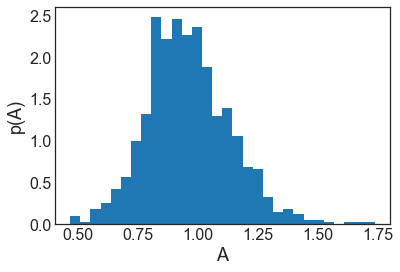

In [34]:
_=plt.hist(mcmc_results.T[0],bins=30,density=True)
plt.xlabel("A")
plt.ylabel("p(A)")
print(mcmc_results.T[0].mean())
print(mcmc_results.T[0].std())

0.20303967847439947
0.024186298341494793


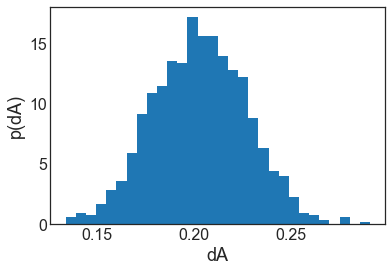

In [42]:
_=plt.hist(mcmc_results.T[2],bins=30,density=True)
plt.xlabel("dA")
plt.ylabel("p(dA)")
print(mcmc_results.T[2].mean())
print(mcmc_results.T[2].std())

0.9604388659152826
0.1727698589113163


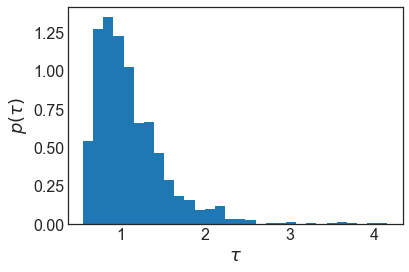

In [35]:
_=plt.hist(mcmc_results.T[1],bins=30,density=True)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
print(mcmc_results.T[0].mean())
print(mcmc_results.T[0].std())

0.373224480728388
0.26261768391835183


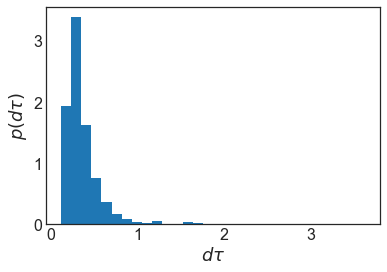

In [43]:
_=plt.hist(mcmc_results.T[3],bins=30,density=True)
plt.xlabel(r"$d\tau$")
plt.ylabel(r"$p(d\tau)$")
print(mcmc_results.T[3].mean())
print(mcmc_results.T[3].std())

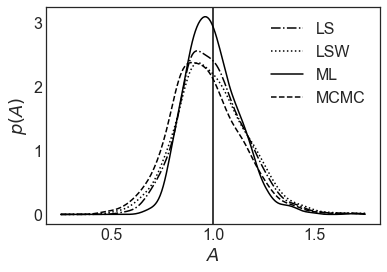

In [36]:
# amplitude KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0.25,1.75,200)
densityLS = gaussian_kde(result_array.T[2])
densityLSW = gaussian_kde(result_array.T[8])
densityML = gaussian_kde(result_Bayes_array.T[0])
densityMCMC = gaussian_kde(mcmc_results.T[0])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.plot(xs,densityMCMC(xs),"k--",label="MCMC")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")
plt.savefig("A_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

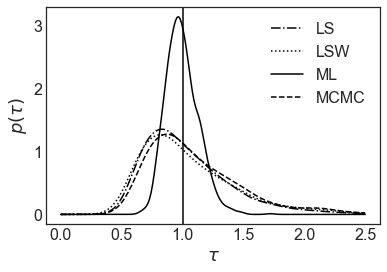

In [37]:
# decay time KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0,2.5,200)
densityLS = gaussian_kde(result_array.T[0])
densityLSW = gaussian_kde(result_array.T[6])
densityML = gaussian_kde(result_Bayes_array.T[2])
densityMCMC = gaussian_kde(mcmc_results.T[1])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.plot(xs,densityMCMC(xs),"k--",label="MCMC")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.savefig("tau_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(1000, 12)
(1000, 4)
(0.8342978728766376, 2.4941952676930888e-260)


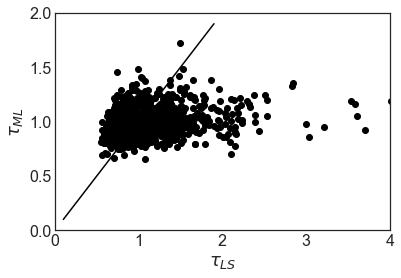

In [38]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(mcmc_results.T[1],result_Bayes_array.T[2],color="k")
plt.plot([0.1,1.9],[0.1,1.9],"k")
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(mcmc_results.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corrMCMC300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.8380888416857142, 6.71101223289797e-265)


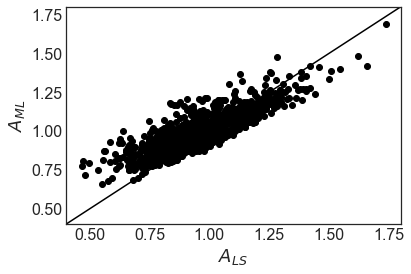

In [39]:
# amplitude correlation
plt.scatter(mcmc_results.T[0],result_Bayes_array.T[0],color="k")
plt.plot([0,1.8],[0,1.8],"k")
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(mcmc_results.T[0],result_Bayes_array.T[0]))
plt.savefig("A_corrMCMC300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [40]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude LSW mean (real):",result_array.T[7].mean())
print("Amplitude LSW std (real):",result_array.T[7].std())
print("Amplitude LSW stderr (real):",result_array.T[7].std()/np.sqrt(N))
print("Amplitude LSW std (fit):",np.sqrt(result_array.T[8]).mean())
print("Amplitude LSW std (fit corrected):",dAW.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())
print("Amplitude MCMC mean (real):",mcmc_results.T[0].mean())
print("Amplitude MCMC std (real):",mcmc_results.T[0].std())
print("Amplitude MCMC std (fit):",mcmc_results.T[2].mean())

Amplitude LS mean (real): 0.9984105682703185
Amplitude LS std (real): 0.16181660243234747
Amplitude LS stderr (real): 0.0016181660243234748
Amplitude LS std (fit): 1.6478751794738906
Amplitude LS std (fit corrected): 1.6578702573632431
Amplitude LSW mean (real): 0.0002714528255314531
Amplitude LSW std (real): 0.00034691485586727563
Amplitude LSW stderr (real): 3.4691485586727565e-06
Amplitude LSW std (fit): 0.9950832668680414
Amplitude LSW std (fit corrected): 1.6578702573632431
Amplitude Bayes mean (real): 0.9974432559467948
Amplitude Bayes std (real): 0.13182747665608338
Amplitude Bayes std (fit): 0.1410535876226702
Amplitude MCMC mean (real): 0.9604388659152826
Amplitude MCMC std (real): 0.1727698589113163
Amplitude MCMC std (fit): 0.20303967847439947


In [41]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time LSW mean (real):",result_array.T[5].mean())
print("Decay time LSW std (real):",result_array.T[5].std())
print("Decay time LSW stderr (real):",result_array.T[5].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[5].mean()-1)/result_array.T[5].std()*np.sqrt(N))
print("Decay time LSW std (fit):",np.sqrt(result_array.T[6]*delta_t).mean())
print("Decay time LSW std (fit corrected):",dTW.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())
print("Decay time MCMC mean (real):",mcmc_results.T[1].mean())
print("Decay time MCMC std (real):",mcmc_results.T[1].std())
print("Decay time MCMC std (fit):",mcmc_results.T[2].mean())

Decay time LS mean (real): 1.0511330280624347
Decay time LS std (real): 0.3905818920277206
Decay time LS stderr (real): 0.0039058189202772057
Decay time (mean-true)/stderr: 13.091499914902776
Decay time LS std (fit): 0.00011450259084103781
Decay time LS std (fit corrected): 0.000113979437567719
Decay time LSW mean (real): 1.953151405981036
Decay time LSW std (real): 2.062856350876919
Decay time LSW stderr (real): 0.020628563508769193
Decay time (mean-true)/stderr: 46.20541830631357
Decay time LSW std (fit): 0.10150797451666932
Decay time LSW std (fit corrected): 0.000113979437567719
Decay time Bayes mean (real): 0.9971927568886603
Decay time Bayes std (real): 0.13307109625094737
Decay time Bayes stderr (real): 0.0013307109625094737
Decay time Bayes std (fit): 0.141744498927101
Decay time MCMC mean (real): 1.1202184191525637
Decay time MCMC std (real): 0.4456452617512795
Decay time MCMC std (fit): 0.20303967847439947
